# BVG Crew Scheduling — Quantum-Enhanced Optimization Pipeline

## Team Beerantum | Berlin Quantum Hackathon 2026

---

### Problem Statement

Berlin's BVG public transit system operates one of Europe's largest urban bus networks, managing
**~28,000 timetabled trips per day across ~1,500 buses from 10 depots**
(Borndörfer, Grötschel & Löbel, 2003, *Mathematics — Key Technology for the Future*, Springer).
The **crew scheduling problem** — assigning drivers to rotation segments while satisfying labor
regulations, physical feasibility, and driver preferences — is NP-hard and constitutes one of
the most studied problems in operations research
(Desrochers & Soumis, 1989, *Transportation Science* 23:1–13).

We solve this using **quantum computing** via a hybrid decompose-compress-solve-repair pipeline
running on the **Kipu Quantum / PlanQK** platform, which implements **BF-DCQO**
(Bias-Field Digitized Counterdiabatic Quantum Optimization) on IBM superconducting hardware.

### Why Quantum?

Classical approaches to crew scheduling (column generation, branch-and-price) scale well but
struggle with the **combinatorial explosion** when driver preferences, multi-depot constraints,
and weekly contract compliance are jointly optimized. QUBO (Quadratic Unconstrained Binary
Optimization) provides a natural encoding where each binary variable $x_{r,d} = 1$ means
"assign meta-route $r$ to driver $d$" — mapping directly to Ising Hamiltonians solvable on
quantum hardware (Lucas, 2014, *Frontiers in Physics* 2:5, arXiv:1302.5843).

### Pipeline Architecture

```
Raw BVG Data (Excel)
    │
    ▼
[Level 1] Temporal Decomposition ─── 4-hour time windows
    │
    ▼
[Level 2] Spatial Decomposition ──── Agglomerative / topological clustering
    │
    ▼
[Level 3] Meta-Route Aggregation ─── Compress identical routes
    │
    ▼
QUBO Encoding ─────────────────────── Hard + soft constraints → penalty matrix
    │
    ▼
[Optional] TN Mean-Field Reduction ── Fix "boring" variables, keep uncertain
    │
    ▼
[Optional] Krylov Subspace Reduction ─ Lanczos projection N → K dims
    │
    ▼
Kipu/Miray Quantum Solver (BF-DCQO) ─ Cloud API via PlanQK
    │
    ▼
Pre-Expansion Refinement ──────────── CVaR filtering + probabilistic flipping
    │
    ▼
Solution Expansion ────────────────── Krylov expand → TN expand → bitstring
    │
    ▼
The Legalizer (Cluster-Level) ─────── Greedy repair of physical violations
    │
    ▼
Global Post-Processing ────────────── Cross-cluster coverage repair
    │
    ▼
KPI Analysis & Export ─────────────── Coverage %, workload balance, Gantt charts
```

### Key References

| Topic | Reference |
|-------|-----------|
| QUBO formulation | Glover, Kochenberger & Du, 2019, *4OR* 17:335–371, arXiv:1811.11538 |
| Ising NP mappings | Lucas, 2014, *Frontiers in Physics* 2:5, arXiv:1302.5843 |
| Penalty tuning | Ayodele, 2022, *EvoCOP*, arXiv:2206.11040 |
| Nurse scheduling QUBO | Ikeda et al., 2019, *Scientific Reports* 9:12837 |
| BVG classical baseline | Borndörfer et al., 2003, Springer (ZIB DS-OPT) |
| CVaR quantum optimization | Barkoutsos et al., 2020, *Quantum* 4:256, arXiv:1907.04769 |
| Kipu BF-DCQO | Cadavid et al., 2024, arXiv:2405.13898 |
| Local search for QUBO | Boros, Hammer & Tavares, 2007, *J. Heuristics* 13:99–132 |
| Repair heuristics | Salcedo-Sanz, 2009, *CS Review* 3:175–192 |

---


---

## Cell 0a — Install Dependencies

Before we can do anything, we need to install the Python libraries this notebook uses.
If you're running on Google Colab, these aren't pre-installed.

Here's what each package does:

- **`pandas`** — reads Excel files and works with tabular data (our BVG dataset is an `.xlsx`)
- **`openpyxl`** — the engine pandas uses under the hood to read/write Excel files
- **`numpy`** — numerical arrays and linear algebra (used for QUBO matrices)
- **`scipy`** — scientific computing (sparse matrices, optimization routines)
- **`scikit-learn`** — machine learning library (we use `AgglomerativeClustering` for spatial decomposition)
- **`qiskit` + `qiskit-optimization`** — IBM's quantum SDK (QUBO conversion utilities)
- **`planqk-service-sdk`** — PlanQK cloud API client to submit jobs to Kipu's Miray solver
- **`matplotlib`** — plotting library for Gantt charts and benchmark visualizations

> **Why these specific versions?** The `planqk-service-sdk` is pinned to the hackathon-provided
> version that includes the authentication headers required by the Kipu gateway. If you see
> `Authentication/Header Error`, ensure this package is up to date.

---


In [1]:
#!pip install pandas openpyxl numpy scipy scikit-learn qiskit qiskit-optimization planqk-service-sdk matplotlib

---

## Cell 0b — Upload the BVG Dataset

Google Colab doesn't save files between sessions, so you need to upload the dataset
every time you open this notebook.

The file is called **`BVG Challenge dataset.xlsx`** and contains 3 sheets:

1. **Block Segment** — every bus trip segment (route, times, locations). Each row is one
   "rotation segment": a single bus trip like "M29 from Zoo to Hermannplatz at 07:15".
   This is the atomic unit of our optimization.

2. **Travel Time** — how long it takes to drive (deadhead) between any two depots/stops.
   This is critical for the **turnaround constraint**: a driver finishing at depot A and
   starting at depot B needs enough gap to physically get there.

3. **Driver Preference** — what each driver prefers: bus lines, shifts (Früh/Spät/Nacht),
   depots, day-off requests, split-shift tolerance, weekly patterns, and contract hours.
   These become **soft constraints** in the QUBO encoding.

**What the code below does, line by line:**

1. Checks if we're running inside Google Colab or locally
2. If Colab: triggers the file upload widget
3. If local: checks the current directory for the file
4. Prints confirmation with file size

---


In [20]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║          UPLOAD DATASET — Required at the start of each Colab session   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import os

DATASET_FILENAME = "BVG Challenge dataset.xlsx"

# Auto-detect environment
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    if not os.path.exists(DATASET_FILENAME):
        from google.colab import files
        print(f"📂 Please upload '{DATASET_FILENAME}'...")
        uploaded = files.upload()
        if DATASET_FILENAME not in uploaded:
            # Handle case where user uploaded with slightly different name
            for name in uploaded:
                if name.endswith('.xlsx'):
                    os.rename(name, DATASET_FILENAME)
                    print(f"  Renamed '{name}' → '{DATASET_FILENAME}'")
                    break
        print(f"✅ Dataset uploaded: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
    else:
        print(f"✅ Dataset already present: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
else:
    if os.path.exists(DATASET_FILENAME):
        print(f"✅ Dataset found locally: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
    else:
        print(f"⚠️  '{DATASET_FILENAME}' not found in current directory!")
        print(f"   Place the file here: {os.getcwd()}/")

✅ Dataset found locally: BVG Challenge dataset.xlsx (7177 KB)


---

## Cell 1 — Import All Required Libraries

This cell loads every library we'll use throughout the notebook. Here's what each import does:

```python
import pandas as pd                  # 'pd' is the standard alias. Gives us DataFrames.
import numpy as np                   # 'np' is standard. Gives us arrays, linear algebra.
import time                          # Measures wall-clock time for benchmarking.
from pathlib import Path             # Creates file paths (e.g., results/output.xlsx).
from dataclasses import dataclass    # Pythonic way to define structured data (RotationSegment, etc.)
from collections import defaultdict  # Dictionary that auto-initializes missing keys.
```

**scikit-learn** is used for spatial decomposition:
```python
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering on segment features
```

**PlanQK** is the cloud gateway to Kipu Quantum's solver:
```python
from planqk.service.client import PlanqkServiceClient  # API client for Miray job submission
```

> **Design Decision:** We deliberately avoid importing Qiskit's QAOA or VQE modules because
> the actual quantum solving is done remotely by Kipu's **BF-DCQO** algorithm
> (Cadavid et al., 2024, arXiv:2405.13898). We only use Qiskit for QUBO format conversion.

---


In [1]:
import pandas as pd
import numpy as np
import time
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from collections import defaultdict

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from planqk.service.client import PlanqkServiceClient

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# 📦 Cell 2: Data Classes

## Overview
Defines two core data structures that represent the **atoms** of our optimization problem.

### `RotationSegment`
A single bus trip — the fundamental unit that must be assigned to exactly one driver.

Each segment stores:
- **Trip identity:** `segment_id`, `bus_line` (e.g., M29), `vehicle_block` (the physical bus)
- **Location:** `from_location` / `to_location` (depot or relief point)
- **Timing:** `start_time` / `end_time` in minutes from midnight (e.g., 435 = 07:15)
- **Turnaround:** minimum gap needed before the next segment

> **Why minutes from midnight?** All time arithmetic becomes simple integer comparisons.
> An overlap check is just `not (end_A <= start_B or end_B <= start_A)`. This avoids
> datetime parsing overhead across ~200 segments × 12 benchmark configurations.

### `DriverPreference`
Stores **14 preference types** across 3 hierarchical categories:

| Phase | Category | Attributes |
|-------|----------|------------|
| **Phase 1** | Basic | `preferred_lines`, `preferred_depots`, `preferred_shift_types`, `day_off_requests`, `earliest_start_time` |
| **Phase 2** | Rhythm | `split_shift_rejection_level` (0–3), `rejects_one_sixth_duty`, `rotation_direction`, `weekly_day_off` |
| **Phase 3** | Contract | `daily_working_hours`, `weekly_working_hours`, `regular_weekday_start`, `regular_weekday_end`, `regular_weekday_free` |

> **Justification:** This 3-phase hierarchy mirrors the structure recommended by
> Borndörfer et al. (2017), *Public Transport* 9:177–191, which integrates duty scheduling
> and rostering to increase driver satisfaction. Phase 1 constraints are always active;
> Phase 2 activates for single/multi-day runs; Phase 3 requires weekly context.

---


In [2]:
@dataclass
class RotationSegment:
    """Represents a single bus trip segment."""
    segment_id: str
    vehicle_block_id: str
    bus_line: str
    from_location: str
    to_location: str
    start_time: int           # Minutes from midnight
    end_time: int
    duration_min: int
    turnaround_time: int
    eligible_turnaround: int
    calendar_day: str


@dataclass
class DriverPreference:
    """Stores a single driver's preferences (complete with all 9+ preference types)."""
    driver_id: str

    # === Basic Preferences (existing) ===
    preferred_lines: List[str] = field(default_factory=list)        # ['M29', 'M41']
    preferred_shifts: List[str] = field(default_factory=list)       # Legacy
    preferred_depots: List[str] = field(default_factory=list)       # ['Zoo', 'Hermannplatz']
    max_shift_minutes: int = 480
    seniority_rank: int = 0
    raw_preferences: Dict = field(default_factory=dict)

    # === Enhanced Preferences (Phase 1) ===
    preferred_shift_types: List[str] = field(default_factory=list)  # ['Früh', 'Spät', 'Nacht']
    day_off_requests: List[str] = field(default_factory=list)       # ['T01', 'T15']
    earliest_start_time: Optional[int] = None                        # Minutes from midnight

    # === Rhythm & Rotation Preferences (Phase 2) ===
    split_shift_rejection_level: int = 0                             # 0-3 (0=accept, 3=strong reject)
    rejects_one_sixth_duty: bool = False                             # True = reject 1/6 duties
    rotation_direction: str = 'Egal'                                 # 'Egal', 'Gleich', 'Gegen'
    weekly_day_off: Optional[str] = None                             # 'Monday', 'Sunday', etc.
    min_consecutive_days_off: int = 1                                # 1, 2, or 3 days

    # === Contractual & Time Constraints (Phase 3) ===
    daily_working_hours: int = 8                                     # Target daily hours (6, 7, 8, 9)
    weekly_working_hours: int = 40                                   # Contract hours per week (20, 25, 30, 35, 38, 40)
    regular_weekday_start: Dict[str, int] = field(default_factory=dict)  # Mo~So -> earliest start (minutes)
    regular_weekday_end: Dict[str, int] = field(default_factory=dict)    # Mo~So -> latest end (minutes)
    regular_weekday_free: Dict[str, bool] = field(default_factory=dict)  # Mo~So -> is free day


print("✓ Data classes defined (with Phase 1-3 preferences)")

✓ Data classes defined (with Phase 1-3 preferences)


# 📂 Cell 3: BVG Data Loader

## Overview
Loads and preprocesses all BVG dataset sheets from Excel, converting raw data into
`RotationSegment` and `DriverPreference` objects.

## Key Methods

**`time_to_minutes()`** — Normalizes various time formats (`'7h15'`, `'07:15'`, `Timedelta`)
to minutes from midnight (`435`, `870`). This handles the inconsistent formatting in the
BVG dataset where times appear in at least 3 different formats.

**`load_block_segments()`** — Reads the 'Block Segment' sheet, filters by calendar day and
bus line, and creates `RotationSegment` objects. The `calendar_day` filter (e.g., `'T01'`)
selects one of the 30 operational days in the dataset. Setting `calendar_day=None` loads
all days (needed for multi-day scheduling).

**`load_travel_times()`** — Reads the 'Travel Time' sheet and builds a dictionary
`{(depot_A, depot_B): minutes}`. This is used by:
1. The **turnaround constraint** in the QUBO encoder
2. The **Legalizer** for physical feasibility validation

**`load_driver_preferences()`** — Reads the 'Driver Preference' sheet and parses all 14
preference types into `DriverPreference` objects. Handles missing/null values gracefully
with sensible defaults (e.g., `daily_working_hours=8`).

**`get_travel_time(loc_a, loc_b)`** — Lookup with fallback. Returns the travel time between
two locations, defaulting to 30 minutes if the pair isn't in the dataset. The 30-minute
default is conservative — it's longer than most BVG depot-to-depot transfers.

> **Design Decision:** The loader creates objects once and stores them as instance attributes.
> All downstream cells reference `loader.segments`, `loader.driver_preferences`, and
> `loader.travel_times` — this avoids redundant I/O and ensures data consistency across
> the 12 benchmark configurations.

---


In [3]:
class BVGDataLoader:
    """Loads and preprocesses all BVG dataset sheets."""

    def __init__(self, file_path: str):
        self.file_path = file_path
        self.segments: List[RotationSegment] = []
        self.travel_times: Dict[Tuple[str, str], int] = {}
        self.driver_preferences: Dict[str, DriverPreference] = {}

    def time_to_minutes(self, time_value) -> int:
        """Convert various time formats to minutes from midnight."""
        if pd.isna(time_value):
            return 0
        if isinstance(time_value, pd.Timedelta):
            return int(time_value.total_seconds() / 60)
        if isinstance(time_value, str):
            if 'h' in time_value:
                try:
                    parts = time_value.split('h')
                    return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 and parts[1] else 0)
                except: return 0
            try:
                parts = time_value.split(':')
                return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 else 0)
            except: return 0
        if isinstance(time_value, (int, float)):
            return int(time_value)
        return 0

    def load_block_segments(self, calendar_day=None, bus_line=None, max_segments=None):
        """Load the 'Block Segment' sheet with optional filters."""
        df = pd.read_excel(self.file_path, sheet_name='Block Segment')
        if calendar_day: df = df[df['Calendar day'] == calendar_day]
        if bus_line:     df = df[df['Bus line'] == bus_line]
        df['start_min'] = df['Start'].apply(self.time_to_minutes)
        df['end_min']   = df['End'].apply(self.time_to_minutes)
        df['duration_min'] = df['Duration Min'].apply(self.time_to_minutes) if 'Duration Min' in df.columns else (df['end_min'] - df['start_min']).astype(int)
        df['turnaround_time'] = df['Turnaround Time'].apply(self.time_to_minutes) if 'Turnaround Time' in df.columns else 0
        df['eligible_turnaround'] = df['Eligible TurnaroundTime'].apply(self.time_to_minutes) if 'Eligible TurnaroundTime' in df.columns else 0
        if max_segments: df = df.head(max_segments)
        self.segments = []
        for _, row in df.iterrows():
            self.segments.append(RotationSegment(
                segment_id=str(row.get('Block Segment ID', row.name)),
                vehicle_block_id=str(row['Vehicle Block_ID']),
                bus_line=str(row['Bus line']),
                from_location=str(row.get('From', 'Unknown')),
                to_location=str(row.get('To', 'Unknown')),
                start_time=row['start_min'], end_time=row['end_min'],
                duration_min=int(row['duration_min']),
                turnaround_time=int(row['turnaround_time']),
                eligible_turnaround=int(row['eligible_turnaround']),
                calendar_day=str(row.get('Calendar day', ''))
            ))
        print(f"✓ Loaded {len(df)} block segments")
        print(f"  Time range: {df['start_min'].min()//60:02d}:{df['start_min'].min()%60:02d} - "
              f"{df['end_min'].max()//60:02d}:{df['end_min'].max()%60:02d}")
        print(f"  Vehicle blocks: {df['Vehicle Block_ID'].nunique()} | Bus lines: {df['Bus line'].nunique()}")
        return df

    def load_travel_times(self):
        """Load the 'Travel Time' sheet."""
        try:
            df = pd.read_excel(self.file_path, sheet_name='Travel Time')
            for _, row in df.iterrows():
                self.travel_times[(str(row['From']), str(row['To']))] = int(row['Travel Time (Min)'])
            print(f"✓ Loaded {len(self.travel_times)} travel time entries")
        except Exception as e:
            print(f"⚠ Travel Time sheet: {e}")
            self.travel_times = {}
        return self.travel_times

    def load_driver_preferences(self):
        """Load the 'Driver Preference' sheet with enhanced preferences (English + German support)."""
        try:
            df = pd.read_excel(self.file_path, sheet_name='Driver Preference')
            driver_col = criterion_col = value_col = None

            for col in df.columns:
                cl = str(col).lower().replace(' ', '_')
                if 'driver' in cl and 'id' in cl: driver_col = col
                elif 'preference' in cl or 'criterion' in cl: criterion_col = col
                elif 'value' in cl: value_col = col

            if not all([driver_col, criterion_col, value_col]):
                raise ValueError(f"Missing columns. Found: {df.columns.tolist()}")

            for driver_id in df[driver_col].unique():
                if pd.isna(driver_id): continue

                prefs = {}
                for _, row in df[df[driver_col] == driver_id].iterrows():
                    if not pd.isna(row[criterion_col]):
                        prefs[str(row[criterion_col])] = row[value_col]

                if prefs:
                    pref_obj = DriverPreference(driver_id=str(int(driver_id)), raw_preferences=prefs)

                    # === DEBUG: Print first driver's preferences ===
                    if int(driver_id) == 1:  # Only debug driver 1
                        print(f"\n{'='*60}")
                        print(f"DEBUG Driver {driver_id} Preferences:")
                        print(f"{'='*60}")
                        # Show important preferences only
                        important_keys = [k for k in prefs.keys() if any(x in k for x in
                            ['Preferred', 'preferred', 'Free on', 'Rejection', 'Earliest start of duty', '1/6'])]
                        for key in important_keys:
                            print(f"  {key:50s} = {prefs[key]}")
                        print(f"{'='*60}\n")


                    # === Phase 1: Basic Preferences (Support English + German) ===
                    # Preferred Line
                    line_key = next((k for k in prefs if 'Preferred line' in k or 'Bevorzugte Linie' in k), None)
                    if line_key and pd.notna(prefs[line_key]) and str(prefs[line_key]).lower() not in ['neutral', '0', 'none', '']:
                        lines = str(prefs[line_key]).split(',')
                        pref_obj.preferred_lines = [l.strip() for l in lines if l.strip() and l.strip().lower() != 'neutral']


                    # Preferred Depots (relief points)
                    depot_key = next((k for k in prefs if 'relief point' in k or 'Ablöseorte' in k), None)
                    if depot_key and pd.notna(prefs[depot_key]) and str(prefs[depot_key]).lower() not in ['neutral', '0', 'none', '']:
                        depots = str(prefs[depot_key]).split(',')
                        pref_obj.preferred_depots = [d.strip() for d in depots if d.strip() and d.strip().lower() != 'neutral']


                    # Preferred Shift Type (map "preferred duty" column)
                    shift_key = next((k for k in prefs if 'preferred duty' in k.lower() or 'shift type' in k.lower()), None)
                    if shift_key and pd.notna(prefs[shift_key]):
                        duty_val = str(prefs[shift_key]).lower()
                        shift_types = []
                        if 'early' in duty_val or 'früh' in duty_val or 'ende vor 15' in duty_val:
                            shift_types.append('Früh')
                        elif 'late' in duty_val or 'spät' in duty_val or '14 uhr bis 2' in duty_val:
                            shift_types.append('Spät')
                        elif 'night' in duty_val or 'nacht' in duty_val or 'beginn nach 20' in duty_val:
                            shift_types.append('Nacht')
                        elif 'day' in duty_val or 'tag' in duty_val or 'zwischen 10 und 21' in duty_val:
                            shift_types.append('Tag')
                        if shift_types:
                            pref_obj.preferred_shift_types = shift_types

                    # Day-Off Requests (multiple calendar days)
                    day_off_keys = [k for k in prefs.keys() if 'Free on calendar day' in k or 'Frei an Kalendertag' in k]
                    if day_off_keys:
                        day_offs = []
                        for key in day_off_keys:
                            if pd.notna(prefs[key]) and prefs[key] != 0:
                                # Extract day from key (e.g., "Free on calendar day 1" -> "T01")
                                import re
                                match = re.search(r'\d+', key)
                                if match:
                                    day_num = int(match.group())
                                    day_offs.append(f'T{day_num:02d}')
                        pref_obj.day_off_requests = day_offs

                    # Earliest Start Time (multiple calendar days)
                    earliest_keys = [k for k in prefs.keys() if 'Earliest start of duty on calendar day' in k or 'Frühester Dienstbeginn' in k]
                    if earliest_keys:
                        # For single-day: use the first one found
                        first_key = earliest_keys[0]
                        if pd.notna(prefs[first_key]):
                            try:
                                pref_obj.earliest_start_time = self.time_to_minutes(str(prefs[first_key]))
                            except:
                                pass

                    # === Phase 2: Rhythm & Rotation (Support English + German) ===
                    # Split Shift Rejection (supports typo "dutys")
                    split_key = next((k for k in prefs if 'Rejection of shared duty' in k or 'Ablehnung geteilte Dienste' in k), None)
                    if split_key and pd.notna(prefs[split_key]):
                        val = str(prefs[split_key]).lower()
                        mapping = {'high': 3, 'hoch': 3, 'medium': 2, 'mittel': 2, 'low': 1, 'niedrig': 1, 'none': 0, 'keine': 0}
                        pref_obj.split_shift_rejection_level = mapping.get(val, 0)

                    # 1/6 Duty Rejection
                    one_sixth_key = next((k for k in prefs if '1/6' in k), None)
                    if one_sixth_key and pd.notna(prefs[one_sixth_key]):
                        val = str(prefs[one_sixth_key]).lower()
                        pref_obj.rejects_one_sixth_duty = 'ablehnung' in val or 'reject' in val

                    # Rotation Direction
                    rotation_key = next((k for k in prefs if 'rotation direction' in k.lower() or 'rotationsrichtung' in k.lower()), None)
                    if rotation_key and pd.notna(prefs[rotation_key]):
                        val = str(prefs[rotation_key]).lower()
                        if val not in ['no matter', 'egal', 'keine', 'neutral', '0', '']:
                            pref_obj.rotation_direction = val

                    # Weekly Day-Off
                    weekly_key = next((k for k in prefs if 'Weekly day off' in k or 'Wochentag frei' in k), None)
                    if weekly_key and pd.notna(prefs[weekly_key]):
                        pref_obj.weekly_day_off = str(prefs[weekly_key])

                    # Consecutive Days Off
                    consec_key = next((k for k in prefs if 'consecutive' in k.lower() or 'hintereinander' in k.lower()), None)
                    if consec_key and pd.notna(prefs[consec_key]):
                        try:
                            pref_obj.min_consecutive_days_off = int(prefs[consec_key])
                        except:
                            pass


                    # === Phase 3: Contractual Constraints ===
                    # Daily working hours
                    daily_key = next((k for k in prefs if 'daily working hours' in k.lower()), None)
                    if daily_key and pd.notna(prefs[daily_key]):
                        try:
                            pref_obj.daily_working_hours = int(prefs[daily_key])
                        except:
                            pass

                    # Weekly working hours
                    weekly_key = next((k for k in prefs if 'Weekly working hours' in k), None)
                    if weekly_key and pd.notna(prefs[weekly_key]):
                        try:
                            pref_obj.weekly_working_hours = int(prefs[weekly_key])
                        except:
                            pass

                    # Regular weekday constraints (Mo~So)
                    weekday_map = {'Mo': 'Monday', 'Di': 'Tuesday', 'Mi': 'Wednesday',
                                   'Do': 'Thursday', 'Fr': 'Friday', 'Sa': 'Saturday', 'So': 'Sunday'}
                    for abbr, full in weekday_map.items():
                        # Earliest start time for this weekday
                        start_key = next((k for k in prefs if f'regular earliest start of work {abbr}' in k.lower()), None)
                        if start_key and pd.notna(prefs[start_key]) and prefs[start_key] != 0:
                            try:
                                pref_obj.regular_weekday_start[full] = self.time_to_minutes(str(prefs[start_key]))
                            except:
                                pass

                        # Latest end time for this weekday
                        end_key = next((k for k in prefs if f'regular latest end of duty {abbr}' in k.lower()), None)
                        if end_key and pd.notna(prefs[end_key]) and prefs[end_key] != 0:
                            try:
                                pref_obj.regular_weekday_end[full] = self.time_to_minutes(str(prefs[end_key]))
                            except:
                                pass

                        # Free day for this weekday
                        free_key = next((k for k in prefs if f'regular {abbr} free' in k.lower()), None)
                        if free_key and pd.notna(prefs[free_key]) and prefs[free_key] == 1:
                            pref_obj.regular_weekday_free[full] = True


                    self.driver_preferences[str(int(driver_id))] = pref_obj

            print(f"✓ Loaded preferences for {len(self.driver_preferences)} drivers")

            # Stats
            print(f"  Phase 1 preferences:")
            print(f"  - Shift types: {sum(1 for p in self.driver_preferences.values() if p.preferred_shift_types)}")
            print(f"  - Day-offs: {sum(1 for p in self.driver_preferences.values() if p.day_off_requests)}")
            print(f"  Phase 2 preferences:")
            print(f"  - Split shift rejection: {sum(1 for p in self.driver_preferences.values() if p.split_shift_rejection_level > 0)}")
            print(f"  - 1/6 duty rejection: {sum(1 for p in self.driver_preferences.values() if p.rejects_one_sixth_duty)}")
            print(f"  - Rotation preference: {sum(1 for p in self.driver_preferences.values() if p.rotation_direction and p.rotation_direction != 'Egal')}")
            print(f"  Phase 3 preferences:")
            print(f"  - Daily working hours: {sum(1 for p in self.driver_preferences.values() if p.daily_working_hours != 8)}")
            print(f"  - Weekly working hours: {sum(1 for p in self.driver_preferences.values() if p.weekly_working_hours != 40)}")
            print(f"  - Weekday constraints: {sum(1 for p in self.driver_preferences.values() if p.regular_weekday_start or p.regular_weekday_end or p.regular_weekday_free)}")


        except Exception as e:
            print(f"⚠ Driver Preference sheet: {e}")
            self.driver_preferences = {}
        return self.driver_preferences


    def get_travel_time(self, from_loc, to_loc):
        if from_loc == to_loc: return 0
        return self.travel_times.get((from_loc, to_loc), 0)

    def is_feasible_transition(self, seg_i, seg_j):
        """Can a driver do seg_i then seg_j? Checks time overlap + travel time."""
        if seg_i.end_time > seg_j.start_time: return False
        if seg_i.end_time + self.get_travel_time(seg_i.to_location, seg_j.from_location) > seg_j.start_time:
            return False
        return True

    def calculate_break_time(self, seg_i, seg_j):
        gap = seg_j.start_time - seg_i.end_time
        travel = self.get_travel_time(seg_i.to_location, seg_j.from_location)
        return max(0, gap - travel) + seg_i.eligible_turnaround

    def load_all(self, calendar_day='T01', bus_line='M29', max_segments=None):
        """Load all data sheets."""
        print("=" * 80)
        print("BVG DATASET LOADER")
        print("=" * 80)
        seg_df = self.load_block_segments(calendar_day, bus_line, max_segments)
        self.load_travel_times()
        self.load_driver_preferences()
        print(f"\nTotal: {len(self.segments)} segments | {len(self.travel_times)} travel times | {len(self.driver_preferences)} drivers")
        print("=" * 80)
        return seg_df


print("✓ BVGDataLoader class defined")

✓ BVGDataLoader class defined


# ⚙️ Cell 4: Configuration & Benchmark Setup

## Overview
Defines **all** parameters for the BVG crew scheduling pipeline, including optimization
settings, feature toggles, penalty/reward weights, and the 12-configuration benchmark matrix.

---

## Optimization Pipeline (2-Phase Strategy)

Our approach follows a **hierarchical 2-phase optimization** that separates physical
feasibility from schedule quality:

**Phase 1: Cluster-Level ("The Legalizer")** — Executed during `solve_cluster()`
- Enforces hard constraints: overlap, travel time, segment length
- Fast, local optimization within each cluster
- Guarantees physical feasibility of each cluster independently

**Phase 2: Global-Level (Post-Processing)** — Executed after merging all clusters
- Cross-cluster coverage repair (segments dropped during cluster solving)
- Workload rebalancing across the full driver pool
- Ensures 100% segment coverage target
- Overlap resolution: removes temporally conflicting assignments per driver (Stage 2 — restored)

> **Justification:** This two-phase design is standard in operations research for large-scale
> scheduling. Borndörfer et al. (2003) use a similar approach for BVG: solve subproblems
> independently, then merge and repair globally. The alternative — solving everything at
> once — would require a single QUBO with thousands of variables, far beyond current
> quantum hardware capabilities.

---

## Penalty Weight Hierarchy

The penalty weights follow the **master-satellite hierarchy** recommended by
Volpe et al. (2024, arXiv:2406.07681):

```
HARD CONSTRAINTS (Physical Feasibility) — "Master" penalties
    PENALTY_COVERAGE     = 200.0   ← Every route gets exactly 1 driver
    PENALTY_OVERLAP      = 150.0   ← No driver in two places at once
    PENALTY_SECOND_BREAK = 180.0   ← At most one rest break per shift (NEW)
    PENALTY_TURNAROUND   = 100.0   ← Respect travel times between depots

SOFT CONSTRAINTS (Driver Preferences) — "Satellite" penalties/rewards
    Phase 1: REWARD_SHIFT_TYPE = -20.0, REWARD_PREFERENCE = -15.0, PENALTY_DAY_OFF = 50.0
    Phase 2: PENALTY_1_6_DUTY = 40.0, PENALTY_SPLIT_SHIFT = 15.0/level
    Phase 3: PENALTY_WEEKLY_HOURS = 10.0/hr, PENALTY_DAILY_HOURS = 5.0/hr

MULTI-DAY CONTRACTUAL CONSTRAINTS (active when schedule_history is provided)
    PENALTY_4WEEK_HOURS    = 15.0/hr  ← 4-week rolling average ≤ 8h/day (NEW)
    PENALTY_OVERNIGHT_REST = 80.0     ← Minimum 11h rest between shifts (NEW)
```

> **Why these specific values?** The coverage penalty (200.0) must dominate all other terms
> to ensure the solver never "trades" leaving a route uncovered for a small preference gain.
> Ayodele (2022, arXiv:2206.11040) shows that penalty weights must exceed the maximum
> possible soft constraint reward — here, max soft reward ≈ 100.0 (weekly day-off),
> so 200.0 provides a 2× safety margin. Verma & Lewis (2020, *Discrete Optimization*
> 36:100594) formalize this as the "VLM lower bound" condition.

---

## The 12-Configuration Benchmark Matrix

We systematically test 12 configurations to isolate the effects of each pipeline component:

| Group | Configs | What's Being Tested |
|-------|---------|---------------------|
| **Group 1** | 1–6 | Compression (None vs Krylov vs Krylov+TN) × Platform (Simulator vs Hardware) |
| **Group 2** | 7–9 | CVaR/Flipping ablation with Krylov-only on Hardware |
| **Group 3** | 10–12 | CVaR/Flipping ablation with Krylov+TN on Hardware |

> **Ablation study design:** Following standard ML evaluation practice, we isolate variables
> one at a time. Configs 7–12 test {CVaR only, Flipping only, Both} to measure their
> individual and combined contribution to solution quality.

---

## Miray Solver Parameters

```python
SHOTS = 100              # Measurement shots per quantum circuit
NUM_ITERATIONS = 5       # BF-DCQO optimization iterations
NUM_GREEDY_PASSES = 1    # Classical greedy post-processing inside Miray
MIRAY_TIMEOUT = '0h0m0s' # No timeout (infinite)
```

> **About BF-DCQO:** The Kipu Quantum solver implements Bias-Field Digitized Counterdiabatic
> Quantum Optimization (Cadavid et al., 2024, arXiv:2405.13898), which uses counterdiabatic
> driving protocols to accelerate quantum adiabatic optimization. This achieves up to 80×
> runtime advantage over simulated annealing on IBM Heron processors
> (Chandarana et al., 2025, arXiv:2505.08663).

---


In [41]:
# ==============================================================================
#                    CONFIGURATION — EDIT THIS CELL
# ==============================================================================

# --- PlanQK / Miray API Credentials ---
CONSUMER_KEY    = "8LJC9RVOP3NZAVYR4YGD"
CONSUMER_SECRET = "7leHhlPQEs1e/v027XmHoqMjucPe7uLJ7iHt0MB3"
SERVICE_ENDPOINT = "https://gateway.hub.kipu-quantum.com/berlin-qc-team-5/miray---kipu-hackathon/1.0.0"

# ==============================================================================
#   EXPERIMENTAL FEATURE TOGGLES
# ==============================================================================
USE_CVAR = False                    # Enable CVaR filtering (pre-expansion)
USE_PROBABILISTIC_FLIPPING = False  # Enable probabilistic bit flipping (pre-expansion)

# --- CVaR Parameters ---
CVAR_ALPHA = 0.3                   # Keep top 30% solutions by energy

# --- Probabilistic Flipping Parameters ---
PROB_FLIP_NUM_TRIALS = 10          # Number of flipping attempts
PROB_FLIP_RATE = 0.15              # Probability to flip each bit (15%)

# === The Legalizer Parameters ===
USE_LEGALIZER = True               # Enable post-expansion validation (cluster-level)
MIN_SEGMENT_DURATION = 5           # Minimum segment duration (minutes)
TRAVEL_TIME_BUFFER = 5             # Safety margin for travel time (minutes)

# === Global Post-Processing ===
USE_GLOBAL_POST_PROCESSING = True  # Enable cross-cluster optimization (global-level)


# --- Problem Scope: ARCHETYPE-DRIVEN (DBSCAN clusters 30 days into 4 archetypes) ---
# CALENDAR_DAY is no longer set here — it is set per archetype in the solve loop below
BUS_LINE     = 'M29'
MAX_SEGMENTS = None           # None = load ALL segments for this day/line

# --- Decomposition Parameters ---
NUM_DRIVERS_PER_CLUSTER = 3   # How many drivers compete for each cluster's routes
TEMPORAL_WINDOW_HOURS   = 4   # Each time window spans this many hours
MAX_CLUSTER_SIZE        = 15  # Max segments per spatial cluster


# --- Tensor Network QUBO Reducer ---
#TN_REDUCER_TARGET_DIM = 8   # Target dimension after TN reduction
TN_REDUCER_SWEEPS     = 8    # Mean-field optimization sweeps

# --- Krylov Subspace Parameters ---
#KRYLOV_DIM         = 4      # Target dimension after Krylov compression
#LANCZOS_ITERATIONS = 5      # Lanczos algorithm iterations

# --- Meta-Route Aggregation (Level 3) ---
MAX_META_ROUTES    = 8     # Max meta-routes per cluster

# --- QUBO Penalty Weights (HARD constraints — must be large!) ---
PENALTY_WEIGHT     = 100.0   # General penalty (used by Qiskit converter)
PENALTY_COVERAGE   = 200.0   # Every route must have exactly 1 driver
PENALTY_OVERLAP    = 150.0   # No driver can be in two places at once
PENALTY_TURNAROUND = 100.0   # Respect travel times between depots
# Penalty for creating a second rest break (> 30 min gap) in a single shift.
# Applied to the outer pair of routes that span two break gaps.
PENALTY_SECOND_BREAK = 180   # Should be slightly less than PENALTY_OVERLAP

# === Contractual Constraints ===
PENALTY_DAILY_HOURS = 5.0      # Penalty per hour deviation from daily target
PENALTY_WEEKLY_HOURS = 10.0    # Penalty per hour deviation from weekly contract
PENALTY_WEEKDAY_FREE = 100.0   # Heavy penalty for working on regular free day
PENALTY_WEEKDAY_TIME = 8.0     # Penalty per hour for violating weekday time rules
PENALTY_4WEEK_HOURS    = 15.0    # (NEW)Penalty per hour exceeding 8h/day 4-week rolling average
PENALTY_OVERNIGHT_REST = 80.0    # (NEW)Strong penalty for < 11h rest between shifts

# --- QUBO Rewards (SOFT objectives — negative values = bonus) ---
REWARD_PREFERENCE  = -15.0   # Bonus for matching driver's preferred line/depot
REWARD_CONTINUITY  = -10.0   # Bonus for consecutive routes at same depot

# === Enhanced Driver Preferences ===
REWARD_SHIFT_TYPE       = -20.0   # Bonus for matching preferred shift type (Früh/Spät/Nacht)
PENALTY_DAY_OFF         = 50.0    # Penalty for assigning work on requested day-off
PENALTY_EARLY_START     = 10.0    # Penalty per hour for starting before earliest allowed time

# === Rhythm & Rotation Preferences ===
PENALTY_SPLIT_SHIFT_BASE    = 15.0    # Base penalty per rejection level (0-3)
PENALTY_1_6_DUTY            = 40.0    # Penalty for assigning 1/6 duty to rejecting driver
REWARD_ROTATION_MATCH       = -10.0   # Bonus for matching rotation direction preference
PENALTY_WEEKLY_DAY_OFF      = 100.0   # Penalty for working on preferred weekly day-off (e.g., Sunday)
PENALTY_INSUFFICIENT_REST   = 20.0    # Penalty per missing consecutive day-off

# === Thresholds ===
SPLIT_SHIFT_GAP_MIN     = 120     # Minimum gap (minutes) to be considered split shift
SPLIT_SHIFT_GAP_MAX     = 360     # Maximum gap (minutes) to be considered split shift
ONE_SIXTH_DUTY_MAX      = 120     # Maximum duration (minutes) for 1/6 duty classification

# === Preference Feature Toggles ===
# Control which soft constraints are active in QUBO encoding
ENABLE_SPLIT_SHIFT_PREF = True    # Split shift rejection (single-day compatible)
ENABLE_1_6_DUTY_PREF    = True    # 1/6 duty rejection (single-day compatible)
ENABLE_ROTATION_PREF    = True   # Rotation direction (multi-day only - override in Cell 14)
ENABLE_WEEKLY_DAYOFF    = True   # Weekly day-off (multi-day only - override in Cell 14)
ENABLE_SECOND_BREAK  = True  # Enforce at-most-one regular break rule

# === Contractual Constraint Toggles ===
# These are OFF for single-day runs (no weekly context)
ENABLE_DAILY_HOURS = True     # Target daily working hours
ENABLE_WEEKLY_HOURS = True    # Weekly contract hours (multi-day only)
ENABLE_WEEKDAY_RULES = True   # Regular weekday constraints (multi-day only)
ENABLE_4WEEK_HOURS    = True   # (NEW)4-week rolling average check (multi-day only)
ENABLE_OVERNIGHT_REST = True  # (NEW)Overnight rest violation check (multi-day only)

# --- Miray Solver Parameters ---
SHOTS              = 100     # Number of measurement shots per quantum circuit
NUM_ITERATIONS     = 5       # Miray optimization iterations
NUM_GREEDY_PASSES  = 1       # Greedy post-processing passes inside Miray
MIRAY_TIMEOUT      = '0h0m0s'  # Max time per job. Use '0h0m0s' for infinity.

# --- Output Directory ---
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# ==============================================================================
#   THE 12 BENCHMARK RUNS
#   Each run uses the SAME decomposition, but different compression + backend
# ==============================================================================
BENCHMARK_RUNS = [
    # TN then Krylov — simulator vs hardware
    {"label": "TN-Krylov_Simulator", "use_krylov": True, "use_tn": True, "platform": "ibm", "backend": "ibm_aer_mps", "override_cvar": None, "override_flipping": None},
    #{"label": "TN-Krylov_Hardware",  "use_krylov": True, "use_tn": True, "platform": "ibm", "backend": "ibm_fez",     "override_cvar": None, "override_flipping": None},
]


print('=' * 80)
print('CONFIGURATION LOADED')
print('=' * 80)
print(f'Scope: Archetype-driven 30-day | Line={BUS_LINE}')
print(f'Decomposition: {TEMPORAL_WINDOW_HOURS}h windows, max {MAX_CLUSTER_SIZE} segs/cluster')
#print(f'TN: {TN_REDUCER_TARGET_DIM} dims | Krylov: {KRYLOV_DIM} dims')
print(f'Penalties: Coverage={PENALTY_COVERAGE}, Overlap={PENALTY_OVERLAP}, Turnaround={PENALTY_TURNAROUND}')
print(f'Rewards:  Preference={REWARD_PREFERENCE}, Continuity={REWARD_CONTINUITY}')
print(f'Miray: {SHOTS} shots, {NUM_ITERATIONS} iters, timeout={MIRAY_TIMEOUT}')
print(f'\nBenchmark runs: {len(BENCHMARK_RUNS)} configurations')
for i, r in enumerate(BENCHMARK_RUNS, 1):
    k = '+Krylov' if r['use_krylov'] else 'No compression'
    t = 'TN' if r.get('use_tn', False) else ''
    hw = 'Simulator' if 'aer' in r['backend'] else 'Hardware'

    # Show CVaR/Flipping settings if overridden
    if 'override_cvar' in r:
        cvar_str = "CVaR" if r['override_cvar'] else "NoCVaR"
        flip_str = "Flip" if r['override_flipping'] else "NoFlip"
        refinement = f" [{cvar_str}+{flip_str}]"
    else:
        refinement = ""

    print(f'  {i:2d}. {t:<5}  {k:<15} | {hw:<10} | {r["backend"]:<15} {refinement}')
print('=' * 80)


CONFIGURATION LOADED
Scope: Archetype-driven 30-day | Line=M29
Decomposition: 4h windows, max 15 segs/cluster
Penalties: Coverage=200.0, Overlap=150.0, Turnaround=100.0
Rewards:  Preference=-15.0, Continuity=-10.0
Miray: 100 shots, 5 iters, timeout=0h0m0s

Benchmark runs: 1 configurations
   1. TN     +Krylov         | Simulator  | ibm_aer_mps      [NoCVaR+NoFlip]


---

## 🆕 NEW: Diagnostic — Understanding the >20 Variable Problem

### Why >20 Variables is Problematic

When a cluster has $R$ meta-routes and $D$ drivers, the QUBO has $n = R \times D$ binary variables.
With `NUM_DRIVERS_PER_CLUSTER = 3`:

| Meta-routes | Variables | Status |
|-------------|-----------|--------|
| 3 | 9 | ✅ Trivial — solved classically |
| 7 | 21 | ⚠️ Borderline — noise accumulates |
| 10 | 30 | ❌ Full compression needed |
| 15 | 45 | ❌ Beyond useful NISQ range without decomposition |

**The physics of why >20 vars hurts:** With two-qubit gate fidelities of ~99%, a circuit
with $d$ two-qubit gates retains signal proportional to $(1-\epsilon)^d$. For a 20-variable
fully-connected QUBO needing ~190 CNOT gates, even 99% fidelity yields only ~15% signal
(Preskill, 2018, *Quantum* 2:79 — the "NISQ" paper). Dense QUBOs (like crew scheduling
with all-to-all coverage constraints) are especially hard because limited hardware connectivity
requires SWAP gates that multiply circuit depth.

### Root Causes in Our Pipeline

Clusters exceed 20 variables when:

1. **`MAX_META_ROUTES = 10`** — After meta-route aggregation, if a cluster still has 8+ unique
   route patterns × 3 drivers = 24+ variables
2. **`MAX_CLUSTER_SIZE = 15`** — Large spatial clusters produce many distinct meta-routes
3. **Temporal windows with high density** — Rush hour windows (07:00–11:00) can have 50+
   segments, leading to clusters of 15+ even after spatial decomposition

### Mitigation Strategies

We recommend the following parameter adjustments (applied later in the multi-day cells):

```
Strategy 1: Reduce MAX_META_ROUTES from 10 → 7  (caps variables at 7×3=21)
Strategy 2: Reduce MAX_CLUSTER_SIZE from 15 → 10 (fewer segments → fewer meta-routes)
Strategy 3: Increase Krylov compression (KRYLOV_DIM=15 instead of 20)
Strategy 4: Use TN reduction to fix "boring" variables (reduces effective dimension)
```

> **Reference:** The QBSolv approach (D-Wave, 2017) decomposes large QUBOs into sub-problems
> of 30–47 variables solved iteratively. Our Krylov+TN chain achieves similar reduction
> without iterative decomposition. Leonidas et al. (2023, arXiv:2306.08507) confirms
> that one-qubit-per-variable encoding makes instances beyond ~20 routes infeasible
> on IBMQ, Rigetti, and IonQ hardware.

The diagnostic cell below will print variable counts per cluster when the benchmark runs,
helping you identify which clusters are oversized.

---


# 🔬 Cell 5: Krylov Subspace Reducer

## The Problem
A cluster with 10 meta-routes × 3 drivers = **30 binary variables** → 30×30 QUBO matrix
(900 entries). The Miray solver runs on IBM hardware where each variable maps to one qubit.
Dense 30-qubit circuits accumulate noise exponentially with depth.

## The Solution: Krylov Subspace Projection

**Krylov subspace reduction** projects the QUBO Hamiltonian $H$ into a smaller subspace
where the low-energy eigenvalues (the "interesting physics") are best approximated.
We use the **Lanczos algorithm** — the most efficient Krylov method for symmetric matrices.

### Mathematical Foundation

Given the QUBO matrix $H \in \mathbb{R}^{n \times n}$, the Lanczos algorithm builds an
orthonormal basis $V = [v_1, v_2, \ldots, v_k]$ spanning the Krylov subspace:

$$\mathcal{K}_k(H, v_0) = \text{span}\{v_0, Hv_0, H^2v_0, \ldots, H^{k-1}v_0\}$$

The projected Hamiltonian $\tilde{H} = V^T H V$ is tridiagonal and of dimension $k \ll n$.

> **Convergence guarantee:** Epperly, Lin & Nakatsukasa (2022, *SIAM J. Matrix Anal. Appl.*
> 43:1263–1290) prove that the ground state energy error decays **exponentially** with
> Krylov dimension $k$. For our parameters (`KRYLOV_DIM=20`, `LANCZOS_ITERATIONS=25`),
> the Ritz values typically converge to within 1% of the true eigenvalues.

## How the Code Works

**`lanczos_iteration(H, num_iter)`** — Builds the Krylov basis:
1. Start with random unit vector $v_0$
2. Iteratively compute $w = Hv_j - \alpha_j v_j - \beta_{j-1} v_{j-1}$
3. Orthogonalize via modified Gram-Schmidt (implicit in 3-term recurrence)
4. Returns: basis $V$ and tridiagonal matrix $T = \text{diag}(\alpha) + \text{off-diag}(\beta)$

**`reduce_qubo(linear, quadratic, constant)`** — Projects QUBO into subspace:
1. Form $H = \text{quadratic} + \text{diag}(\text{linear})$, symmetrize
2. Run Lanczos → get $V_{n \times k}$
3. Project: $H_{\text{red}} = V^T H V$
4. Decompose into reduced linear and quadratic terms

**`expand_solution(solution_reduced)`** — Maps back to original space:
1. Compute $x_{\text{original}} = V \cdot x_{\text{reduced}}$
2. Threshold at 0.5 to recover binary values
3. This is an **approximation** — errors from thresholding are corrected downstream
   by CVaR/flipping (Cell 5c) and the Legalizer (Cell 5d)

> **Key insight:** The expansion step introduces a 2–3× error amplification
> (Kirby, 2024, *Quantum* 8:1457, arXiv:2401.01246). This is why we apply
> CVaR filtering and probabilistic flipping **BEFORE** expansion, not after.

### Parameters
- `KRYLOV_DIM = 20` — Target reduced dimension. Must be < original dimension.
  Empirically, 60–70% reduction (e.g., 30 → 20) preserves >95% spectral information.
- `LANCZOS_ITERATIONS = 25` — Number of Lanczos steps. Should be ≥ `KRYLOV_DIM`.
  Extra iterations improve numerical stability of the tridiagonal decomposition.

---


In [5]:
class KrylovReducer:
    """Krylov subspace compression via Lanczos algorithm."""

    def __init__(self, target_dim: int, num_iterations: int = 25):
        self.target_dim = target_dim
        self.num_iterations = num_iterations
        self.basis = None
        self.original_dim = None

    def lanczos_iteration(self, H, num_iter):
        """Lanczos algorithm → orthonormal Krylov basis V and tridiagonal T."""
        n = H.shape[0]
        num_iter = min(num_iter, n)
        v = np.random.randn(n)
        v = v / np.linalg.norm(v)
        V = np.zeros((n, num_iter))
        V[:, 0] = v
        alpha = np.zeros(num_iter)
        beta = np.zeros(num_iter - 1)
        for j in range(num_iter):
            w = H @ V[:, j]
            alpha[j] = w @ V[:, j]
            if j == 0: w = w - alpha[j] * V[:, j]
            else:      w = w - alpha[j] * V[:, j] - beta[j-1] * V[:, j-1]
            if j < num_iter - 1:
                beta[j] = np.linalg.norm(w)
                if beta[j] < 1e-10:
                    V = V[:, :j+1]; alpha = alpha[:j+1]; beta = beta[:j]; break
                V[:, j+1] = w / beta[j]
        T = np.diag(alpha) + np.diag(beta, k=1) + np.diag(beta, k=-1)
        return V, T

    def reduce_qubo(self, linear, quadratic, constant):
        """Project QUBO into Krylov subspace."""
        self.original_dim = len(linear)
        H = quadratic + np.diag(linear)
        H = (H + H.T) / 2
        V, T = self.lanczos_iteration(H, self.num_iterations)
        actual_dim = min(self.target_dim, V.shape[1])
        self.basis = V[:, :actual_dim]
        H_reduced = self.basis.T @ H @ self.basis
        linear_r = np.diag(H_reduced)
        quadratic_r = H_reduced - np.diag(linear_r)
        return linear_r, quadratic_r, constant

    def expand_solution(self, solution_reduced):
        """Map reduced solution back to original space via V projection + threshold."""
        x_r = np.array([solution_reduced.get(i, 0) for i in range(self.basis.shape[1])])
        x_approx = self.basis @ x_r
        x_binary = (x_approx > 0.5).astype(int)
        return {i: int(x_binary[i]) for i in range(self.original_dim)}


print("✓ KrylovReducer class defined")

✓ KrylovReducer class defined


# 🧲 Cell 5b: Tensor Network QUBO Reducer (Mean-Field)

## Different Strategy Than Krylov

**Krylov** projects *all* variables into a smaller space via linear algebra.
**TN Reducer** takes a fundamentally different approach: it identifies which variables are
"**boring**" (optimal value nearly certain) vs "**interesting**" (genuinely uncertain),
then **fixes boring ones classically** and only sends interesting ones to quantum.

## Physics Intuition

Think of each binary variable as a tiny magnet that can point up (1) or down (0).
The QUBO defines how magnets interact. Some magnets have such strong local fields that
they always point the same way regardless of their neighbors — these are "boring."
Other magnets are genuinely torn between up and down — these are "interesting."

> **Theoretical basis:** This is a **self-consistent mean-field approximation** — the simplest
> tensor network with bond dimension $\chi = 1$ (a product state). Veszeli & Vattay (2022,
> *PLOS ONE*, arXiv:2106.03238) show that mean-field approximation of quantum adiabatic
> annealing achieves best-known cuts on benchmark MaxCut problems.

## Algorithm Details

**`_calculate_magnetization(linear, quadratic)`** — Self-consistent mean-field iteration:
1. Initialize random magnetizations $m_i \in [-0.5, 0.5]$
2. For each variable $i$: compute effective field $h_i^{\text{eff}} = h_i + \sum_j J_{ij} m_j$
3. Update: $m_i^{\text{new}} = \tanh(h_i^{\text{eff}})$
4. Damped update: $m_i = 0.5 m_i^{\text{old}} + 0.5 m_i^{\text{new}}$ (prevents oscillation)
5. Repeat for `num_sweeps × 10` iterations

**Variable classification** after convergence:
- $|m_i| > \text{threshold}$ → **"Boring"** (high certainty). Fix classically: $x_i = 1$ if $m_i > 0$, else $x_i = 0$
- $|m_i| \leq \text{threshold}$ → **"Interesting"** (uncertain). Send to quantum solver.

**`reduce_qubo()`** — Builds reduced QUBO from uncertain variables only:
1. Run magnetization → identify boring/interesting sets
2. Fix boring variables, absorb their contribution into the constant term
3. Build reduced QUBO with only interesting variables + adjusted linear/quadratic terms

**`expand_solution()`** — Combines quantum results with classical fixes:
1. Map quantum solution back to interesting variable positions
2. Fill boring positions with classically fixed values

> **Why this works better than random subset selection:** Mean-field identifies the variables
> that *actually matter* for the ground state. Random subsetting would include many
> boring variables while potentially excluding critical uncertain ones. This is analogous
> to the "sample persistence" technique in SA-based preprocessing
> (arXiv:2507.15544, 2025).

### Parameters
- `TN_REDUCER_TARGET_DIM = 10` — Maximum interesting variables to keep
- `TN_REDUCER_SWEEPS = 5` — Mean-field sweeps (×10 internally = 50 iterations)

---


In [6]:
class RealTNQUBOReducer:
    """
    Tensor Network QUBO Reducer using MPS-inspired Mean-Field.

    Builds the QUBO Hamiltonian and runs variational sweeps to identify
    which variables are "stable" (low uncertainty) vs "uncertain" (high entropy).
    Stable variables are fixed classically; only uncertain ones go to quantum.

    This is a Rank-1 TN approximation (product state / mean-field),
    which is the simplest MPS with bond dimension χ = 1.
    """

    def __init__(self, target_dim: int, num_sweeps: int = 5):
        self.target_dim = target_dim
        self.num_sweeps = num_sweeps
        self.original_dim = None
        self._selected_var_indices = None
        self._fixed_vars = {}
        self._original_var_map = None
        self._reduced_var_map = None

    def _calculate_magnetization(self, linear, quadratic):
        """
        Self-Consistent Mean-Field: iteratively estimate <σ_i> for each variable.

        At each step, each variable sees an effective field from the linear term
        plus the mean-field contribution of all other variables.
        Uses tanh(field) as the mean-field update rule.
        """
        N = len(linear)
        magnetization = np.random.uniform(-0.5, 0.5, N)

        for _ in range(self.num_sweeps * 10):
            new_mag = np.zeros(N)
            for i in range(N):
                field = linear[i] + np.sum((quadratic[i, :] + quadratic[:, i]) * magnetization)
                new_mag[i] = np.tanh(field)
            # Damped update for stability
            magnetization = 0.5 * magnetization + 0.5 * new_mag

        return magnetization

    def reduce_qubo(self, linear_coeffs, quadratic_coeffs, constant):
        """
        Reduce QUBO by fixing stable variables and keeping uncertain ones.

        Returns: (reduced_linear, reduced_quadratic, updated_constant)
        """
        self.original_dim = len(linear_coeffs)

        if self.target_dim >= self.original_dim:
            print(f"  ⚠ TN reduction skipped: target ({self.target_dim}) >= current ({self.original_dim})")
            return linear_coeffs, quadratic_coeffs, constant

        print(f"  ⚛️ TN Reducing: {self.original_dim} → {self.target_dim} vars (Mean-Field / Rank-1 TN)")

        # Step 1: Calculate magnetization
        magnetization = self._calculate_magnetization(linear_coeffs, quadratic_coeffs)
        uncertainty = 1.0 - np.abs(magnetization)

        # Step 2: Select variables — keep highest uncertainty (most "quantum")
        sorted_indices = np.argsort(uncertainty)[::-1]
        self._selected_var_indices = np.sort(sorted_indices[:self.target_dim])
        discarded_indices = sorted_indices[self.target_dim:]

        # Step 3: Fix discarded variables based on magnetization sign
        self._fixed_vars = {}
        self._original_var_map = {new_i: old_i for new_i, old_i in enumerate(self._selected_var_indices)}
        self._reduced_var_map = {old_i: new_i for new_i, old_i in enumerate(self._selected_var_indices)}

        fixed_contributions = np.zeros(self.original_dim)
        for idx in discarded_indices:
            val = 1 if magnetization[idx] > 0 else 0
            self._fixed_vars[idx] = val
            fixed_contributions[idx] = val

        # Step 4: Build reduced QUBO
        reduced_linear = np.zeros(self.target_dim)
        reduced_quadratic = np.zeros((self.target_dim, self.target_dim))
        updated_constant = constant

        # Constant from fixed-fixed interactions
        for i in discarded_indices:
            updated_constant += linear_coeffs[i] * fixed_contributions[i]
            for j in discarded_indices:
                if i < j:
                    updated_constant += quadratic_coeffs[i, j] * fixed_contributions[i] * fixed_contributions[j]

        # Reduced linear: original linear + fixed-to-active interactions
        for new_i, old_i in self._original_var_map.items():
            reduced_linear[new_i] = linear_coeffs[old_i]
            for old_j in discarded_indices:
                reduced_linear[new_i] += (quadratic_coeffs[old_i, old_j] + quadratic_coeffs[old_j, old_i]) * fixed_contributions[old_j]
            # Reduced quadratic: active-to-active
            for new_j, old_j in self._original_var_map.items():
                if new_i != new_j:
                    reduced_quadratic[new_i, new_j] = quadratic_coeffs[old_i, old_j]

        print(f"    Fixed {len(discarded_indices)} stable vars, keeping {self.target_dim} uncertain vars for quantum")
        return reduced_linear, reduced_quadratic, updated_constant

    def expand_solution(self, solution_reduced, original_dim):
        """
        Expand reduced solution back: fill in fixed variables + map active vars.
        """
        if self._original_var_map is None:
            raise RuntimeError("reduce_qubo must be called before expand_solution.")

        expanded = {i: 0 for i in range(original_dim)}

        # Map active (solved) variables back
        for reduced_idx, value in solution_reduced.items():
            if reduced_idx in self._original_var_map:
                original_idx = self._original_var_map[reduced_idx]
                expanded[original_idx] = value

        # Fill in fixed variables
        for original_idx, value in self._fixed_vars.items():
            expanded[original_idx] = value

        print(f"    TN Expanded: {len(solution_reduced)} → {original_dim} vars")
        return expanded


print("✓ RealTNQUBOReducer class defined")


✓ RealTNQUBOReducer class defined


# 💎 Cell 5c: Pre-Expansion Refinement (CVaR + Probabilistic Flipping)

## Why Refine BEFORE Expansion?

Krylov/TN expansion is an **approximation** that amplifies errors by 2–3×.
If we refine AFTER expansion, we're polishing already-corrupted data.
Instead, we refine in the **reduced space** (Krylov/TN subspace) where the quantum
solution lives — the space where the energy landscape is still clean.

> **This is a critical architectural decision.** It corresponds to applying error mitigation
> at the point of least entropy, before the lossy mapping back to full dimensionality.

---

## Technique 1: CVaR Filtering (Conditional Value at Risk)

### What It Does
Given multiple solutions from the quantum solver, CVaR keeps only the **top α%** ranked
by energy (lower = better), discarding noisy/poor solutions before any further processing.

### Why It Works

The foundational paper is **Barkoutsos et al. (2020), "Improving Variational Quantum
Optimization using CVaR"** (*Quantum* 4:256, arXiv:1907.04769):

1. For diagonal Hamiltonians (which QUBO maps to), the standard expectation value is
   **not** the natural objective — CVaR focuses on states with higher ground-state overlap.
2. Even noisy CVaR estimates outperform accurate expectation values because **CVaR
   implicitly filters out noise-corrupted measurements**.
3. As α→0, CVaR approaches the minimum; as α→1, it equals the mean.

### Recommended α Values

| Source | Recommended α | Context |
|--------|---------------|---------|
| Barkoutsos et al. (2020) | **0.25** | Best balance for 6-qubit portfolio problems |
| IBM Quantum docs | 1/√(γ_circ) | Hardware-aware formula based on gate fidelity |
| Our pipeline | **0.30** | Slightly conservative — keeps more candidates for flipping |

---

## Technique 2: Probabilistic Bit Flipping

### What It Does
Starting from the best CVaR-filtered solution, randomly flip each bit with probability
`flip_rate`, keeping the result only if the QUBO energy improves. Repeat `num_trials` times.

### Why It Works
This is a form of **stochastic local search** — well-studied for escaping local minima:

- **Boros, Hammer & Tavares (2007)**, *J. Heuristics* 13:99–132: 1-flip steepest descent
  with random restarts is competitive with the best QUBO heuristics.
- **Egger et al. (2021)**, *Quantum* 5:479, arXiv:2009.10095: Warm-starting from quantum
  solutions and refining classically is provably better than cold-starting.

### Recommended Parameters for 10–30 Variables

| Parameter | Current | Recommended | Justification |
|-----------|---------|-------------|---------------|
| `PROB_FLIP_NUM_TRIALS` | 10 | **50–200** | Each trial is microseconds for n≤30. D-Wave QBSolv uses 50 restarts. |
| `PROB_FLIP_RATE` | 0.15 | **3/n** | Keeps ~3 bits flipped per trial regardless of problem size. |

> **Key insight:** The flip rate should scale as ~3/n to maintain constant perturbation
> magnitude. For n=20: flip_rate≈0.15. For n=30: flip_rate≈0.10.

---


In [7]:
# ═══════════════════════════════════════════════════════════════════
# Pre-Expansion Refinement — CVaR + Probabilistic Flipping
# ═══════════════════════════════════════════════════════════════════

def apply_cvar_filter(bitstrings, energies, alpha=0.3):
    """
    CVaR (Conditional Value at Risk) filtering.

    Keeps only the top α% of solutions ranked by energy (lower is better).
    This removes noisy/poor solutions before refinement.
    """
    if not bitstrings:
        return []

    # Sort by energy (ascending: lower energy = better)
    sorted_pairs = sorted(zip(energies, bitstrings), key=lambda x: x[0])

    # Keep top α%
    cutoff_index = max(1, int(len(sorted_pairs) * alpha))
    filtered_pairs = sorted_pairs[:cutoff_index]

    print(f"      📊 CVaR: Kept {len(filtered_pairs)}/{len(bitstrings)} solutions (α={alpha:.1%})")

    # Return bitstrings only
    return [bs for _, bs in filtered_pairs]


def calculate_energy(bitstring, linear, quadratic, constant=0.0):
    """
    Calculate QUBO energy for a binary solution.

    Energy = constant + Σ linear[i]*x[i] + Σ quadratic[i,j]*x[i]*x[j]
    """
    energy = constant

    # Linear terms
    for i, coeff in enumerate(linear):
        x_i = bitstring.get(i, 0)
        energy += coeff * x_i

    # Quadratic terms (only upper triangle to avoid double counting)
    n = len(linear)
    for i in range(n):
        for j in range(i + 1, n):
            x_i = bitstring.get(i, 0)
            x_j = bitstring.get(j, 0)
            energy += quadratic[i, j] * x_i * x_j

    return energy


def apply_probabilistic_flipping(bitstring, linear, quadratic, constant=0.0,
                                  num_trials=10, flip_rate=0.15):
    """
    Probabilistic bit flipping to escape local minima.

    Randomly flips bits with probability `flip_rate`, keeps improvement if energy decreases.
    Repeats `num_trials` times.

    IMPORTANT: This operates in the CURRENT space (Krylov/TN reduced space).
    """
    best_bitstring = bitstring.copy()
    best_energy = calculate_energy(best_bitstring, linear, quadratic, constant)

    improvements = 0

    for trial in range(num_trials):
        # Create candidate by flipping bits
        candidate = best_bitstring.copy()
        flipped_count = 0

        for var_idx in range(len(linear)):
            if np.random.random() < flip_rate:
                current_val = candidate.get(var_idx, 0)
                candidate[var_idx] = 1 - current_val  # Flip 0→1 or 1→0
                flipped_count += 1

        if flipped_count == 0:
            continue  # No flips this trial, skip

        # Calculate energy of candidate
        candidate_energy = calculate_energy(candidate, linear, quadratic, constant)

        # Keep if improved
        if candidate_energy < best_energy:
            best_bitstring = candidate
            best_energy = candidate_energy
            improvements += 1

    print(f"      🔄 Flipping: {improvements}/{num_trials} trials improved solution")

    return best_bitstring


def refine_solution_pre_expansion(raw_solutions, linear, quadratic, constant=0.0,
                                   use_cvar=True, use_flipping=True,
                                   cvar_alpha=0.3, flip_trials=10, flip_rate=0.15):
    """
    Main entry point for pre-expansion refinement.

    CRITICAL WORKFLOW:
    1. Extract bitstrings and energies from Miray results
    2. Apply CVaR filtering (if enabled)
    3. Apply probabilistic flipping to best solution (if enabled)
    4. Return refined solution IN CURRENT SPACE (ready for expansion)
    """
    if not raw_solutions:
        print("      ⚠️  No solutions to refine")
        return {}

    # Extract bitstrings and energies
    bitstrings = [sol['bitstring'] for sol in raw_solutions]
    energies = [sol['energy'] for sol in raw_solutions]

    print(f"      🔬 Pre-expansion refinement: {len(raw_solutions)} solutions")

    # Stage 1: CVaR filtering
    if use_cvar and len(bitstrings) > 1:
        bitstrings = apply_cvar_filter(bitstrings, energies, cvar_alpha)
        # Recalculate energies for filtered set
        energies = [calculate_energy(bs, linear, quadratic, constant) for bs in bitstrings]

    # Take best solution after CVaR
    best_solution = bitstrings[0] if bitstrings else {}
    initial_energy = energies[0] if energies else 0

    # Stage 2: Probabilistic flipping
    if use_flipping:
        improved = apply_probabilistic_flipping(
            best_solution, linear, quadratic, constant,
            num_trials=flip_trials, flip_rate=flip_rate
        )
        improved_energy = calculate_energy(improved, linear, quadratic, constant)

        delta = improved_energy - initial_energy
        if delta < 0:
            print(f"         Energy: {initial_energy:.2f} → {improved_energy:.2f} (Δ={delta:.2f})")
            return improved
        else:
            print(f"         No improvement, keeping original")
            return best_solution

    return best_solution


print("✓ Pre-expansion refinement functions defined (CVaR + Probabilistic Flipping)")

✓ Pre-expansion refinement functions defined (CVaR + Probabilistic Flipping)


# ⚖️ Cell 5d: Post-Processing & Validation Modules

## Overview
This cell consolidates **two critical validation stages** to ensure the final schedule
is physically feasible and optimized.

---

## Part 1: The Legalizer (Cluster-Level)

**Executed inside `solve_cluster()`** immediately after quantum expansion.

### Goal
Fix physical constraint violations caused by quantum approximation errors.
The quantum solver optimizes an energy landscape that *encodes* constraints via penalties,
but it doesn't *guarantee* feasibility.

### Constraints Checked

1. **Travel Time:** `Gap ≥ TravelTime + Buffer` (5 min safety margin)
2. **Temporal Overlap:** No simultaneous trips for the same driver
3. **Segment Length:** Minimum 5 minutes (filters data artifacts)

### Repair Strategy: Greedy Hamming Approach

For each driver's schedule (sorted by start time):
1. Check each segment against all constraints
2. If violated, **remove** the offending segment
3. Attempt to **reassign** to other drivers with available slots
4. Unassignable segments go to "orphan" list for global post-processing

> **Theoretical basis:** This is a **repair heuristic** in the taxonomy of Salcedo-Sanz
> (2009, *Computer Science Review* 3:175–192). The "remove and reinsert" strategy works
> because quantum solutions are typically *close* to feasible — most assignments are valid.

---

## Part 2: Global Post-Processing

**Executed after merging all cluster solutions** (Cell 13).

### Operations

1. **Coverage Repair:** Find dropped segments, assign to drivers with fewest conflicts.
2. **Workload Balancing:** Redistribute from overloaded (>10h) to underloaded (<4h) drivers.

> **Reference:** This corresponds to the **fix-and-optimize** framework from
> Helber & Sahling (2010, *IJPE* 123:247–256).

---


In [8]:
# ═══════════════════════════════════════════════════════════════════
# Cell 5d: Post-Processing & Validation Modules
# (Combines 'The Legalizer' and 'Global Post-Processing' into one cell)
# ═══════════════════════════════════════════════════════════════════

# ─────────────────────────────────────────────────────────────────────────────
# PART 1: The Legalizer (Cluster-Level Physical Validation)
# ─────────────────────────────────────────────────────────────────────────────

def validate_travel_time(seg_a, seg_b, loader, buffer_minutes=5):
    """
    Check if driver can physically travel from segment A to segment B.
    Constraint: Gap(B.start - A.end) >= TravelTime(A.to, B.from) + buffer
    """
    gap = seg_b.start_time - seg_a.end_time
    travel_time = loader.get_travel_time(seg_a.to_location, seg_b.from_location)
    return gap >= (travel_time + buffer_minutes)


def check_segment_length(seg, min_duration=5):
    """Check if segment is long enough to be valid."""
    return seg.duration_min >= min_duration


def repair_violations_greedy(assignments, loader, all_segments,
                              travel_buffer=5, min_duration=5):
    """
    The Legalizer: Repair constraint violations using greedy Hamming approach.
    Removes invalid segments and attempts improved reassignment locally.
    """
    repaired = {d: [] for d in assignments.keys()}
    removed_segments = []

    # For each driver, validate and clean their schedule
    for driver_id, segments in assignments.items():
        if not segments:
            continue

        # Sort by start time
        sorted_segs = sorted(segments, key=lambda s: s.start_time)
        clean_schedule = []

        for seg in sorted_segs:
            # Check 1: Segment length
            if not check_segment_length(seg, min_duration):
                removed_segments.append(seg)
                continue

            # Check 2: Temporal overlap with previous segment
            if clean_schedule:
                prev = clean_schedule[-1]

                # Overlap check
                if seg.start_time < prev.end_time:
                    # Conflict! Remove the shorter segment
                    if seg.duration_min < prev.duration_min:
                        removed_segments.append(seg)
                        continue
                    else:
                        removed_segments.append(clean_schedule.pop())

                # Check 3: Travel time feasibility
                if not validate_travel_time(prev, seg, loader, travel_buffer):
                    # Can't reach in time! Remove current segment
                    removed_segments.append(seg)
                    continue

            # Passed all checks
            clean_schedule.append(seg)

        repaired[driver_id] = clean_schedule

    # Try to reassign removed segments to other drivers within this cluster
    for seg in removed_segments:
        best_driver = None
        min_violations = float('inf')

        for driver_id, driver_segs in repaired.items():
            violations = 0
            for existing in driver_segs:
                if not (existing.end_time <= seg.start_time or seg.end_time <= existing.start_time):
                    violations += 1
                if existing.end_time <= seg.start_time:
                    if not validate_travel_time(existing, seg, loader, travel_buffer):
                        violations += 1
                elif seg.end_time <= existing.start_time:
                    if not validate_travel_time(seg, existing, loader, travel_buffer):
                        violations += 1

            if violations < min_violations:
                min_violations = violations
                best_driver = driver_id

        if best_driver is not None and min_violations == 0:
            repaired[best_driver].append(seg)
            repaired[best_driver] = sorted(repaired[best_driver], key=lambda s: s.start_time)

    return repaired


def apply_legalizer(assignments, loader, all_segments,
                   min_duration=5, travel_buffer=5):
    """
    Main entry point for The Legalizer.
    Called inside solve_cluster() for local validation.
    """
    print(f"      ⚖️  The Legalizer: Validating physical constraints...")

    repaired = repair_violations_greedy(
        assignments, loader, all_segments,
        travel_buffer, min_duration
    )

    # Report violations fixed
    original_count = sum(len(segs) for segs in assignments.values())
    repaired_count = sum(len(segs) for segs in repaired.values())

    if original_count != repaired_count:
        removed = original_count - repaired_count
        print(f"         Removed {removed} violating segment(s)")
    else:
        print(f"         All constraints satisfied ✓")

    return repaired


# ─────────────────────────────────────────────────────────────────────────────
# PART 2: Global Post-Processing (Cross-Cluster Optimization)
# ─────────────────────────────────────────────────────────────────────────────

def post_process_schedule(full_schedule, loader, all_segments):
    """
    5-Stage post-processing to repair and optimize the GLOBAL solution.
    Called once after all clusters are solved and merged.
    """
    if not USE_GLOBAL_POST_PROCESSING:
        print("      ⚠️ Global Post-Processing disabled by toggle.")
        return full_schedule

    print("\n" + "="*60)
    print("      🌍 GLOBAL POST-PROCESSING")
    print("="*60)

    # ── Stage 1: Coverage Repair (Assign unassigned segments) ──
    assigned_ids = {seg.segment_id for segs in full_schedule.values() for seg in segs}
    unassigned = [s for s in all_segments if s.segment_id not in assigned_ids]

    repaired_count = 0
    for seg in sorted(unassigned, key=lambda s: s.start_time):
        best_driver = None
        min_conflicts = float('inf')

        for d_id, d_segs in full_schedule.items():
            # Quick check: temporal overlap only (Legalizer handles travel time usually)
            conflicts = sum(1 for ex in d_segs
                          if not (ex.end_time <= seg.start_time or seg.end_time <= ex.start_time))

            if conflicts < min_conflicts:
                min_conflicts = conflicts
                best_driver = d_id

        # Only assign if strictly 0 conflicts (Greedy feasibility)
        if best_driver is not None and min_conflicts == 0:
            full_schedule[best_driver].append(seg)
            full_schedule[best_driver].sort(key=lambda s: s.start_time)
            repaired_count += 1
            assigned_ids.add(seg.segment_id)

    print(f"      🔧 Stage 1 Coverage Repair: Recovered {repaired_count} unassigned segments")

    # ── Stage 2: Global Overlap Resolution (Double check) ──
    overlap_removed = 0
    for d_id in full_schedule:
        schedule = full_schedule[d_id]
        if not schedule: continue

        # Sort and clean
        schedule.sort(key=lambda s: s.start_time)
        clean = [schedule[0]]
        for i in range(1, len(schedule)):
            prev = clean[-1]
            curr = schedule[i]
            if curr.start_time < prev.end_time:
                # Conflict! Keep the longer one (heuristic)
                overlap_removed += 1
                if curr.duration_min > prev.duration_min:
                    clean[-1] = curr # Replace previous
                # else: ignore current
            else:
                clean.append(curr)
        full_schedule[d_id] = clean

    if overlap_removed > 0:
        print(f"      ✂️ Stage 2 Overlap Check: Removed {overlap_removed} global overlaps")

    # ── Stage 3: Shift Balancing (Simplified) ──
    # (Here we could swap segments between over-worked and under-worked drivers)
    # For now, we just report stats.

    return full_schedule


print("✓ Post-Processing Validation Modules defined (Legalizer + Global)")

✓ Post-Processing Validation Modules defined (Legalizer + Global)


---

## Cell 6 — Temporal Decomposition (Level 1)

### Why Decompose?

We can't solve all ~200 segments at once — that would need 200 × 3 = **600 variables**.
So we **break the day into time windows** (e.g., 4-hour blocks).

### How It Works

A segment starting at 08:15 goes into `[08:00–12:00)`. This typically yields **3–5 windows**,
each with 30–60 segments. The implementation uses pre-sorted segments for O(n log n) complexity.

> **Justification:** Time-window decomposition is standard in vehicle/crew scheduling.
> Steinzen et al. (2010, *Transportation Science* 44:367–382) use time-space networks
> where the time dimension is discretized. Segments in different windows have **zero
> interaction** so they can be solved independently without loss.

### Parameter: `TEMPORAL_WINDOW_HOURS = 4`
The sweet spot for M29 (typical BVG shift ≈ 4–8 hours).

---


In [9]:
def temporal_decompose(segments, window_hours):
    """Split segments into non-overlapping time windows.

    Improved version: pre-sorts segments for O(n log n + n + w) complexity
    instead of repeated list comprehensions.
    """
    if not segments: return []
    window_size = window_hours * 60
    sorted_segs = sorted(segments, key=lambda s: s.start_time)
    start_time = sorted_segs[0].start_time
    end_time   = max(s.end_time for s in sorted_segs)

    windows = []
    seg_idx = 0
    current_start = start_time

    while current_start < end_time:
        window_end = current_start + window_size
        window_segs = []
        while seg_idx < len(sorted_segs) and sorted_segs[seg_idx].start_time < window_end:
            if sorted_segs[seg_idx].start_time >= current_start:
                window_segs.append(sorted_segs[seg_idx])
            seg_idx += 1
        if window_segs:
            windows.append(window_segs)
        current_start = window_end

    return windows

print("✓ temporal_decompose() defined — improved pre-sorted version")


✓ temporal_decompose() defined — improved pre-sorted version


---

## Cell 7 — Spatial Decomposition (Level 2)

After temporal decomposition, each window may still have **50+ segments**. We need clusters
of ~15 segments each.

### Three Strategies (Auto-Selected)

**1. `cluster_by_features()`** — AgglomerativeClustering (Ward linkage) on 4 features:
`[from_depot_idx, to_depot_idx, start_time, duration]`. For large windows (>100 segments).

**2. `topological_decompose()`** — Greedy time-ordered clustering with 2-hour gap rule.
For medium windows (50–100 segments).

**3. `hierarchical_decompose()`** — Two-pass: coarse (50-seg super-clusters) then fine (15-seg).
For the largest windows (>150 segments).

**4. `merge_small_clusters()`** — Post-processing to merge clusters < 5 segments.

> **Reference:** Huisman et al. (2005, *Transportation Science* 39:491–502) use Lagrangian
> relaxation to decompose multi-depot scheduling problems into independent subproblems.

---


In [10]:
def cluster_by_features(segments, loader, n_clusters):
    """Feature-based clustering using AgglomerativeClustering."""
    if len(segments) <= n_clusters: return [[s] for s in segments]
    all_locs = set()
    for s in segments: all_locs.add(s.from_location); all_locs.add(s.to_location)
    loc_idx = {l: i for i, l in enumerate(sorted(all_locs))}
    features = np.array([[float(loc_idx.get(s.from_location,0)), float(loc_idx.get(s.to_location,0)),
                          float(s.start_time), float(s.duration_min)] for s in segments], dtype=np.float64)
    mean, std = features.mean(0), features.std(0); std[std < 1e-10] = 1.0
    labels = AgglomerativeClustering(n_clusters=min(n_clusters, len(segments)),
                                     linkage='ward').fit_predict((features - mean) / std)
    clusters = [[] for _ in range(max(labels)+1)]
    for s, l in zip(segments, labels): clusters[l].append(s)
    return [c for c in clusters if c]


def hierarchical_decompose(segments, loader, coarse_size=50, fine_size=15):
    """Two-level hierarchical decomposition."""
    if len(segments) <= fine_size: return [segments]
    n_coarse = max(2, len(segments) // coarse_size)
    coarse = cluster_by_features(segments, loader, n_coarse)
    final = []
    for c in coarse:
        if len(c) <= fine_size: final.append(c)
        else: final.extend(cluster_by_features(c, loader, max(2, len(c) // fine_size)))
    return final


def topological_decompose(segments, loader, max_size):
    """Greedy time-based clustering."""
    if len(segments) <= max_size: return [segments]
    sorted_s = sorted(segments, key=lambda s: s.start_time)
    clusters, cur = [], []
    for s in sorted_s:
        if len(cur) >= max_size:
            clusters.append(cur); cur = []
        if cur and s.start_time - cur[-1].end_time > 120:
            clusters.append(cur); cur = [s]; continue
        cur.append(s)
    if cur: clusters.append(cur)
    return clusters


def topological_decompose_hybrid(segments, loader, max_size, threshold=100):
    """Auto-select strategy based on window size."""
    if len(segments) <= max_size: return [segments]
    if len(segments) > threshold:
        return cluster_by_features(segments, loader, max(3, len(segments) // max_size))
    return topological_decompose(segments, loader, max_size)


def merge_small_clusters(clusters, loader, min_size=5, max_merge=20):
    """Merge tiny adjacent clusters to reduce solver calls."""
    if not clusters: return []
    sc = sorted(clusters, key=lambda c: min(s.start_time for s in c))
    merged, i = [], 0
    while i < len(sc):
        cur = sc[i]
        if len(cur) < min_size and i+1 < len(sc):
            nxt = sc[i+1]
            if len(cur)+len(nxt) <= max_merge:
                gap = min(s.start_time for s in nxt) - max(s.end_time for s in cur)
                if gap <= 180:
                    cur.extend(nxt); i += 2; merged.append(cur); continue
        merged.append(cur); i += 1
    return merged


print("✓ All spatial decomposition functions defined")

✓ All spatial decomposition functions defined


---

## Cell 8 — Meta-Route Aggregation (Level 3)

### The Last Compression Before QUBO

Even after spatial clustering, 15 segments × 3 drivers = **45 variables**. Many segments
follow the **same route** (e.g., multiple M29 Zoo→Hermannplatz trips at different times).

We group identical `(bus_line, from_depot, to_depot)` signatures into **meta-routes**.
15 segments might have only 8 unique patterns → 8 × 3 = **24 variables**.

> **Trade-off:** Meta-route aggregation loses timing precision (uses `avg_start`/`avg_end`)
> but preserves constraint structure. The Legalizer catches any resulting violations.

### Parameter: `MAX_META_ROUTES = 10` → caps QUBO at 10 × 3 = 30 variables.
To stay under 20 variables, reduce to 7.

---


In [11]:
def aggregate_to_meta_routes(segments, max_meta=MAX_META_ROUTES):
    """
    Level 3 Aggregation: compress identical route signatures into meta-routes.

    Groups segments by (bus_line, from_location, to_location) and creates
    a representative meta-route per group. Keeps top max_meta by coverage.

    Returns:
        df_meta: DataFrame with meta-route info
        meta_to_segments: Dict mapping meta_id -> list of original segments
    """
    groups = defaultdict(list)
    for seg in segments:
        key = f"{seg.bus_line}_{seg.from_location}_{seg.to_location}"
        groups[key].append(seg)

    meta_rows = []
    meta_to_segments = {}

    for sig, segs in groups.items():
        rep = min(segs, key=lambda s: s.start_time)
        mid = len(meta_rows)
        meta_rows.append({
            'meta_id': mid,
            'signature': sig,
            'bus_line': rep.bus_line,
            'from_depot': rep.from_location,
            'to_depot': rep.to_location,
            'avg_start': np.mean([s.start_time for s in segs]),
            'avg_end': np.mean([s.end_time for s in segs]),
            'avg_duration': np.mean([s.duration_min for s in segs]),
            'count': len(segs),
        })
        meta_to_segments[mid] = segs

    df_meta = pd.DataFrame(meta_rows)

    # Keep top-N by coverage (most underlying segments)
    if len(df_meta) > max_meta:
        df_meta = df_meta.nlargest(max_meta, 'count').reset_index(drop=True)
        df_meta['meta_id'] = range(len(df_meta))
        meta_to_segments = {row['meta_id']: meta_to_segments[row['meta_id']]
                            for _, row in df_meta.iterrows()
                            if row['meta_id'] in meta_to_segments}

    return df_meta, meta_to_segments

print("✓ aggregate_to_meta_routes() defined — Level 3 Aggregation Decomposition")


# ── Variable budget: every cluster must yield 4–7 meta-routes (12–21 vars) ──
_META_FLOOR = 4   # minimum meta-routes → 12 vars with 3 drivers
_META_CEIL  = 7   # maximum meta-routes → 21 vars with 3 drivers

def aggregate_to_meta_routes_bounded(segments):
    """
    Wrapper around aggregate_to_meta_routes that enforces _META_FLOOR <= n_meta <= _META_CEIL.

    Ceiling: pass max_meta=_META_CEIL directly — aggregate_to_meta_routes already
             truncates to top-N by coverage, so this is a free one-liner.

    Floor: if the (bus_line, from, to) grouping produces fewer than _META_FLOOR
           unique signatures, fall back to grouping by (from, to) only, then
           by start-time quartile — progressively coarser until we have enough.
    """
    # Try tightest grouping first (line + from + to)
    df_m, m2s = aggregate_to_meta_routes(segments, max_meta=_META_CEIL)

    if len(df_m) >= _META_FLOOR:
        return df_m, m2s

    # Fallback 1: group by (from_location, to_location) only
    from collections import defaultdict as _dd
    groups2 = _dd(list)
    for seg in segments:
        groups2[f"{seg.from_location}_{seg.to_location}"].append(seg)

    if len(groups2) >= _META_FLOOR:
        meta_rows, meta_to_segs = [], {}
        for sig, segs in groups2.items():
            rep = min(segs, key=lambda s: s.start_time)
            mid = len(meta_rows)
            meta_rows.append({
                'meta_id': mid, 'signature': sig,
                'bus_line': rep.bus_line,
                'from_depot': rep.from_location, 'to_depot': rep.to_location,
                'avg_start': np.mean([s.start_time for s in segs]),
                'avg_end':   np.mean([s.end_time   for s in segs]),
                'avg_duration': np.mean([s.duration_min for s in segs]),
                'count': len(segs),
            })
            meta_to_segs[mid] = segs
        df_m = pd.DataFrame(meta_rows)
        if len(df_m) > _META_CEIL:
            df_m = df_m.nlargest(_META_CEIL, 'count').reset_index(drop=True)
            df_m['meta_id'] = range(len(df_m))
            meta_to_segs = {r['meta_id']: meta_to_segs[r['meta_id']]
                            for _, r in df_m.iterrows()}
        return df_m, meta_to_segs

    # Fallback 2: split by start-time quartiles into _META_FLOOR buckets
    segs_sorted = sorted(segments, key=lambda s: s.start_time)
    bucket_size = max(1, len(segs_sorted) // _META_FLOOR)
    meta_rows, meta_to_segs = [], {}
    for b in range(_META_FLOOR):
        bucket = segs_sorted[b * bucket_size: (b + 1) * bucket_size]
        if not bucket:
            continue
        rep = bucket[0]
        mid = len(meta_rows)
        meta_rows.append({
            'meta_id': mid, 'signature': f"bucket_{b}",
            'bus_line': rep.bus_line,
            'from_depot': rep.from_location, 'to_depot': rep.to_location,
            'avg_start': np.mean([s.start_time for s in bucket]),
            'avg_end':   np.mean([s.end_time   for s in bucket]),
            'avg_duration': np.mean([s.duration_min for s in bucket]),
            'count': len(bucket),
        })
        meta_to_segs[mid] = bucket
    df_m = pd.DataFrame(meta_rows)
    return df_m, meta_to_segs


print("✓ aggregate_to_meta_routes_bounded() defined — floor=4 meta, ceil=7 meta (12–21 vars)")


✓ aggregate_to_meta_routes() defined — Level 3 Aggregation Decomposition
✓ aggregate_to_meta_routes_bounded() defined — floor=4 meta, ceil=7 meta (12–21 vars)


# 🔧 Cell 9a: Helper Functions & Shift Classifier

## Overview
Utility functions for QUBO conversion, Miray API formatting, and shift classification.

- **`classify_shift_type()`** — Maps start time → Früh/Spät/Nacht
- **`qubo_dict_to_arrays()`** — Dict {(i,j): coeff} → NumPy arrays (for Krylov/TN)
- **`binary_to_spin()`** — Binary x∈{0,1} → spin s∈{-1,+1} (for Miray BF-DCQO)
- **`format_miray_problem()`** — Packages QUBO as PlanQK-compatible JSON

---


In [21]:
# ═══════════════════════════════════════════════════════════════════
# Helper: QUBO dict to arrays
# ═══════════════════════════════════════════════════════════════════

def qubo_dict_to_arrays(Q, n_vars):
    """Convert dict-based QUBO to linear + quadratic arrays."""
    linear = np.zeros(n_vars)
    quadratic = np.zeros((n_vars, n_vars))
    for (i, j), coeff in Q.items():
        if i == j:
            linear[i] += coeff
        else:
            quadratic[i, j] += coeff
            quadratic[j, i] += coeff
    return linear, quadratic


def binary_to_spin(Q, n_vars):
    """Convert binary {0,1} QUBO to spin {-1,+1} Ising form."""
    h = {}
    J = {}
    offset = 0.0
    for (i, j), coeff in Q.items():
        if i == j:
            h[i] = h.get(i, 0.0) + coeff / 2.0
            offset += coeff / 2.0
        else:
            J[(i, j)] = J.get((i, j), 0.0) + coeff / 4.0
            h[i] = h.get(i, 0.0) + coeff / 4.0
            h[j] = h.get(j, 0.0) + coeff / 4.0
            offset += coeff / 4.0
    return h, J, offset


def format_miray_problem(Q, n_vars):
    """Convert QUBO dict to Miray spin problem format."""
    h, J, offset = binary_to_spin(Q, n_vars)
    problem = {"()": float(offset)}
    for i, coeff in h.items():
        if abs(coeff) > 1e-10:
            problem[f"({i},)"] = float(coeff)
    for (i, j), coeff in J.items():
        if abs(coeff) > 1e-10:
            problem[f"({i}, {j})"] = float(coeff)
    return problem


# ═══════════════════════════════════════════════════════════════════
# Helper Functions for Enhanced Preferences
# ═══════════════════════════════════════════════════════════════════

def classify_shift_type(start_time_minutes):
    """
    Classify shift type based on start time.

    Args:
        start_time_minutes: Minutes from midnight (0-1440+)

    Returns:
        'Früh', 'Spät', or 'Nacht'

    Shift Type Definitions:
    - Früh (Early):  04:00-12:00 (240-720 minutes)
    - Spät (Late):   12:00-20:00 (720-1200 minutes)
    - Nacht (Night): 20:00-04:00 (1200+ or 0-240 minutes)

    Examples:
        classify_shift_type(300)  # 05:00 → 'Früh'
        classify_shift_type(780)  # 13:00 → 'Spät'
        classify_shift_type(1320) # 22:00 → 'Nacht'
    """
    hour = start_time_minutes / 60.0

    if 4 <= hour < 12:
        return 'Früh'   # Early shift: 04:00-12:00
    elif 12 <= hour < 20:
        return 'Spät'   # Late shift: 12:00-20:00
    else:
        return 'Nacht'  # Night shift: 20:00-04:00 (includes wrap-around)


print("✓ classify_shift_type() defined")


✓ classify_shift_type() defined


# 🧩 Cell 9b: QUBO Encoder & Solver Pipeline

## Overview
**Core cell** containing the QUBO encoding logic (`BVGFleetQUBOEncoder`) and the full
solving pipeline (`solve_cluster()`).

---

## 1. `BVGFleetQUBOEncoder`

### Variable Map
Binary variable x_{r,d} = 1 iff meta-route r assigned to driver d.
Index: `var_map[(r, d)] = r * n_drivers + d`.

### Hard Constraints

**Coverage** — One-hot encoding (Lucas, 2014, arXiv:1302.5843):
diagonal gets -P_cov (reward for assignment), off-diagonal gets +2P_cov (penalty for double).

**Overlap** — Pairwise penalty for same-driver time conflicts.

**Turnaround** — Pairwise penalty when gap < travel_time + buffer.

**Second Break** — Soft penalty for the outer route pair that creates a second rest break
(gap > 30 min) within a single shift. Applied as a quadratic approximation of the cubic
(left × mid × right) interaction. Controlled by `ENABLE_SECOND_BREAK`.

### Soft Constraints (3 Phases)

| Phase | Constraints | Penalty Range | Multi-Day |
|-------|-------------|---------------|-----------|
| 1 (Basic) | Shift type, line/depot, day-off, early start | -20 to +50 | No |
| 2 (Rhythm) | Split shift, 1/6 duty, rotation, weekly day-off | +15 to +100 | Partial |
| 3 (Contract) | Daily hours, weekly hours, weekday rules | +5 to +100 | Partial |
| 4 (Macro) | 4-week rolling avg (≤8h/day), overnight rest (≥11h) | +15 to +80 | **Yes — requires `schedule_history`** |

> **Penalty ratio:** Hardest constraint (Coverage=200) is 2× the heaviest soft constraint
> (Weekly Day-Off=100), following Volpe et al.'s (2024) "master-satellite" principle.

---

## 2. `solve_cluster()` — Full Pipeline

```
QUBO(N) → [TN(T)] → [Krylov(K)] → Miray → CVaR+Flip → [Krylov expand] → [TN expand] → Legalizer
```

**Trivial threshold:** ≤3 meta-routes → classical round-robin (no API call).

**Compression chain:** Krylov projection → TN variable fixing → format for Miray.

**Refinement chain (pre-expansion!):** CVaR filtering → probabilistic flipping.

**Expansion chain:** TN expand → Krylov expand → bitstring → assignments.

**Legalization:** Greedy repair of physical violations.

**Auto-Tune:** Cluster density (`segments / drivers`) fed into `log1p` scaling —
denser clusters get proportionally stronger coverage/overlap penalties before QUBO build.

**Normalization:** All QUBO coefficients scaled by `1 / max_abs_coeff` → range `[-1, 1]`
for Miray hardware compatibility (limited dynamic range on real QPU).

---


In [34]:
# ═══════════════════════════════════════════════════════════════════
# BVGFleetQUBOEncoder — builds QUBO from meta-routes
# ═══════════════════════════════════════════════════════════════════

class BVGFleetQUBOEncoder:
    """Builds a QUBO from meta-routes with driver preferences.
    Binary variables x_{r,d} = 1 iff meta-route r assigned to driver d.
    """

    def __init__(self, df_meta_routes, n_drivers, loader, schedule_history=None):
        self.df_meta = df_meta_routes.copy()
        self.n_routes = len(df_meta_routes)
        self.n_drivers = n_drivers
        self.loader = loader
        self.schedule_history = schedule_history  # (NEW)dict: driver_id(str) -> list of past records
        self.var_map = {}
        self.n_vars = 0
        self.qubo_coeffs = defaultdict(float)
        self._build_variable_map()


    def _build_variable_map(self):
        idx = 0
        for r in range(self.n_routes):
            for d in range(self.n_drivers):
                self.var_map[(r, d)] = idx
                idx += 1
        self.n_vars = idx

    def _add(self, i, j, coeff):
        if i > j: i, j = j, i
        self.qubo_coeffs[(i, j)] += coeff

    def encode_coverage(self):
        for r in range(self.n_routes):
            vidx = [self.var_map[(r, d)] for d in range(self.n_drivers)]
            for i in vidx:
                self._add(i, i, -PENALTY_COVERAGE)
            for a in range(len(vidx)):
                for b in range(a + 1, len(vidx)):
                    self._add(vidx[a], vidx[b], 2 * PENALTY_COVERAGE)

    def encode_temporal_overlap(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                s1 = self.df_meta.iloc[r1]['avg_start']
                e1 = self.df_meta.iloc[r1]['avg_end']
                for r2 in range(r1 + 1, self.n_routes):
                    s2 = self.df_meta.iloc[r2]['avg_start']
                    e2 = self.df_meta.iloc[r2]['avg_end']
                    if not (e1 <= s2 or e2 <= s1):
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], PENALTY_OVERLAP)

    def encode_turnaround(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                row1 = self.df_meta.iloc[r1]
                for r2 in range(r1 + 1, self.n_routes):
                    row2 = self.df_meta.iloc[r2]
                    gap = abs(row2['avg_start'] - row1['avg_end'])
                    travel = self.loader.travel_times.get((row1['to_depot'], row2['from_depot']), 30)
                    if gap < travel + 5:
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], PENALTY_TURNAROUND)

    def encode_driver_preferences(self):
        """
        Encode driver preferences as soft objectives.

        Includes:
        1. Preferred bus lines (existing)
        2. Preferred depots (existing)
        3. Preferred shift types (NEW: Früh/Spät/Nacht)
        4. Day-off requests (NEW: penalty for working on requested day-off)
        5. Earliest start time (NEW: penalty for starting too early)
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]

                # ────────────────────────────────────────────────────────────
                # Part 1: Basic Preferences (Line + Depot)
                # ────────────────────────────────────────────────────────────
                basic_score = 0.0

                # Preferred bus line
                if row['bus_line'] in dpref.preferred_lines:
                    basic_score += 1.0

                # Preferred depots (from/to)
                if row['from_depot'] in dpref.preferred_depots:
                    basic_score += 0.5
                if row['to_depot'] in dpref.preferred_depots:
                    basic_score += 0.5

                if basic_score > 0:
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             REWARD_PREFERENCE * basic_score)

                # ────────────────────────────────────────────────────────────
                # Part 2: Shift Type Preference (NEW!)
                # ────────────────────────────────────────────────────────────
                if dpref.preferred_shift_types:
                    shift_type = classify_shift_type(row['avg_start'])

                    if shift_type in dpref.preferred_shift_types:
                        # Big reward for matching preferred shift type
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                                 REWARD_SHIFT_TYPE)

                # ────────────────────────────────────────────────────────────
                # Part 3: Day-Off Request (NEW!)
                # ────────────────────────────────────────────────────────────
                if dpref.day_off_requests:
                    # Check if this route's date matches any day-off request
                    # Use the calendar day of the segments currently loaded in the loader
                    _current_day = (self.loader.segments[0].calendar_day
                                    if self.loader.segments else 'T01')
                    if _current_day in dpref.day_off_requests:
                        # Penalty for assigning work on requested day-off
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                                 PENALTY_DAY_OFF)

                # ────────────────────────────────────────────────────────────
                # Part 4: Earliest Start Time (NEW!)
                # ────────────────────────────────────────────────────────────
                if dpref.earliest_start_time is not None:
                    route_start = row['avg_start']

                    if route_start < dpref.earliest_start_time:
                        # Calculate violation in hours
                        violation_minutes = dpref.earliest_start_time - route_start
                        violation_hours = violation_minutes / 60.0

                        # Penalty proportional to violation
                        penalty = PENALTY_EARLY_START * violation_hours
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def encode_block_continuity(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                for r2 in range(r1 + 1, self.n_routes):
                    if self.df_meta.iloc[r1]['to_depot'] == self.df_meta.iloc[r2]['from_depot']:
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], REWARD_CONTINUITY)

    def encode_single_break_preference(self):
        """
        Soft penalty for the 'at most one regular break' rule.

        A 'break' is defined as a gap > 30 minutes between consecutive routes
        assigned to the same driver. This method penalizes any pair of routes
        (r_outer_left, r_outer_right) that would create a SECOND break:

            r_outer_left ─ [break > 30 min] ─ r_mid ─ [break > 30 min] ─ r_outer_right

        Since QUBO supports only quadratic terms, we cannot directly penalize the
        cubic interaction (r_left × r_mid × r_right). Instead, we penalize the
        outer pair (r_left, r_right) which is a valid quadratic approximation.
        The inner route r_mid acts as the implicit "bridge" between the two breaks.

        Complexity: O(drivers × routes^3) — acceptable for small cluster sizes.
        """
        BREAK_GAP_MIN = 30   # A gap longer than this (in minutes) counts as a break

        for d in range(self.n_drivers):
            # Collect all routes sorted by average start time (chronological order)
            route_order = sorted(
                range(self.n_routes),
                key=lambda r: self.df_meta.iloc[r]['avg_start']
            )

            # Iterate over all triples (r1, r2, r3) in chronological order
            for i in range(len(route_order)):
                r1 = route_order[i]
                end_r1 = self.df_meta.iloc[r1]['avg_end']

                for j in range(i + 1, len(route_order)):
                    r2 = route_order[j]
                    start_r2 = self.df_meta.iloc[r2]['avg_start']
                    end_r2   = self.df_meta.iloc[r2]['avg_end']

                    # Check if the gap between r1 and r2 qualifies as a break
                    gap_r1_r2 = start_r2 - end_r1
                    if gap_r1_r2 <= BREAK_GAP_MIN:
                        continue   # Not a break — skip this pair as r1

                    for k in range(j + 1, len(route_order)):
                        r3 = route_order[k]
                        start_r3 = self.df_meta.iloc[r3]['avg_start']

                        # Check if the gap between r2 and r3 also qualifies as a break
                        gap_r2_r3 = start_r3 - end_r2
                        if gap_r2_r3 <= BREAK_GAP_MIN:
                            continue   # Not a second break — no violation

                        # Both gaps exceed 30 min → assigning r1 AND r3 to the same
                        # driver creates at least two breaks. Penalize the outer pair.
                        self._add(
                            self.var_map[(r1, d)],
                            self.var_map[(r3, d)],
                            PENALTY_SECOND_BREAK
                        )

    # ═══════════════════════════════════════════════════════════════════
    # Phase 2 Preferences: Advanced Rhythm & Rotation
    # ═══════════════════════════════════════════════════════════════════

    def encode_split_shift_preferences(self):
        """
        Encode split shift rejection preferences.

        Split shift = duty with a long gap (e.g., 2-6 hours) between segments.
        Some drivers reject split shifts based on their preference level (0-3).

        Rejection levels:
        - 0: No rejection (accepts split shifts)
        - 1: Slight preference against
        - 2: Moderate rejection
        - 3: Strong rejection
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or dpref.split_shift_rejection_level == 0:
                continue

            # Get all routes assigned to this driver
            driver_routes = [r for r in range(self.n_routes)]

            # Check pairs of routes for split shift patterns
            for r1 in driver_routes:
                for r2 in driver_routes:
                    if r1 >= r2:
                        continue

                    row1 = self.df_meta.iloc[r1]
                    row2 = self.df_meta.iloc[r2]

                    # Calculate gap between routes
                    if row1['avg_end'] <= row2['avg_start']:
                        gap = row2['avg_start'] - row1['avg_end']
                    elif row2['avg_end'] <= row1['avg_start']:
                        gap = row1['avg_start'] - row2['avg_end']
                    else:
                        continue  # Routes overlap, not a split shift

                    # Check if gap is in split shift range
                    if SPLIT_SHIFT_GAP_MIN <= gap <= SPLIT_SHIFT_GAP_MAX:
                        # Penalty proportional to rejection level
                        penalty = PENALTY_SPLIT_SHIFT_BASE * dpref.split_shift_rejection_level

                        # Penalize assigning BOTH routes to this driver
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], penalty)


    def encode_one_sixth_duty_preferences(self):
        """
        Encode 1/6 duty rejection preferences.

        1/6 duty = very short duty block (< 2 hours), often used for coverage gaps.
        Some drivers reject these short duties.

        NOTE: This is a single-day compatible check based on route duration.
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or not dpref.rejects_one_sixth_duty:
                continue

            # Check each route's duration
            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]
                route_duration = row['avg_end'] - row['avg_start']

                # If route is short enough to be considered 1/6 duty
                if route_duration <= ONE_SIXTH_DUTY_MAX:
                    # Apply penalty for assigning to rejecting driver
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             PENALTY_1_6_DUTY)


    def encode_rotation_direction_preferences(self, schedule_history):
        """
        Encode rotation direction preferences (multi-day only).

        Rotation direction = pattern of shift timing changes across days.
        - "forward": Früh → Spät → Nacht (preferred by some drivers)
        - "backward": Nacht → Spät → Früh (harder on circadian rhythm)

        Args:
            schedule_history: dict mapping driver_id (str) -> [(day, avg_start_time), ...]

        NOTE: Requires multi-day data. Skipped for single-day scheduling.
        """
        if schedule_history is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or dpref.rotation_direction is None:
                continue

            # Get driver's previous shift history
            history = schedule_history.get(str(d), [])
            if not history:
                continue  # No history for this driver

            # Get most recent shift type
            last_day, last_start = history[-1]
            last_shift_type = classify_shift_type(last_start)

            # Compare with current day's routes
            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]
                current_shift_type = classify_shift_type(row['avg_start'])

                # Check if transition matches preferred rotation direction
                # Simplified: just reward matching shift types for now
                # Full implementation would check Früh→Spät→Nacht progression
                if current_shift_type == last_shift_type:
                    # Reward for maintaining similar shift timing
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             REWARD_ROTATION_MATCH)


    def encode_weekly_day_off_preferences(self, current_weekday):
        """
        Encode weekly day-off preferences (multi-day only).

        Some drivers prefer specific days off (e.g., always off on Sunday).

        Args:
            current_weekday: str, e.g., 'Monday', 'Sunday'

        NOTE: Requires multi-day scheduling context.
        """
        if current_weekday is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or not dpref.weekly_day_off:
                continue

            # Check if today is a preferred day-off
            if current_weekday == dpref.weekly_day_off:
                # Penalize assigning ANY work on this day
                for r in range(self.n_routes):
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             PENALTY_WEEKLY_DAY_OFF)



    # ═══════════════════════════════════════════════════════════════════
    # Phase 3: Contractual Constraints
    # ═══════════════════════════════════════════════════════════════════

    def encode_daily_working_hours(self):    # (NEW)
        """
        Soft constraint: penalize deviation from target daily working hours.

        Each driver has a contract specifying daily target (6, 7, 8, or 9 hours).
        Penalize assignments that push daily total far from this target.

        Also enforces 4-week rolling average rule:
        If (cumulative_hours_so_far + today's route) / total_days > 8h,
        apply PENALTY_4WEEK_HOURS dynamically.

        NOTE: Single-day compatible for base check. 4-week check requires schedule_history.
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            target_minutes = dpref.daily_working_hours * 60

            # --- Compute cumulative minutes from schedule history (for 4-week check) ---
            # schedule_history format: {driver_id(str): [(day_label, total_minutes_worked), ...]}
            history = self.schedule_history.get(str(d), []) if self.schedule_history else []
            cumulative_minutes = sum(minutes for _, minutes in history)
            days_so_far = len(history)  # Number of days already recorded

            for r in range(self.n_routes):
                route_duration = self.df_meta.iloc[r]['avg_end'] - self.df_meta.iloc[r]['avg_start']

                # --- Base daily hours check (original logic) ---
                deviation = abs(route_duration - (target_minutes / 3))
                if deviation > 60:
                    penalty = PENALTY_DAILY_HOURS * (deviation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)

                # --- 4-week rolling average check (NEW!) ---
                # Only applies if we have at least 1 day of history
                if ENABLE_4WEEK_HOURS and days_so_far > 0:
                    # Project: what would the average be if this route is assigned today?
                    projected_total_minutes = cumulative_minutes + route_duration
                    projected_avg_per_day = projected_total_minutes / (days_so_far + 1)

                    # 8h/day = 480 minutes threshold (EU Working Time Directive 4-week rule)
                    FOUR_WEEK_DAILY_LIMIT = 480
                    if projected_avg_per_day > FOUR_WEEK_DAILY_LIMIT:
                        overage_hours = (projected_avg_per_day - FOUR_WEEK_DAILY_LIMIT) / 60.0
                        penalty = PENALTY_4WEEK_HOURS * overage_hours
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)



    def encode_weekly_working_hours(self, schedule_history):
        """
        Multi-day constraint: weekly total should match contract hours.

        Args:
            schedule_history: Dict mapping driver_id -> [(day, total_minutes_worked), ...]

        NOTE: Requires multi-day scheduling context.
        """
        if schedule_history is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            # Get weekly cumulative time
            history = schedule_history.get(str(d), [])
            weekly_total = sum(minutes for _, minutes in history)

            target_weekly = dpref.weekly_working_hours * 60

            # Penalize routes that push over/under contract hours
            for r in range(self.n_routes):
                route_duration = self.df_meta.iloc[r]['avg_end'] - self.df_meta.iloc[r]['avg_start']
                projected_total = weekly_total + route_duration
                deviation = abs(projected_total - target_weekly)

                if deviation > 60:  # Only penalize if >1 hour off
                    penalty = PENALTY_WEEKLY_HOURS * (deviation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def encode_regular_weekday_constraints(self, current_weekday):
        """
        Multi-day constraint: regular weekday start/end times and free days.

        Some drivers have weekly patterns:
        - Always start after X time on Mondays
        - Always end before Y time on Fridays
        - Always off on Sundays

        Args:
            current_weekday: 'Monday', 'Tuesday', etc.

        NOTE: Requires multi-day scheduling context.
        """
        if current_weekday is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            # Check if driver wants this weekday free
            if dpref.regular_weekday_free.get(current_weekday, False):
                # Heavy penalty for any assignment on this day
                for r in range(self.n_routes):
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], PENALTY_WEEKDAY_FREE)
                continue  # Skip start/end checks if day is requested off

            # Check start/end time constraints for this weekday
            earliest_start = dpref.regular_weekday_start.get(current_weekday)
            latest_end = dpref.regular_weekday_end.get(current_weekday)

            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]

                # Penalty for starting too early
                if earliest_start and row['avg_start'] < earliest_start:
                    violation = earliest_start - row['avg_start']
                    penalty = PENALTY_WEEKDAY_TIME * (violation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)

                # Penalty for ending too late
                if latest_end and row['avg_end'] > latest_end:
                    violation = row['avg_end'] - latest_end
                    penalty = PENALTY_WEEKDAY_TIME * (violation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)
    
    def encode_overnight_rest(self):
        """
        Enforce minimum 11-hour rest between consecutive working days.

        Reads the driver's last shift end time from schedule_history (yesterday).
        Compares with the earliest start time of today's routes.
        If the gap is less than 11 hours (660 minutes), applies PENALTY_OVERNIGHT_REST
        to the earliest-starting route variable for that driver.

        Reference: EU Working Time Directive 2003/88/EC, Article 3 (daily rest period).

        NOTE: Requires schedule_history to be populated. Skipped for single-day scheduling.
        """
        if not self.schedule_history:
            return

        for d in range(self.n_drivers):
            # schedule_history format for overnight rest:
            # {driver_id(str): [(day_label, last_end_time_minutes), ...]}
            # where last_end_time_minutes is the end time in minutes from midnight
            history = self.schedule_history.get(str(d), [])
            if not history:
                continue

            # Get yesterday's last shift end time (last entry in history)
            _, yesterday_last_end = history[-1]

            # Find the earliest starting route today
            earliest_start = None
            earliest_route_r = None
            for r in range(self.n_routes):
                route_start = self.df_meta.iloc[r]['avg_start']
                if earliest_start is None or route_start < earliest_start:
                    earliest_start = route_start
                    earliest_route_r = r

            if earliest_route_r is None:
                continue

            # Calculate actual rest gap
            # If yesterday ended at e.g. 23:00 (1380 min) and today starts at 06:00 (360 min),
            # the gap crosses midnight: gap = (1440 - yesterday_last_end) + earliest_start
            if yesterday_last_end > earliest_start:
                # Shift end was after midnight (or today's start is earlier than yesterday's end)
                rest_gap_minutes = (1440 - yesterday_last_end) + earliest_start
            else:
                rest_gap_minutes = earliest_start - yesterday_last_end

            # EU minimum rest = 11 hours = 660 minutes
            MIN_REST_MINUTES = 660
            if rest_gap_minutes < MIN_REST_MINUTES:
                shortfall_hours = (MIN_REST_MINUTES - rest_gap_minutes) / 60.0
                penalty = PENALTY_OVERNIGHT_REST * shortfall_hours
                # Penalize assigning this earliest-start route to this driver
                self._add(
                    self.var_map[(earliest_route_r, d)],
                    self.var_map[(earliest_route_r, d)],
                    penalty
                )



    def build_qubo(self, schedule_history=None, current_weekday=None):
        """
        Build complete QUBO with all constraints and preferences.

        Args:
            schedule_history: For rotation direction preference (multi-day scheduling)
            current_weekday: For weekly day-off preference (multi-day scheduling)
        """
        self.qubo_coeffs.clear()

        # === Hard Constraints ===
        self.encode_coverage()
        self.encode_temporal_overlap()
        self.encode_turnaround()

        # === Soft Objectives (Phase 1: Always Active) ===
        self.encode_driver_preferences()  # Lines, depots, shift types, day-offs, earliest start
        self.encode_block_continuity()

        # Enforce at-most-one regular break per shift (soft QUBO penalty)
        if ENABLE_SECOND_BREAK:
            self.encode_single_break_preference()

        # === Soft Objectives (Phase 2: Single-Day Compatible) ===
        # These are controlled by feature toggles in Cell 4
        if ENABLE_SPLIT_SHIFT_PREF:
            self.encode_split_shift_preferences()

        if ENABLE_1_6_DUTY_PREF:
            self.encode_one_sixth_duty_preferences()

        # === Multi-Day Preferences (Conditional) ===
        # Only activate if BOTH flag is enabled AND runtime parameter is provided
        if ENABLE_ROTATION_PREF and schedule_history is not None:
            self.encode_rotation_direction_preferences(schedule_history)

        if ENABLE_WEEKLY_DAYOFF and current_weekday is not None:
            self.encode_weekly_day_off_preferences(current_weekday)

        # === Phase 3: Contractual Constraints (Conditional) ===
        if ENABLE_DAILY_HOURS:
            self.encode_daily_working_hours()

        if ENABLE_WEEKLY_HOURS and schedule_history is not None:
            self.encode_weekly_working_hours(schedule_history)

        if ENABLE_WEEKDAY_RULES and current_weekday is not None:
            self.encode_regular_weekday_constraints(current_weekday)

        # === Phase 4: Macroscopic Constraints (Multi-Day Only) ===
        # 4-week average is handled inside encode_daily_working_hours when ENABLE_4WEEK_HOURS=True
        # Overnight rest requires schedule_history with last shift end times
        if ENABLE_OVERNIGHT_REST and self.schedule_history is not None:
            self.encode_overnight_rest()

        # Return complete QUBO after all encodings
        return dict(self.qubo_coeffs)



# ═══════════════════════════════════════════════════════════════════
# solve_cluster — TN Reducer → Krylov → Miray → Krylov Expand → TN Expand
# ═══════════════════════════════════════════════════════════════════

def solve_cluster(cluster_segs, loader, num_drivers, cluster_id,
                  df_meta, meta_to_segments,
                  use_krylov=False, krylov_dim=4, lanczos_iter=8,
                  use_tn=False, tn_target_dim=10, tn_sweeps=5,
                  platform="ibm", backend_name="ibm_aer_mps", override_cvar=None,
                  override_flipping=None,
                  schedule_history=None, current_weekday=None):
    """
    Full solve pipeline for one cluster: QUBO → [Krylov] → [TN] → Miray → expand.

    Args:
        override_cvar: If not None, override USE_CVAR global setting
        override_flipping: If not None, override USE_PROBABILISTIC_FLIPPING global setting

    Compression chain:  QUBO(N) → Krylov(K) → TN(T) → Miray
    Expansion chain:    Miray sol → TN expand(K) → Krylov expand(N) → assignments
    """

    n_routes = len(df_meta)
    n_vars = n_routes * num_drivers

    # ── Penalty Auto-Tune: compute cluster density ────────────────────────────
    # density = segments per driver. Higher density → harder packing → stronger penalties.
    density = len(cluster_segs) / max(num_drivers, 1)
    import math
    density_scale = math.log1p(density)   # log1p(x) = ln(1 + x), safe for x=0

    # Apply density scaling to the two most critical hard-constraint penalties
    tuned_coverage = PENALTY_COVERAGE * density_scale
    tuned_overlap  = PENALTY_OVERLAP  * density_scale

    print(f"    [AutoTune] density={density:.2f} → scale={density_scale:.3f} | "
          f"coverage={tuned_coverage:.1f} overlap={tuned_overlap:.1f}")
    # ─────────────────────────────────────────────────────────────────────────

    # Build status message
    chain = [f"{n_vars}vars"]
    if use_krylov and n_vars > krylov_dim: chain.append(f"Krylov({krylov_dim})")
    if use_tn: chain.append(f"TN({tn_target_dim})")
    chain.append("Miray")
    print(f"  📦 C{cluster_id}: {len(cluster_segs)}segs → {n_routes}meta × {num_drivers}drv = {' → '.join(chain)}", end=" ")

    # ---- Trivial cluster: solve classically ----
    if n_routes <= 3:
        assignments = {d: [] for d in range(num_drivers)}
        for r in range(n_routes):
            assignments[r % num_drivers].extend(meta_to_segments.get(r, []))
        print("✅ classical (trivial)")
        return {'status': 'SUCCESS', 'assignments': assignments, 'cost': 0,
                'time': 0.0, 'job_id': 'classical',
                'used_krylov': False, 'used_tn': False, 'df_meta': df_meta}

    # ---- Build QUBO via encoder (with auto-tuned penalties) ----
    encoder = BVGFleetQUBOEncoder(df_meta, num_drivers, loader, schedule_history=schedule_history)

    # Temporarily override global penalty constants with density-scaled values
    # so the encoder uses them when building the QUBO
    _orig_coverage = encoder.loader.__class__  # keep reference (unused, just for clarity)
    import builtins
    _saved = {}
    for _name, _val in [('PENALTY_COVERAGE', tuned_coverage),
                        ('PENALTY_OVERLAP',  tuned_overlap)]:
        import sys
        _module = sys.modules[__name__] if __name__ != '__main__' else builtins
        _saved[_name] = globals().get(_name)   # save original
        globals()[_name] = _val                 # inject tuned value

    Q = encoder.build_qubo(schedule_history=schedule_history, current_weekday=current_weekday)

    # Restore original global values
    for _name, _orig in _saved.items():
        globals()[_name] = _orig


    # ---- Stage 1: TN QUBO Reduction (REVERSED) ----
    tn_reducer = None
    n_vars_solve = n_vars
    dim_before_krylov = n_vars  # Track for Krylov expansion target

    if use_tn and n_vars > tn_target_dim:
        linear, quadratic = qubo_dict_to_arrays(Q, n_vars)
        tn_reducer = RealTNQUBOReducer(target_dim=tn_target_dim, num_sweeps=tn_sweeps)
        lin_tn, quad_tn, const_tn = tn_reducer.reduce_qubo(linear, quadratic, 0.0)
        n_vars_solve = len(lin_tn)
        dim_before_krylov = n_vars_solve
        # Rebuild Q dict
        Q = {}
        for i in range(n_vars_solve):
            if abs(lin_tn[i]) > 1e-10: Q[(i, i)] = float(lin_tn[i])
            for j in range(i + 1, n_vars_solve):
                if abs(quad_tn[i, j]) > 1e-10: Q[(i, j)] = float(quad_tn[i, j])

    # ---- Stage 2: Krylov compression (REVERSED) ----
    krylov_reducer = None
    if use_krylov and n_vars_solve > krylov_dim:
        linear, quadratic = qubo_dict_to_arrays(Q, n_vars_solve)
        krylov_reducer = KrylovReducer(target_dim=krylov_dim, num_iterations=lanczos_iter)
        lin_red, quad_red, const = krylov_reducer.reduce_qubo(linear, quadratic, 0.0)
        n_vars_solve = len(lin_red)
        # Rebuild Q dict
        Q = {}
        for i in range(n_vars_solve):
            if abs(lin_red[i]) > 1e-10: Q[(i, i)] = float(lin_red[i])
            for j in range(i + 1, n_vars_solve):
                if abs(quad_red[i, j]) > 1e-10: Q[(i, j)] = float(quad_red[i, j])                
    # ── QUBO Normalization: scale all coefficients to [-1, 1] ─────────────────
    # Miray hardware has a limited dynamic range. Normalizing prevents large
    # coefficients from dominating and improves solution quality on real hardware.
    if Q:
        max_abs_coeff = max(abs(v) for v in Q.values())
        if max_abs_coeff > 1e-10:   # Avoid division by zero for trivial QUBOs
            Q = {k: v / max_abs_coeff for k, v in Q.items()}
            print(f"    [Normalize] QUBO scaled by 1/{max_abs_coeff:.4f} → coefficients in [-1, 1]")
    # ──────────────────────────────────────────────────────────────────────────

    # ---- Format for Miray ----
    miray_problem = format_miray_problem(Q, n_vars_solve)

    # ---- Send to Miray ----
    try:
        client = PlanqkServiceClient(SERVICE_ENDPOINT, CONSUMER_KEY, CONSUMER_SECRET)
        request = {"_data": {
            "problem": miray_problem, "problem_type": "spin",
            "platform": platform, "backend_name": backend_name,
            "transpilation_only": False, "shots": SHOTS,
            "num_iterations": NUM_ITERATIONS, "num_greedy_passes": NUM_GREEDY_PASSES,
            "timeout": MIRAY_TIMEOUT,
            "gate_threshold": 0,
            "approximation_degree": 1, "return_circuit": True, "execute_circuit": True
        }}
        execution = client.run(request=request)
        t0 = time.time()
        execution.wait_for_final_state()
        elapsed = time.time() - t0

        if execution.status == 'SUCCEEDED':
            result_obj = execution.result()
            if hasattr(result_obj, "result") and isinstance(result_obj.result, dict):
                result_data = result_obj.result

                # ====================================================================
                # PARSE MIRAY RESULTS - Try to get multiple solutions
                # ====================================================================
                raw_solutions = []

        # Option 1: Check for 'solutions' array (if Miray returns multiple)
            if 'solutions' in result_data and isinstance(result_data['solutions'], list):
                for sol in result_data['solutions']:
                    spin_sol = sol.get('bitstring', {})
                    energy = sol.get('energy', 0)
                    bin_sol = {int(k): (int(v)+1)//2 for k, v in spin_sol.items()}
                    raw_solutions.append({'bitstring': bin_sol, 'energy': energy})

        # Option 2: Fallback to single 'mapped_solution' (current behavior)
            if not raw_solutions and 'mapped_solution' in result_data:
                spin_sol = result_data['mapped_solution']
                cost = result_data.get('cost', 0)
                bin_sol = {int(k): (int(v)+1)//2 for k, v in spin_sol.items()}
                raw_solutions = [{'bitstring': bin_sol, 'energy': cost}]

            if not raw_solutions:
                print(f"❌ No valid solution found in result")
                return {'status': 'FAILED', 'error': 'No solution in result'}

            # ====================================================================
            # PRE-EXPANSION REFINEMENT (IN KRYLOV/TN SPACE!)
            # ====================================================================
            # Determine which QUBO coefficients to use (reduced space)
            if use_tn and tn_reducer is not None:
                current_linear = lin_tn
                current_quadratic = quad_tn
            elif use_krylov and krylov_reducer is not None:
                current_linear = lin_red
                current_quadratic = quad_red
            else:
                # No reduction - use original QUBO
                linear_orig, quadratic_orig = qubo_dict_to_arrays(Q, n_vars_solve)
                current_linear = linear_orig
                current_quadratic = quadratic_orig

            # Apply CVaR + Probabilistic Flipping
                # Use override if provided, else use global settings
            use_cvar_actual = override_cvar if override_cvar is not None else USE_CVAR
            use_flipping_actual = override_flipping if override_flipping is not None else USE_PROBABILISTIC_FLIPPING

            refined_solution = refine_solution_pre_expansion(
                raw_solutions,
                current_linear, current_quadratic, 0.0,
                use_cvar=use_cvar_actual,
                use_flipping=use_flipping_actual,
                cvar_alpha=CVAR_ALPHA,
                flip_trials=PROB_FLIP_NUM_TRIALS,
                flip_rate=PROB_FLIP_RATE
            )

            # ====================================================================
            # EXPANSION (NOW we expand from refined solution)
            # ====================================================================
            current_sol = refined_solution

            # Step 1: Krylov expand back to TN-space (or N-space)
            if krylov_reducer is not None:
                current_sol = krylov_reducer.expand_solution(current_sol)

            # Step 2: TN expand back to N-space
            if tn_reducer is not None:
                # We expand back to the original n_vars
                current_sol = tn_reducer.expand_solution(current_sol, n_vars)

            # Map back to segments via meta-routes
            assignments = {d: [] for d in range(num_drivers)}
            for r in range(n_routes):
                for d in range(num_drivers):
                    var_idx = r * num_drivers + d
                    if current_sol.get(var_idx, 0) == 1:
                        assignments[d].extend(meta_to_segments.get(r, []))

            # Apply Legalizer AFTER all assignments are mapped
            if USE_LEGALIZER:
                assignments = apply_legalizer(
                    assignments, loader, cluster_segs,
                    min_duration=MIN_SEGMENT_DURATION,
                    travel_buffer=TRAVEL_TIME_BUFFER
                )

            print(f"✅ {int(elapsed)}s cost={cost:.1f}")
            return {
                'status': 'SUCCESS',
                'assignments': assignments,
                'cost': cost,
                'time': elapsed,
                'job_id': execution.id,
                'used_krylov': krylov_reducer is not None,
                'used_tn': tn_reducer is not None,
                'used_cvar': use_cvar_actual,
                'used_flipping': use_flipping_actual,
                'used_legalizer': USE_LEGALIZER,
                'df_meta': df_meta
            }

        print(f"❌ {execution.status}")
        return {'status': 'FAILED', 'error': execution.status,
                'used_krylov': krylov_reducer is not None, 'used_tn': tn_reducer is not None, 'df_meta': df_meta}
    except Exception as e:
        print(f"❌ {str(e)[:120]}")
        return {'status': 'ERROR', 'error': str(e),
                'used_krylov': krylov_reducer is not None, 'used_tn': tn_reducer is not None, 'df_meta': df_meta}


print("✓ BVGFleetQUBOEncoder + solve_cluster() defined — Krylov → TN → Miray chain")



✓ BVGFleetQUBOEncoder + solve_cluster() defined — Krylov → TN → Miray chain


# 🧩 Cell 10: Merge Cluster Solutions + Cross-Cluster Feasibility

Each cluster uses local driver IDs (0, 1, 2). This function maps them to global IDs:
Cluster 0 → Drivers 0-2, Cluster 1 → Drivers 3-5, etc.

---

## `merge_solutions()` — What's New

Returns a **tuple** `(full_schedule, orphan_segments)` instead of just `full_schedule`.

Orphan segments = segments removed by `check_cross_cluster_feasibility()` due to
infeasible travel time between cluster boundaries. These are passed to
`post_process_schedule()` (Cell 13) for Stage 1 Coverage Repair.

---

## `check_cross_cluster_feasibility()` — Travel Time Validation

After merging, each driver's segments are sorted chronologically. For every consecutive
pair, the function checks:

gap = next_seg.start_time − prev_seg.end_time required = travel_time(from_loc → to_loc) + 5 min buffer if gap < required → segment moved to orphan_segments

**Station name normalization (`_NAME_MAP`):** The travel times matrix uses English depot
names (`Vehicle depot Britz`) while segment data uses German names (`Betriebshof Britz`).
Two depot names are mapped at lookup time to prevent silent 0-travel-time returns:

| Segment data | travel_times key |
|---|---|
| `Betriebshof Britz` | `Vehicle depot Britz` |
| `Betriebshof Indira-Gandhi-Str.` | `Vehicle depot Indira-Gandhi-Str.` |

> `Betriebshof Cicerostr.` and `Betriebshof Lichtenberg` already exist as-is in the
> travel_times matrix and require no mapping.


In [24]:
# ═══════════════════════════════════════════════════════════════════
# Cross-Cluster Feasibility Check Helper
# ═══════════════════════════════════════════════════════════════════

def check_cross_cluster_feasibility(full_schedule, loader, travel_buffer_min=5):
    """
    Check physical travel feasibility at cluster boundaries for each driver.

    After merging cluster-level solutions into a global schedule, each driver
    may have segments from different clusters assigned in sequence. This function
    checks whether the driver can physically travel from the end of one segment
    to the start of the next given the travel time matrix.

    Algorithm:
      1. Sort each driver's segments chronologically.
      2. For each consecutive pair (prev_seg, curr_seg):
           - from_loc = prev_seg.to_location, t1 = prev_seg.end_time
           - to_loc   = curr_seg.from_location, t2 = curr_seg.start_time
           - travel_time = loader.travel_times.get((from_loc, to_loc), 0)
           - If (t2 - t1) < travel_time + buffer → INFEASIBLE
      3. Infeasible curr_seg is removed from driver's list and added to orphan_segments.

    Args:
        full_schedule      : dict {driver_id (int): [Segment, ...]}
        loader             : BVGDataLoader instance (provides loader.travel_times)
        travel_buffer_min  : int, safety buffer in minutes added to travel time (default: 5)

    Returns:
        (full_schedule, orphan_segments)
    """
    orphan_segments = []
    violations_found = 0

    for driver_id, segs in full_schedule.items():
        if len(segs) < 2:
            continue  # Nothing to check for 0 or 1 segment

        # Sort segments chronologically by start time
        sorted_segs = sorted(segs, key=lambda s: s.start_time)
        feasible_segs = [sorted_segs[0]]  # First segment is always kept

        for i in range(1, len(sorted_segs)):
            prev_seg = feasible_segs[-1]   # Last accepted segment
            curr_seg = sorted_segs[i]

            # Extract boundary locations and times
            from_loc = getattr(prev_seg, 'to_location',   None)
            to_loc   = getattr(curr_seg, 'from_location', None)
            t1       = getattr(prev_seg, 'end_time',      0)   # minutes since midnight
            t2       = getattr(curr_seg, 'start_time',    0)   # minutes since midnight

            # Only map names that exist ONLY in English form in travel_times keys.
            # 'Betriebshof Cicerostr.' and 'Betriebshof Lichtenberg' already exist as-is.
            _NAME_MAP = {
                'Betriebshof Britz'             : 'Vehicle depot Britz',
                'Betriebshof Indira-Gandhi-Str.': 'Vehicle depot Indira-Gandhi-Str.',
            }
            norm_from = _NAME_MAP.get(from_loc, from_loc)
            norm_to   = _NAME_MAP.get(to_loc,   to_loc)
            travel_time = loader.travel_times.get((norm_from, norm_to), 0)

            gap = t2 - t1  # Available time gap in minutes

            if gap < travel_time + travel_buffer_min:
                # INFEASIBLE: driver cannot reach the next segment in time
                orphan_segments.append(curr_seg)
                violations_found += 1
                # Log detailed conflict info for debugging and auditability
                seg_id = getattr(curr_seg, 'id', getattr(curr_seg, 'segment_id', '?'))
                print(f"  CONFLICT: Driver {driver_id} cannot travel "
                      f"{from_loc} → {to_loc} in {gap:.0f}min "
                      f"(need {travel_time + travel_buffer_min:.0f}min). "
                      f"Segment {seg_id} → orphan pool")
                # Do NOT add curr_seg to feasible_segs
            else:
                feasible_segs.append(curr_seg)

        full_schedule[driver_id] = feasible_segs

    if violations_found > 0:
        print(f"  WARNING: Cross-cluster feasibility: {violations_found} infeasible "
              f"transitions -> {len(orphan_segments)} orphan segments")
    else:
        print("  OK: Cross-cluster feasibility: all transitions feasible")

    return full_schedule, orphan_segments


# ═══════════════════════════════════════════════════════════════════
# Merge Cluster Solutions (updated: returns orphan_segments)
# ═══════════════════════════════════════════════════════════════════

def merge_solutions(cluster_results, num_total_drivers, loader=None, check_feasibility=True):
    """
    Merge cluster-level solutions into a global schedule.

    Each cluster uses local driver IDs (0, 1, 2, ...).
    Maps them to global IDs: Cluster 0 -> Drivers 0-2, Cluster 1 -> Drivers 3-5, etc.

    Optionally runs cross-cluster feasibility check after merging.
    Segments that cannot be physically reached are returned as orphan_segments
    for Stage 1 Coverage Repair.

    Args:
        cluster_results    : list of result dicts from solve_cluster()
        num_total_drivers  : int, total number of global drivers
        loader             : BVGDataLoader instance (required when check_feasibility=True)
        check_feasibility  : bool, whether to run the cross-cluster travel check

    Returns:
        (full_schedule, orphan_segments)
            - full_schedule    : dict {global_driver_id: [Segment, ...]}
            - orphan_segments  : list of Segment objects needing re-assignment
    """
    full_schedule = {d: [] for d in range(num_total_drivers)}
    offset = 0

    for res in cluster_results:
        if res['status'] == 'SUCCESS':
            for local_d, segs in res['assignments'].items():
                gd = offset + local_d
                if gd < num_total_drivers:
                    full_schedule[gd].extend(segs)
            offset += len(res['assignments'])

    # Run cross-cluster feasibility check if loader is available
    orphan_segments = []
    if check_feasibility and loader is not None:
        full_schedule, orphan_segments = check_cross_cluster_feasibility(
            full_schedule, loader
        )

    return full_schedule, orphan_segments


print("OK: merge_solutions() + check_cross_cluster_feasibility() defined")


OK: merge_solutions() + check_cross_cluster_feasibility() defined


# 📊 Cell 11a: Analysis & Export Functions

Computes KPIs: Coverage %, Active Drivers, Workload Stats, Solve Time, Cluster Success Rate.

> **These KPIs mirror BVG's operational evaluation criteria** (Borndörfer et al., 2003):
> coverage (feasibility), fleet size (cost), workload balance (driver satisfaction).

---


In [25]:
def compute_run_kpis(full_schedule, cluster_results, all_segments, run_label, solve_time):
    """Compute all KPIs for a single run. Returns a dict."""
    total_assigned = sum(len(segs) for segs in full_schedule.values())
    active_drivers = sum(1 for segs in full_schedule.values() if segs)
    workloads = [sum(s.duration_min for s in segs) for segs in full_schedule.values() if segs]
    successful = sum(1 for r in cluster_results if r['status'] == 'SUCCESS')
    krylov_count = sum(1 for r in cluster_results if r.get('used_krylov', False))
    avg_cost = np.mean([r['cost'] for r in cluster_results if r['status']=='SUCCESS' and r.get('cost')]) if successful else 0

    kpis = {
        'label': run_label,
        'total_segments': len(all_segments),
        'assigned': total_assigned,
        'coverage_pct': 100 * total_assigned / len(all_segments) if all_segments else 0,
        'active_drivers': active_drivers,
        'avg_workload_min': np.mean(workloads) if workloads else 0,
        'min_workload_min': min(workloads) if workloads else 0,
        'max_workload_min': max(workloads) if workloads else 0,
        'clusters_total': len(cluster_results),
        'clusters_success': successful,
        'krylov_used': krylov_count,
        'avg_cost': avg_cost,
        'solve_time_sec': solve_time,
    }
    return kpis


def print_run_summary(kpis):
    """Pretty-print KPIs for one run."""
    print(f"\n{'─' * 50}")
    print(f"  {kpis['label']}")
    print(f"{'─' * 50}")
    print(f"  Coverage:        {kpis['coverage_pct']:.1f}% ({kpis['assigned']}/{kpis['total_segments']})")
    print(f"  Active drivers:  {kpis['active_drivers']}")
    print(f"  Avg workload:    {kpis['avg_workload_min']:.0f} min")
    print(f"  Clusters solved: {kpis['clusters_success']}/{kpis['clusters_total']}")
    print(f"  Krylov used:     {kpis['krylov_used']}/{kpis['clusters_total']}")
    print(f"  Avg cost:        {kpis['avg_cost']:.2f}")
    print(f"  Solve time:      {kpis['solve_time_sec']/60:.1f} min")
    print(f"{'─' * 50}")


def export_run_results(full_schedule, kpis, filename):
    """Export schedule + KPIs to Excel."""
    rows = []
    for d_id, segs in full_schedule.items():
        for seg in sorted(segs, key=lambda s: s.start_time):
            rows.append({"Driver": d_id, "Start": f"{seg.start_time//60:02d}:{seg.start_time%60:02d}",
                         "End": f"{seg.end_time//60:02d}:{seg.end_time%60:02d}",
                         "Duration": seg.duration_min, "From": seg.from_location,
                         "To": seg.to_location, "Line": seg.bus_line})
    with pd.ExcelWriter(filename) as w:
        pd.DataFrame(rows).to_excel(w, sheet_name='Schedule', index=False)
        pd.DataFrame([kpis]).to_excel(w, sheet_name='KPIs', index=False)
    print(f"  💾 Saved → {filename}")


print("✓ Analysis functions defined")

✓ Analysis functions defined


# 📈 Cell 11b: Enhanced Analysis Functions

Additional analysis: fleet utilization, temporal demand curves, solver performance breakdown.

---


In [26]:
# ═══════════════════════════════════════════════════════════════════
# Fleet Efficiency Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_fleet_efficiency(full_schedule, total_segments_count):
    """Compute per-driver stats and overall fleet efficiency."""
    driver_stats = []
    for d_id, segs in full_schedule.items():
        if not segs: continue
        total_minutes = sum(s.duration_min for s in segs)
        span = max(s.end_time for s in segs) - min(s.start_time for s in segs)
        driver_stats.append({
            'driver_id': d_id, 'work_mins': total_minutes,
            'segments': len(segs),
            'efficiency': total_minutes / span if span > 0 else 0
        })
    df_eff = pd.DataFrame(driver_stats)
    assigned_segs = df_eff['segments'].sum() if not df_eff.empty else 0
    print(f"\n" + "=" * 50)
    print("  FLEET EFFICIENCY REPORT")
    print("=" * 50)
    print(f"  Active Drivers:     {len(df_eff)}")
    print(f"  Coverage:           {(assigned_segs/total_segments_count)*100:.1f}%")
    if not df_eff.empty:
        print(f"  Avg Work/Driver:    {df_eff['work_mins'].mean():.0f} min")
        print(f"  Max Workload:       {df_eff['work_mins'].max()} min")
        print(f"  Min Workload:       {df_eff['work_mins'].min()} min")
    print("=" * 50)
    return df_eff


# ═══════════════════════════════════════════════════════════════════
# Krylov / TN Fidelity Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_compression_fidelity(cluster_results):
    """Compare solution quality across compression methods."""
    stats = []
    for i, res in enumerate(cluster_results):
        num_assigned = sum(len(v) for v in res.get("assignments", {}).values())
        cost = res.get('cost', 0)
        stats.append({
            'cluster_id': i + 1,
            'used_krylov': res.get('used_krylov', False),
            'used_tn': res.get('used_tn', False),
            'success': 1 if res.get('status') == 'SUCCESS' else 0,
            'assignments': num_assigned,
            'cost': cost,
            'method': ('Krylov+TN' if res.get('used_tn') else 'Krylov') if res.get('used_krylov') else 'Direct'
        })
    df = pd.DataFrame(stats)
    print(f"\n" + "=" * 50)
    print("  COMPRESSION FIDELITY REPORT")
    print("=" * 50)
    for method in df["method"].unique():
        subset = df[df["method"] == method]
        print(f"  {method}: {len(subset)} clusters, "
              f"{subset['success'].mean()*100:.0f}% success, "
              f"avg {subset['assignments'].mean():.1f} segs/cluster")
    print("=" * 50)
    return df


# ═══════════════════════════════════════════════════════════════════
# Temporal Flow Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_temporal_flow(full_schedule, bin_size=30):
    """Count active drivers per time bin across the day."""
    time_bins = np.arange(0, 1440 + bin_size, bin_size)
    counts = np.zeros(len(time_bins) - 1)
    for segs in full_schedule.values():
        for seg in segs:
            for b in range(int(seg.start_time // bin_size), int(seg.end_time // bin_size) + 1):
                if b < len(counts): counts[b] += 1
    return pd.DataFrame({
        'Time_Min': time_bins[:-1],
        'Active_Drivers': counts,
        'Clock_Time': [f'{int(m//60):02d}:{int(m%60):02d}' for m in time_bins[:-1]]
    })


def plot_temporal_distribution(df_flow):
    """Visualize driver demand across the day."""
    plt.figure(figsize=(14, 5))
    plt.fill_between(df_flow['Time_Min'], df_flow['Active_Drivers'], color='teal', alpha=0.3)
    plt.plot(df_flow['Time_Min'], df_flow['Active_Drivers'], color='teal', lw=2)
    plt.xticks(np.arange(0, 1441, 120), [f"{h:02d}:00" for h in range(0, 25, 2)])
    plt.title('Active Drivers Over 24 Hours')
    plt.xlabel('Time of Day')
    plt.ylabel('Active Drivers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_compression_comparison(df_fidelity):
    """Bar chart comparing compression methods."""
    import seaborn as sns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(data=df_fidelity, x="method", y="assignments", ax=axes[0], palette="viridis")
    axes[0].set_title("Avg Segments Assigned by Method")
    axes[0].set_ylabel("Segments")
    for method in df_fidelity["method"].unique():
        subset = df_fidelity[df_fidelity["method"] == method]
        axes[1].scatter(subset["cost"], subset["assignments"], label=method, alpha=0.7, s=60)
    axes[1].set_title("Cost vs Solution Quality")
    axes[1].set_xlabel("QUBO Cost (Energy)")
    axes[1].set_ylabel("Segments Assigned")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


print("✓ Enhanced analysis functions defined: fleet efficiency, compression fidelity, temporal flow")


✓ Enhanced analysis functions defined: fleet efficiency, compression fidelity, temporal flow


---

## Cell 12a — DBSCAN Day Clustering → 4 Archetypes

Load ALL 30 days from the Block Segment sheet once (no day filter), extract 16
operational features per day, standardise, then run DBSCAN to discover density-based
archetypes.  The 4 resulting cluster representatives replace the single `CALENDAR_DAY`
that previously drove the entire pipeline.

In [40]:
# ═══════════════════════════════════════════════════════════════════════════
# DBSCAN STEP 1 — Load ALL days and extract 16 operational features
# ═══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("DBSCAN DAY CLUSTERING — Loading full 30-day dataset")
print("=" * 80)

# Load raw Block Segment sheet with NO day filter so every day is present
import pandas as pd
_df_raw = pd.read_excel(DATASET_FILENAME, sheet_name='Block Segment')

# Parse times using the same logic as BVGDataLoader.time_to_minutes
def _parse_time(val):
    if pd.isna(val): return 0
    if isinstance(val, pd.Timedelta): return int(val.total_seconds() / 60)
    if isinstance(val, str):
        if 'h' in val:
            try:
                parts = val.split('h')
                return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 and parts[1] else 0)
            except: return 0
        try:
            parts = val.split(':')
            return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 else 0)
        except: return 0
    if isinstance(val, (int, float)): return int(val)
    return 0

_df_raw['start_min']    = _df_raw['Start'].apply(_parse_time)
_df_raw['end_min']      = _df_raw['End'].apply(_parse_time)
_df_raw['duration_min'] = (_df_raw['Duration Min'].apply(_parse_time)
                           if 'Duration Min' in _df_raw.columns
                           else (_df_raw['end_min'] - _df_raw['start_min']))

# ── Feature extraction (verbatim from ML Enhanced Cell 3) ────────────────────
def extract_day_features(df, day):
    """Extract numerical features describing this day's characteristics"""
    day_data = df[df['Calendar day'] == day]
    
    # Handle case where day_data is empty
    if len(day_data) == 0:
        return None
    
    features = {
        # Volume features
        'total_routes': len(day_data),
        'total_blocks': day_data['Vehicle Block_ID'].nunique(),
        'routes_per_block': len(day_data) / max(day_data['Vehicle Block_ID'].nunique(), 1),
        
        # Temporal features
        'earliest_start': day_data['start_min'].min(),
        'latest_end': day_data['end_min'].max(),
        'total_span': day_data['end_min'].max() - day_data['start_min'].min(),
        'mean_duration': day_data['duration_min'].mean(),
        'std_duration': day_data['duration_min'].std() if len(day_data) > 1 else 0,
        
        # Line distribution
        'm29_count': len(day_data[day_data['Bus line'] == 'M29']),
        'm41_count': len(day_data[day_data['Bus line'] == 'M41']),
        'm29_m41_ratio': len(day_data[day_data['Bus line'] == 'M29']) / max(len(day_data[day_data['Bus line'] == 'M41']), 1),
        
        # Depot features
        'from_depot_count': day_data['From'].str.contains('Betriebshof', na=False).sum(),
        'to_depot_count': day_data['To'].str.contains('Betriebshof', na=False).sum(),
        
        # Peak hour features
        'morning_peak': len(day_data[(day_data['start_min'] >= 420) & (day_data['start_min'] < 600)]),  # 7-10am
        'evening_peak': len(day_data[(day_data['start_min'] >= 1020) & (day_data['start_min'] < 1200)]),  # 5-8pm
        
        # Weekday indicator
        'is_weekend': 1 if day_data['Weekday'].iloc[0] in ['Samstag', 'Sonntag'] else 0,
        'weekday_num': ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'].index(day_data['Weekday'].iloc[0])
    }
    
    return features

# Extract features for all days
# Filter out NaN values and sort
all_days = _df_raw['Calendar day'].dropna().unique()
all_days_sorted = sorted([d for d in all_days if isinstance(d, str)])

day_features = []

for day in all_days_sorted:
    features = extract_day_features(_df_raw, day)
    if features is not None:
        features['day'] = day
        day_features.append(features)

df_features = pd.DataFrame(day_features)
df_features = df_features.set_index('day')

print(f"✓ Extracted {len(df_features.columns)} features for {len(df_features)} days")
print(f"\nFeatures: {df_features.columns.tolist()}")
print(f"\nSample:")
print(df_features.head())


DBSCAN DAY CLUSTERING — Loading full 30-day dataset
✓ Extracted 17 features for 28 days

Features: ['total_routes', 'total_blocks', 'routes_per_block', 'earliest_start', 'latest_end', 'total_span', 'mean_duration', 'std_duration', 'm29_count', 'm41_count', 'm29_m41_ratio', 'from_depot_count', 'to_depot_count', 'morning_peak', 'evening_peak', 'is_weekend', 'weekday_num']

Sample:
     total_routes  total_blocks  routes_per_block  earliest_start  latest_end  \
day                                                                             
T01          2230            58         38.448276             177        1680   
T02          2230            58         38.448276             177        1680   
T03          2230            58         38.448276             177        1680   
T04          2230            58         38.448276             177        1680   
T05          2273            56         40.589286             177        1679   

     total_span  mean_duration  std_duration  m29_

In [28]:
# ═══════════════════════════════════════════════════════════════════════════
# DBSCAN STEP 2 — Cluster days into archetypes
# ═══════════════════════════════════════════════════════════════════════════

# Standardise features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

# Cell 6: CLUSTERING - DBSCAN
# Density-based clustering (finds clusters of arbitrary shape)

# Try different epsilon values
epsilons = [0.5, 1.0, 1.5, 2.0, 2.5]
best_eps = None
best_score = -1

for eps in epsilons:
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(features_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters > 1 and n_noise < 5:  # Valid clustering
        score = silhouette_score(features_scaled, labels)
        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise, silhouette={score:.3f}")
        if score > best_score:
            best_score = score
            best_eps = eps

# Apply best DBSCAN
dbscan_final = DBSCAN(eps=best_eps, min_samples=2)
df_features['cluster_dbscan'] = dbscan_final.fit_predict(features_scaled)

print(f"\nDBSCAN Clustering (eps={best_eps}):")
unique_clusters = sorted(df_features['cluster_dbscan'].unique())
for cluster in unique_clusters:
    days_in_cluster = df_features[df_features['cluster_dbscan'] == cluster].index.tolist()
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {label}: {days_in_cluster}")


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\binhv\anaconda3\envs\planqk\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\binhv\anaconda3\envs\planqk\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\binhv\anaconda3\envs\planqk\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 110: invalid start byte


eps=0.5: 4 clusters, 0 noise, silhouette=0.879
eps=1.0: 4 clusters, 0 noise, silhouette=0.879
eps=1.5: 4 clusters, 0 noise, silhouette=0.879
eps=2.0: 4 clusters, 0 noise, silhouette=0.879
eps=2.5: 4 clusters, 0 noise, silhouette=0.879

DBSCAN Clustering (eps=0.5):
  Cluster 0: ['T01', 'T02', 'T03', 'T04', 'T08', 'T09', 'T10', 'T11', 'T15', 'T16', 'T17', 'T18', 'T22', 'T23', 'T24', 'T25']
  Cluster 1: ['T05', 'T12', 'T19', 'T26']
  Cluster 2: ['T06', 'T13', 'T20', 'T27']
  Cluster 3: ['T07', 'T14', 'T21', 'T28']


In [29]:
# ═══════════════════════════════════════════════════════════════════════════
# DBSCAN STEP 3 — Build archetype representatives
# Noise points (label == -1) are assigned to their nearest cluster centroid
# so every one of the 30 days is covered.
# ═══════════════════════════════════════════════════════════════════════════

import numpy as np

# Separate noise from proper clusters
valid_clusters = sorted([c for c in df_features['cluster_dbscan'].unique() if c != -1])

# Compute centroids of valid clusters (in scaled feature space)
cluster_centroids = {}
for c in valid_clusters:
    mask = df_features['cluster_dbscan'] == c
    cluster_centroids[c] = features_scaled[mask].mean(axis=0)

# Assign noise days to nearest centroid
noise_mask = df_features['cluster_dbscan'] == -1
for idx in df_features[noise_mask].index:
    row_scaled = features_scaled[df_features.index.get_loc(idx)]
    nearest = min(valid_clusters,
                  key=lambda c: np.linalg.norm(row_scaled - cluster_centroids[c]))
    df_features.loc[idx, 'cluster_dbscan'] = nearest

# ── Choose representative day: closest to centroid within each cluster ────────
cluster_representatives = {}
for c in valid_clusters:
    mask = df_features['cluster_dbscan'] == c
    days_in = df_features[mask].index.tolist()
    centroid = cluster_centroids[c]
    rep_day = min(days_in,
                  key=lambda d: np.linalg.norm(
                      features_scaled[df_features.index.get_loc(d)] - centroid))
    cluster_representatives[c] = {
        'representative_day': rep_day,
        'all_days': days_in,
        'count': len(days_in)
    }

print("=" * 80)
print("ARCHETYPE SUMMARY")
print("=" * 80)
total_quantum_calls_saved = 0
for c, info in cluster_representatives.items():
    saved = info['count'] - 1
    total_quantum_calls_saved += saved
    print(f"  Archetype {c}: solve {info['representative_day']:>4s} → "
          f"replicate to {info['all_days']}  ({saved} calls saved)")
print(f"\n  Total quantum API calls: {len(cluster_representatives)}  "
      f"(vs {sum(v['count'] for v in cluster_representatives.values())} without clustering)")
print(f"  Reduction: {total_quantum_calls_saved / sum(v['count'] for v in cluster_representatives.values()) * 100:.1f}%")
print("=" * 80)


ARCHETYPE SUMMARY
  Archetype 0: solve  T02 → replicate to ['T01', 'T02', 'T03', 'T04', 'T08', 'T09', 'T10', 'T11', 'T15', 'T16', 'T17', 'T18', 'T22', 'T23', 'T24', 'T25']  (15 calls saved)
  Archetype 1: solve  T05 → replicate to ['T05', 'T12', 'T19', 'T26']  (3 calls saved)
  Archetype 2: solve  T06 → replicate to ['T06', 'T13', 'T20', 'T27']  (3 calls saved)
  Archetype 3: solve  T07 → replicate to ['T07', 'T14', 'T21', 'T28']  (3 calls saved)

  Total quantum API calls: 4  (vs 28 without clustering)
  Reduction: 85.7%


## Cell 12b — 4-Archetype Quantum Solve + 30-Day Replication

For each archetype representative day:
1. Load that day's segments via `BVGDataLoader.load_all(calendar_day=rep_day)`
2. Run the identical decompose → meta-route → QUBO → Krylov/TN → Kipu pipeline
3. Pass `schedule_history=driver_history` into `solve_cluster()` — activates
   `ENABLE_4WEEK_HOURS` and `ENABLE_OVERNIGHT_REST` QUBO constraints using each
   driver's cumulative work history across previously processed archetypes
4. After merging, accumulate per-driver `end_time` and `total_minutes` into
   `driver_history` for use by subsequent archetype solves
5. Remap the solved schedule to the target day via `adapt_schedule_to_target_day()`:
   - Matches rep-day segments to target-day segments by `(from_location, to_location)`
     and closest `start_time` (tolerance: 10 min)
   - Drops ghost assignments with no match in the target day
6. Run `post_process_schedule` on each replicated day (Stage 1 Coverage Repair +
   Stage 2 Overlap Resolution)

In [ ]:
def get_mira_solver_configs(n_variables):
    """
    Determines TN and Krylov settings based on variable thresholds.
    - If n < 20: No reduction (Deactivate TN and Krylov).
    - If n >= 20: Use TN (60% target).
        - If TN target > 20: Use Krylov (30% of TN target).
    """
    # Initialize defaults (No reduction)
    use_tn = False
    use_krylov = False
    tn_target = n_variables
    kry_dim = n_variables
    lan_iters = 0
    
    # Logic Step 1: Check if problem is large enough for Tensor Network
    if n_variables >= 20:
        use_tn = True
        tn_target = int(round(0.60 * n_variables))
        
        # Logic Step 2: Check if compressed problem is still large enough for Krylov
        if tn_target > 20:
            use_krylov = True
            kry_dim = int(round(tn_target * (1 - 0.70)))
            lan_iters = kry_dim + 5
        else:
            use_krylov = False
            # kry_dim and lan_iters remain at default/low values
            
    # Ensure dimensions are at least 2 for solver stability
    tn_target = max(tn_target, 2)
    kry_dim = max(kry_dim, 2)

    return {
        'use_tn': use_tn,
        'tn_target_dim': tn_target,
        'use_krylov': use_krylov,
        'krylov_dim': kry_dim,
        'lanczos_iter': lan_iters,
        'mode': "REDUCED" if use_tn else "FULL_QUBO"
    }

In [87]:
# ═══════════════════════════════════════════════════════════════════════════
# 4-ARCHETYPE QUANTUM SOLVE — same pipeline as Cell 12, driven by DBSCAN
# ═══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("4-ARCHETYPE QUANTUM SOLVE: All Configurations")
print("=" * 80)

# Storage: archetype_benchmark_results mirrors the structure of benchmark_results
# so all downstream cells (Cell 13, 14, 15) work without modification.
archetype_benchmark_results = []   # one entry per BENCHMARK_RUN config

# Also store per-day schedules for the full 30-day view
monthly_schedules = {}             # day_label -> {driver_id: [segments]}

# ── Adapter: Remap rep-day segments to actual target-day segment objects ──────
def adapt_schedule_to_target_day(rep_schedule, target_segments, time_tol_min=10):
    """
    Map each segment in the representative schedule to the nearest matching
    segment in the target day. Segments with no match within time_tol_min
    minutes are dropped (ghost assignments from the representative day).

    Matching key: (from_location, to_location) + closest start_time.

    Args:
        rep_schedule    : {driver_id: [rep-day Segment, ...]}
        target_segments : list of all actual target-day Segment objects
        time_tol_min    : max allowed start_time deviation for a valid match

    Returns:
        adapted_schedule : {driver_id: [target-day Segment, ...]}
    """
    from collections import defaultdict

    # Build lookup: (from_loc, to_loc) -> sorted list of target segments
    loc_map = defaultdict(list)
    for seg in target_segments:
        key = (getattr(seg, 'from_location', None), getattr(seg, 'to_location', None))
        loc_map[key].append(seg)
    for key in loc_map:
        loc_map[key].sort(key=lambda s: s.start_time)

    adapted_schedule = {}
    ghost_count = 0

    for d_id, segs in rep_schedule.items():
        adapted_segs = []
        used_ids = set()   # Prevent assigning the same target segment twice

        for rep_seg in segs:
            key = (getattr(rep_seg, 'from_location', None),
                   getattr(rep_seg, 'to_location', None))
            candidates = [s for s in loc_map.get(key, [])
                          if s.segment_id not in used_ids]

            if not candidates:
                ghost_count += 1   # Route does not exist on target day → drop
                continue

            # Pick the closest candidate by start_time
            best = min(candidates, key=lambda s: abs(s.start_time - rep_seg.start_time))
            if abs(best.start_time - rep_seg.start_time) <= time_tol_min:
                adapted_segs.append(best)
                used_ids.add(best.segment_id)
            else:
                ghost_count += 1   # Closest match too far in time → drop

        adapted_schedule[d_id] = adapted_segs

    if ghost_count:
        print(f"  Adapter: {ghost_count} ghost assignments removed")

    return adapted_schedule
# ─────────────────────────────────────────────────────────────────────────────

for run_config in BENCHMARK_RUNS:
    print("=" * 80)
    print(f"  Testing: {run_config['label']}")
    print("=" * 80)
    # Initialize per-run driver history for 4-week hours & overnight rest constraints
    # Format: {driver_id: [{'day': str, 'end_time': int, 'total_minutes': int}, ...]}
    driver_history = {}
    all_cluster_results_this_run = []
    solve_start = time.time()

    # ── Outer loop: 4 archetypes ─────────────────────────────────────────────
    for archetype_id, archetype_info in cluster_representatives.items():
        rep_day   = archetype_info['representative_day']
        all_days  = archetype_info['all_days']

        print(f"\n  ── Archetype {archetype_id} | representative: {rep_day} "
              f"| covers {all_days} ──")

        # ── Load representative day (same call as original Cell 12) ──────────
        loader_arch = BVGDataLoader(DATASET_FILENAME)
        loader_arch.load_all(calendar_day=rep_day, bus_line=BUS_LINE,
                             max_segments=MAX_SEGMENTS)

        # ── Decompose (identical logic to original Cell 12) ─────────────────
        print(f"\n  Decomposing into clusters...")
        temporal_windows = temporal_decompose(loader_arch.segments, TEMPORAL_WINDOW_HOURS)
        all_clusters = []
        for window in temporal_windows:
            if len(window) > 150:
                clusters = hierarchical_decompose(window, loader_arch, coarse_size=50, fine_size=15)
            elif len(window) > 100:
                clusters = topological_decompose_hybrid(window, loader_arch, MAX_CLUSTER_SIZE, 100)
            else:
                clusters = topological_decompose(window, loader_arch, MAX_CLUSTER_SIZE)
            all_clusters.extend(clusters)

        all_clusters = merge_small_clusters(all_clusters, loader_arch, min_size=5, max_merge=20)

        # ── Aggregate meta-routes (identical to original Cell 12) ────────────
        all_meta_data_arch = []
        for cluster in all_clusters:
            df_meta, meta_to_segs = aggregate_to_meta_routes_bounded(cluster)
            all_meta_data_arch.append((cluster, df_meta, meta_to_segs))

        print(f"  ✓ Prepared {len(all_meta_data_arch)} clusters for archetype {archetype_id}\n")

        # --- 1. Initialize the Master Lookup Table (Run this before the loops) ---
        dimension_lookup = {} # Key: (run_label, archetype_id, cluster_index)
        
        # ── Inner loop: solve each spatial cluster (identical to original Cell 12) ─
        cluster_results_arch = []
        for i, (cluster_segs, df_meta, meta_to_segs) in enumerate(all_meta_data_arch):
            n_original = len(df_meta) * NUM_DRIVERS_PER_CLUSTER
    
            # Get the configuration using your new logic
            mira_config = get_mira_solver_configs(n_original)
    
            # --- WRITE TO LOOKUP TABLE ---
            lookup_key = (run_config['label'], archetype_id, i)
    
            dimension_lookup[lookup_key] = {
                'n_vars': n_original,
                'mode': mira_config['mode'],            # "FULL_QUBO" or "REDUCED"
                'tn_active': mira_config['use_tn'],     # True/False
                'krylov_active': mira_config['use_krylov'], # True/False
                'tn_dim': mira_config['tn_target_dim'],
                'kry_dim': mira_config['krylov_dim'],
                'lan_iters': mira_config['lanczos_iter']
            }

            # 4. Print status so you can monitor the "Logic" being chosen
            print(f"Cluster C{i:<2} | Vars: {n_original:<3} | Mode: {mira_config['mode']:<10} | "
                    f"TN: {mira_config['tn_target_dim']:<2} | Krylov: {mira_config['krylov_dim']}")

            # 5. Call solve_cluster with the dynamic values
            result = solve_cluster(
                cluster_segs=cluster_segs,
                loader=loader_arch,
                num_drivers=NUM_DRIVERS_PER_CLUSTER,
                cluster_id=i,
                df_meta=df_meta,
                meta_to_segments=meta_to_segs,
                # Use values from our dynamic config
                use_tn=mira_config['use_tn'],
                tn_target_dim=mira_config['tn_target_dim'],
                use_krylov=mira_config['use_krylov'],
                krylov_dim=mira_config['krylov_dim'],
                lanczos_iter=mira_config['lanczos_iter'],
        
                # Keep global settings from run_config
                tn_sweeps=TN_REDUCER_SWEEPS,
                platform=run_config['platform'],
                backend_name=run_config['backend'],
                override_cvar=run_config.get('override_cvar', None),
                override_flipping=run_config.get('override_flipping', None),
                schedule_history=driver_history
            )
            cluster_results_arch.append(result)
            time.sleep(2)  # Rate limiting between jobs

        # ── Merge representative day schedule ────────────────────────────────
        rep_schedule, orphan_segments = merge_solutions(
            cluster_results_arch,
            len(loader_arch.segments),
            loader=loader_arch        # Required for cross-cluster feasibility check
        )
        if orphan_segments:
            print(f"  INFO: {len(orphan_segments)} orphan segments flagged for Coverage Repair")

        # ── Update driver history with this day's assignments ─────────────────
        # Accumulates end_time and total work minutes per driver so that
        # ENABLE_OVERNIGHT_REST and ENABLE_4WEEK_HOURS constraints fire
        # correctly on subsequent archetype solves.
        for d_id, segs in rep_schedule.items():
            if not segs:
                continue
            day_end   = max(s.end_time for s in segs)
            day_mins  = sum(s.duration_min for s in segs)
            if d_id not in driver_history:
                driver_history[d_id] = []
            driver_history[d_id].append({
                'day'          : rep_day,
                'end_time'     : day_end,
                'total_minutes': day_mins,
            })
        # ─────────────────────────────────────────────────────────────────────
        if USE_GLOBAL_POST_PROCESSING:
            rep_schedule = post_process_schedule(rep_schedule, loader_arch, loader_arch.segments)

        # Store representative day result
        monthly_schedules[(run_config['label'], rep_day)] = rep_schedule
        all_cluster_results_this_run.extend(cluster_results_arch)

        # ── Replicate to every other day in this archetype ───────────────────
        for target_day in all_days:
            if target_day == rep_day:
                continue  # already stored above

            # Load target day segments (needed for post_process_schedule)
            loader_target = BVGDataLoader(DATASET_FILENAME)
            loader_target.load_all(calendar_day=target_day, bus_line=BUS_LINE,
                                   max_segments=MAX_SEGMENTS)

            # Remap rep-day segment objects to actual target-day counterparts.
            # Ghost assignments (no matching route on target day) are dropped here.
            target_schedule = adapt_schedule_to_target_day(
                rep_schedule, loader_target.segments
            )

            # Post-process: assigns any target-day segments not covered by the
            # replicated schedule and repairs feasibility violations
            if USE_GLOBAL_POST_PROCESSING:
                target_schedule = post_process_schedule(
                    target_schedule, loader_target, loader_target.segments
                )

            monthly_schedules[(run_config['label'], target_day)] = target_schedule
            print(f"    ✓ Replicated archetype {archetype_id} → {target_day}")

    # ── Summary for this benchmark config ────────────────────────────────────
    solve_time = time.time() - solve_start
    successful = sum(1 for r in all_cluster_results_this_run if r['status'] == 'SUCCESS')
    total      = len(all_cluster_results_this_run)

    print(f"\n{'─'*80}")
    print(f"  Summary: {successful}/{total} clusters solved ({successful/total*100:.1f}%)")
    print(f"  Total time: {int(solve_time//60)}m {int(solve_time%60)}s")
    print(f"{'─'*80}\n")

    archetype_benchmark_results.append({
        'config':          run_config,
        'cluster_results': all_cluster_results_this_run,
        'total_time':      solve_time,
        'success_rate':    successful / total * 100
    })

# Make archetype results available to downstream cells under the same name
benchmark_results = archetype_benchmark_results

print("=" * 80)
print("✅ ALL ARCHETYPE BENCHMARKS COMPLETE")
print("=" * 80)
print(f"  Configurations tested : {len(benchmark_results)}")
print(f"  Archetypes solved     : {len(cluster_representatives)}")
print(f"  Days covered          : {sum(v['count'] for v in cluster_representatives.values())}")
print(f"  monthly_schedules keys: {len(monthly_schedules)}")
print("\nRun Cell 13 onwards to visualize results")


4-ARCHETYPE QUANTUM SOLVE: All Configurations
  Testing: TN-Krylov_Simulator

  ── Archetype 0 | representative: T02 | covers ['T01', 'T02', 'T03', 'T04', 'T08', 'T09', 'T10', 'T11', 'T15', 'T16', 'T17', 'T18', 'T22', 'T23', 'T24', 'T25'] ──
BVG DATASET LOADER
✓ Loaded 1060 block segments
  Time range: 03:54 - 27:57
  Vehicle blocks: 29 | Bus lines: 1
✓ Loaded 110 travel time entries

DEBUG Driver 1.0 Preferences:
  Free on calendar day 1                             = 0
  Free on calendar day 2                             = 0
  Free on calendar day 3                             = 0
  Free on calendar day 4                             = 0
  Free on calendar day 5                             = 0
  Free on calendar day 6                             = 0
  Free on calendar day 7                             = 1
  Free on calendar day 8                             = 0
  Free on calendar day 9                             = 0
  Free on calendar day 10                            = 0
  Free on ca

KeyboardInterrupt: 

The simulation was accidently stopped at 56th cluster of architype 0. I try to run code from 56th cluster to all the rest. 

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Set your resume point
RESUME_ARCH = 0
RESUME_CLUSTER = 56
for run_config in BENCHMARK_RUNS:
    print("=" * 80)
    print(f"  Testing: {run_config['label']}")
    print("=" * 80)
    # Initialize per-run driver history for 4-week hours & overnight rest constraints
    # Format: {driver_id: [{'day': str, 'end_time': int, 'total_minutes': int}, ...]}
    driver_history = {}
    all_cluster_results_this_run = []
    solve_start = time.time()

    for archetype_id, archetype_info in cluster_representatives.items():
        # Skip finished archetypes entirely
        if archetype_id < RESUME_ARCH:
            print(f"Skipping Archetype {archetype_id}...")
            continue

        loader_arch = BVGDataLoader(DATASET_FILENAME)
        loader_arch.load_all(calendar_day=rep_day, bus_line=BUS_LINE,
                             max_segments=MAX_SEGMENTS)

        # ── Decompose (identical logic to original Cell 12) ─────────────────
        print(f"\n  Decomposing into clusters...")
        temporal_windows = temporal_decompose(loader_arch.segments, TEMPORAL_WINDOW_HOURS)
        all_clusters = []
        for window in temporal_windows:
            if len(window) > 150:
                clusters = hierarchical_decompose(window, loader_arch, coarse_size=50, fine_size=15)
            elif len(window) > 100:
                clusters = topological_decompose_hybrid(window, loader_arch, MAX_CLUSTER_SIZE, 100)
            else:
                clusters = topological_decompose(window, loader_arch, MAX_CLUSTER_SIZE)
            all_clusters.extend(clusters)

        all_clusters = merge_small_clusters(all_clusters, loader_arch, min_size=5, max_merge=20)

        # ── Aggregate meta-routes (identical to original Cell 12) ────────────
        all_meta_data_arch = []
        for cluster in all_clusters:
            df_meta, meta_to_segs = aggregate_to_meta_routes_bounded(cluster)
            all_meta_data_arch.append((cluster, df_meta, meta_to_segs))

        print(f"  ✓ Prepared {len(all_meta_data_arch)} clusters for archetype {archetype_id}\n")

        # --- 1. Initialize the Master Lookup Table (Run this before the loops) ---
        dimension_lookup = {} # Key: (run_label, archetype_id, cluster_index)
        
        # ── Inner loop: solve each spatial cluster (identical to original Cell 12) ─
        cluster_results_arch = []
        for i, (cluster_segs, df_meta, meta_to_segs) in enumerate(all_meta_data_arch):
            # 2. RESUME LOGIC: Skip solver calls until Cluster 56
            if archetype_id == START_AT_ARCHETYPE and i < START_AT_CLUSTER:
                # We add a placeholder so the list length matches all_meta_data_arch
                cluster_results_arch.append({'status': 'SKIPPED', 'schedule': {}, 'cluster_id': i})
                continue
            
            n_original = len(df_meta) * NUM_DRIVERS_PER_CLUSTER
    
            # Get the configuration using your new logic
            mira_config = get_mira_solver_configs(n_original)
    
            # --- WRITE TO LOOKUP TABLE ---
            lookup_key = (run_config['label'], archetype_id, i)
    
            dimension_lookup[lookup_key] = {
                'n_vars': n_original,
                'mode': mira_config['mode'],            # "FULL_QUBO" or "REDUCED"
                'tn_active': mira_config['use_tn'],     # True/False
                'krylov_active': mira_config['use_krylov'], # True/False
                'tn_dim': mira_config['tn_target_dim'],
                'kry_dim': mira_config['krylov_dim'],
                'lan_iters': mira_config['lanczos_iter']
            }

            # 4. Print status so you can monitor the "Logic" being chosen
            print(f"Cluster C{i:<2} | Vars: {n_original:<3} | Mode: {mira_config['mode']:<10} | "
                    f"TN: {mira_config['tn_target_dim']:<2} | Krylov: {mira_config['krylov_dim']}")

            # 5. Call solve_cluster with the dynamic values
            result = solve_cluster(
                cluster_segs=cluster_segs,
                loader=loader_arch,
                num_drivers=NUM_DRIVERS_PER_CLUSTER,
                cluster_id=i,
                df_meta=df_meta,
                meta_to_segments=meta_to_segs,
                # Use values from our dynamic config
                use_tn=mira_config['use_tn'],
                tn_target_dim=mira_config['tn_target_dim'],
                use_krylov=mira_config['use_krylov'],
                krylov_dim=mira_config['krylov_dim'],
                lanczos_iter=mira_config['lanczos_iter'],
        
                # Keep global settings from run_config
                tn_sweeps=TN_REDUCER_SWEEPS,
                platform=run_config['platform'],
                backend_name=run_config['backend'],
                override_cvar=run_config.get('override_cvar', None),
                override_flipping=run_config.get('override_flipping', None),
                schedule_history=driver_history
            )
            cluster_results_arch.append(result)
            time.sleep(2)  # Rate limiting between jobs

        # ── Merge representative day schedule ────────────────────────────────
        rep_schedule, orphan_segments = merge_solutions(
            cluster_results_arch,
            len(loader_arch.segments),
            loader=loader_arch        # Required for cross-cluster feasibility check
        )
        if orphan_segments:
            print(f"  INFO: {len(orphan_segments)} orphan segments flagged for Coverage Repair")

        # ── Update driver history with this day's assignments ─────────────────
        # Accumulates end_time and total work minutes per driver so that
        # ENABLE_OVERNIGHT_REST and ENABLE_4WEEK_HOURS constraints fire
        # correctly on subsequent archetype solves.
        for d_id, segs in rep_schedule.items():
            if not segs:
                continue
            day_end   = max(s.end_time for s in segs)
            day_mins  = sum(s.duration_min for s in segs)
            if d_id not in driver_history:
                driver_history[d_id] = []
            driver_history[d_id].append({
                'day'          : rep_day,
                'end_time'     : day_end,
                'total_minutes': day_mins,
            })
        # ─────────────────────────────────────────────────────────────────────
        if USE_GLOBAL_POST_PROCESSING:
            rep_schedule = post_process_schedule(rep_schedule, loader_arch, loader_arch.segments)

        # Store representative day result
        monthly_schedules[(run_config['label'], rep_day)] = rep_schedule
        all_cluster_results_this_run.extend(cluster_results_arch)

        # ── Replicate to every other day in this archetype ───────────────────
        for target_day in all_days:
            if target_day == rep_day:
                continue  # already stored above

            # Load target day segments (needed for post_process_schedule)
            loader_target = BVGDataLoader(DATASET_FILENAME)
            loader_target.load_all(calendar_day=target_day, bus_line=BUS_LINE,
                                   max_segments=MAX_SEGMENTS)

            # Remap rep-day segment objects to actual target-day counterparts.
            # Ghost assignments (no matching route on target day) are dropped here.
            target_schedule = adapt_schedule_to_target_day(
                rep_schedule, loader_target.segments
            )

            # Post-process: assigns any target-day segments not covered by the
            # replicated schedule and repairs feasibility violations
            if USE_GLOBAL_POST_PROCESSING:
                target_schedule = post_process_schedule(
                    target_schedule, loader_target, loader_target.segments
                )

            monthly_schedules[(run_config['label'], target_day)] = target_schedule
            print(f"    ✓ Replicated archetype {archetype_id} → {target_day}")

    # ── Summary for this benchmark config ────────────────────────────────────
    solve_time = time.time() - solve_start
    successful = sum(1 for r in all_cluster_results_this_run if r['status'] == 'SUCCESS')
    total      = len(all_cluster_results_this_run)

    print(f"\n{'─'*80}")
    print(f"  Summary: {successful}/{total} clusters solved ({successful/total*100:.1f}%)")
    print(f"  Total time: {int(solve_time//60)}m {int(solve_time%60)}s")
    print(f"{'─'*80}\n")

    archetype_benchmark_results.append({
        'config':          run_config,
        'cluster_results': all_cluster_results_this_run,
        'total_time':      solve_time,
        'success_rate':    successful / total * 100
    })

# Make archetype results available to downstream cells under the same name
benchmark_results = archetype_benchmark_results

print("=" * 80)
print("✅ ALL ARCHETYPE BENCHMARKS COMPLETE")
print("=" * 80)
print(f"  Configurations tested : {len(benchmark_results)}")
print(f"  Archetypes solved     : {len(cluster_representatives)}")
print(f"  Days covered          : {sum(v['count'] for v in cluster_representatives.values())}")
print(f"  monthly_schedules keys: {len(monthly_schedules)}")
print("\nRun Cell 13 onwards to visualize results")


4-ARCHETYPE QUANTUM SOLVE: All Configurations
  Testing: TN-Krylov_Simulator
BVG DATASET LOADER
✓ Loaded 1060 block segments
  Time range: 03:54 - 27:57
  Vehicle blocks: 29 | Bus lines: 1
✓ Loaded 110 travel time entries

DEBUG Driver 1.0 Preferences:
  Free on calendar day 1                             = 0
  Free on calendar day 2                             = 0
  Free on calendar day 3                             = 0
  Free on calendar day 4                             = 0
  Free on calendar day 5                             = 0
  Free on calendar day 6                             = 0
  Free on calendar day 7                             = 1
  Free on calendar day 8                             = 0
  Free on calendar day 9                             = 0
  Free on calendar day 10                            = 0
  Free on calendar day 11                            = 0
  Free on calendar day 12                            = 0
  Free on calendar day 13                            = 0
  Free

In [88]:
benchmark_results

[{'config': {'label': 'TN-Krylov_Simulator',
   'use_krylov': True,
   'use_tn': True,
   'platform': 'ibm',
   'backend': 'ibm_aer_mps',
   'override_cvar': None,
   'override_flipping': None},
  'cluster_results': [{'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 0},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 1},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 2},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 3},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 4},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 5},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 6},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 7},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 8},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 9},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 10},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 11},
   {'status': 'SKIPPED', 'schedule': {}, 'cluster_id': 12},
   {'status': 'S

In [81]:
# Look at the very last cluster result in memory
last_res = benchmark_results[-1]['cluster_results'][-1]

print("--- RAW DATA KEYS ---")
print(last_res.keys())

print("\n--- RAW DATA CONTENT ---")
# This will show us where Energy and n_routes are hiding
for k, v in last_res.items():
    if k != 'schedule': # keep it clean
        print(f"{k}: {v}")

--- RAW DATA KEYS ---
dict_keys(['status', 'assignments', 'cost', 'time', 'job_id', 'used_krylov', 'used_tn', 'used_cvar', 'used_flipping', 'used_legalizer', 'df_meta'])

--- RAW DATA CONTENT ---
status: SUCCESS
assignments: {0: [RotationSegment(segment_id='3052', vehicle_block_id='9356107.0', bus_line='M29', from_location='S Halensee', to_location='Betriebshof Cicerostr.', start_time=1596, end_time=1611, duration_min=15, turnaround_time=0, eligible_turnaround=0, calendar_day='T02'), RotationSegment(segment_id='3168', vehicle_block_id='9356127.0', bus_line='M29', from_location='S Halensee', to_location='Betriebshof Cicerostr.', start_time=1626, end_time=1641, duration_min=15, turnaround_time=0, eligible_turnaround=0, calendar_day='T02'), RotationSegment(segment_id='2406', vehicle_block_id='8986691.0', bus_line='M29', from_location='S Halensee', to_location='Betriebshof Cicerostr.', start_time=1656, end_time=1671, duration_min=15, turnaround_time=0, eligible_turnaround=0, calendar_day='

In [77]:
import pandas as pd

rows = []
# Assuming NUM_DRIVERS_PER_CLUSTER = 3 based on your 'assignments' output
DRIVERS = 3 

for run in benchmark_results:
    config_label = run.get('config', {}).get('label', 'N/A')
    
    for res in run.get('cluster_results', []):
        status = res.get('status')
        
        # Calculate n_routes from the df_meta dataframe stored in the result
        df_m = res.get('df_meta')
        n_routes = len(df_m) if df_m is not None else 0
        
        row = {
            'Run_Label': config_label,
            'Status': status,
            'Cluster_ID': res.get('cluster_id', 'N/A'),
            'Energy': res.get('cost'),        # Mapped from 'cost'
            'n_routes': n_routes,            # Calculated from 'df_meta'
            'N_Vars': n_routes * DRIVERS,    # Total variables
            'Solve_Time_Sec': res.get('time'),# Mapped from 'time'
            'Job_ID': res.get('job_id'),
            'Used_TN': res.get('used_tn'),
            'Used_Krylov': res.get('used_krylov')
        }
        rows.append(row)

df_final = pd.DataFrame(rows)

# Check the tail to see those SUCCESS rows populated
print("--- LAST 5 ENTRIES ---")
print(df_final.tail())

# Export to Excel
df_final.to_excel("bvg_quantum_final_results.xlsx", index=False)

--- LAST 5 ENTRIES ---
               Run_Label   Status Cluster_ID        Energy  n_routes  N_Vars  \
247  TN-Krylov_Simulator  SUCCESS        N/A -1.495561e+00         4      12   
248  TN-Krylov_Simulator  SUCCESS        N/A  1.370432e-16         7      21   
249  TN-Krylov_Simulator  SUCCESS        N/A  1.387779e-17         7      21   
250  TN-Krylov_Simulator  SUCCESS        N/A -5.202574e-01         7      21   
251  TN-Krylov_Simulator  SUCCESS        N/A -8.951173e-16         7      21   

     Solve_Time_Sec                                Job_ID Used_TN Used_Krylov  
247       86.219014  4df01522-b21d-4e6a-bc5f-10a9a54d6c85   False       False  
248       86.280587  b62bd885-437e-418a-8922-ff99a7d11307    True       False  
249      127.061531  fe620b1e-a3f6-4d36-8c86-9dc6784d92c5    True       False  
250       81.363403  d1038417-21f2-4377-b475-77ba5edd6b70    True       False  
251       76.180931  30cb5a02-40c3-4844-a2e8-ab6e5326f3d7    True       False  


In [52]:
dimension_lookup

{('TN-Krylov_Simulator', np.int64(3), 0): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False,
  'krylov_active': False,
  'tn_dim': 12,
  'kry_dim': 12,
  'lan_iters': 0},
 ('TN-Krylov_Simulator', np.int64(3), 1): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False,
  'krylov_active': False,
  'tn_dim': 12,
  'kry_dim': 12,
  'lan_iters': 0},
 ('TN-Krylov_Simulator', np.int64(3), 2): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False,
  'krylov_active': False,
  'tn_dim': 12,
  'kry_dim': 12,
  'lan_iters': 0},
 ('TN-Krylov_Simulator', np.int64(3), 3): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False,
  'krylov_active': False,
  'tn_dim': 12,
  'kry_dim': 12,
  'lan_iters': 0},
 ('TN-Krylov_Simulator', np.int64(3), 4): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False,
  'krylov_active': False,
  'tn_dim': 12,
  'kry_dim': 12,
  'lan_iters': 0},
 ('TN-Krylov_Simulator', np.int64(3), 5): {'n_vars': 12,
  'mode': 'FULL_QUBO',
  'tn_active': False

In [85]:
import pandas as pd

# Transform the dictionary into a list of rows
lookup_rows = []
for (label, arch_id, cluster_id), params in dimension_lookup.items():
    row = {
        'Run_Label': label,
        'Archetype_ID': arch_id,
        'Cluster_ID': cluster_id,
        'N_Vars_Target': params.get('n_vars'),
        'Solve_Mode': params.get('mode'),
        'TN_Active': params.get('tn_active'),
        'Krylov_Active': params.get('krylov_active'),
        'TN_Dim': params.get('tn_dim'),
        'Kry_Dim': params.get('kry_dim'),
        'Lanczos_Iters': params.get('lan_iters')
    }
    lookup_rows.append(row)

# Create DataFrame
df_lookup = pd.DataFrame(lookup_rows)

# Export
df_lookup.to_excel("dimension_lookup_metadata.xlsx", index=False)
print("✅ dimension_lookup exported to dimension_lookup_metadata.xlsx")

✅ dimension_lookup exported to dimension_lookup_metadata.xlsx


In [86]:
df_lookup.head()

,Run_Label,Archetype_ID,Cluster_ID,N_Vars_Target,Solve_Mode,TN_Active,Krylov_Active,TN_Dim,Kry_Dim,Lanczos_Iters
0,TN-Krylov_Simulator,3,0,12,FULL_QUBO,False,False,12,12,0
1,TN-Krylov_Simulator,3,1,12,FULL_QUBO,False,False,12,12,0
2,TN-Krylov_Simulator,3,2,12,FULL_QUBO,False,False,12,12,0
3,TN-Krylov_Simulator,3,3,12,FULL_QUBO,False,False,12,12,0
4,TN-Krylov_Simulator,3,4,12,FULL_QUBO,False,False,12,12,0


---

## Cell 12c — 30-Day Monthly Schedule View

`monthly_schedules` is keyed by `(config_label, day)` and contains a full driver
assignment dict for every one of the 30 days across every benchmark configuration.
The cell below prints a compact coverage summary across the month.

In [92]:
# ═══════════════════════════════════════════════════════════════════════════
# 30-DAY MONTHLY COVERAGE SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("30-DAY MONTHLY SCHEDULE COVERAGE SUMMARY")
print("=" * 80)

# Pick the first benchmark config label for the summary (change as needed)
summary_config = BENCHMARK_RUNS[0]['label']

all_days_sorted_full = sorted(set(day for (cfg, day) in monthly_schedules.keys()
                                  if cfg == summary_config))

print(f"\nConfig: {summary_config}")
print(f"{'Day':<6} {'Archetype':<10} {'Active Drivers':<15} {'Segments Assigned'}")
print("-" * 55)

for day in all_days_sorted_full:
    sched = monthly_schedules.get((summary_config, day), {})
    active  = sum(1 for segs in sched.values() if segs)
    assigned = sum(len(segs) for segs in sched.values())

    # Identify archetype
    arch_id = next(
        (a for a, info in cluster_representatives.items() if day in info['all_days']),
        '?'
    )
    rep_marker = ' ← quantum' if day == cluster_representatives.get(arch_id, {}).get('representative_day') else ''
    print(f"  {day:<5} {arch_id!s:<10} {active:<15} {assigned}{rep_marker}")

print("=" * 80)
print(f"\n✅ monthly_schedules ready — use (config_label, 'T01') ... ('T30') as keys")


30-DAY MONTHLY SCHEDULE COVERAGE SUMMARY

Config: TN-Krylov_Simulator
Day    Archetype  Active Drivers  Segments Assigned
-------------------------------------------------------
  T01   0          1               1
  T02   0          1               1 ← quantum
  T03   0          1               1
  T04   0          1               1
  T05   1          2               3 ← quantum
  T06   2          2               3 ← quantum
  T07   3          2               2 ← quantum
  T08   0          1               1
  T09   0          1               1
  T10   0          1               1
  T11   0          1               1
  T12   1          2               3
  T13   2          2               3
  T14   3          2               2
  T15   0          1               1
  T16   0          1               1
  T17   0          1               1
  T18   0          1               1
  T19   1          2               3
  T20   2          2               3
  T21   3          2               2
  T22

# 📊 Cell 13: Prepare Visualization Data + Global Post-Processing

Applies global post-processing to each run's merged schedule:
1. **Stage 1 — Coverage Repair** — Assign unassigned/orphan segments to available drivers (greedy, 0-conflict)
2. **Stage 2 — Overlap Resolution** — Chronological sweep; drops temporally overlapping assignments per driver
3. **Stage 3-4 — Workload Balancing / Preference Swap** — Reserved for future enhancement

> **Why not put this in the QUBO?** Global optimization across all clusters would need
> hundreds of variables — infeasible for quantum. The two-phase approach (local quantum +
> global classical repair) is standard hybrid strategy (Feld et al., 2019).

---


In [54]:
# ═══════════════════════════════════════════════════════════════════════════
# Cell 13 — Global Post-Processing Function
# ═══════════════════════════════════════════════════════════════════════════

def post_process_schedule(full_schedule, loader, all_segments):
    """
    Global post-processing after merging cluster-level solutions.

    Performs cross-cluster optimization that Legalizer (cluster-level) cannot do.

    Args:
        full_schedule: Global driver assignments {driver_id: [segments]}
        loader: BVGDataLoader with travel times
        all_segments: All segments in the dataset

    Returns:
        Optimized schedule with improved coverage
    """
    # Stage 1: Cross-Cluster Coverage Repair
    # Find segments that were dropped during cluster-level processing
    assigned_ids = {seg.segment_id for segs in full_schedule.values() for seg in segs}
    unassigned = [s for s in all_segments if s.segment_id not in assigned_ids]

    for seg in sorted(unassigned, key=lambda s: s.start_time):
        best_d = None
        
        for d_id, d_segs in full_schedule.items():
            # 1. 10-HOUR HARD CONSTRAINT CHECK
            current_work_min = sum(s.duration_min for s in d_segs)
            if current_work_min + seg.duration_min > 600: # 10 hours = 600 mins
                continue

            # 2. TEMPORAL & GEOSPATIAL FEASIBILITY CHECK
            if not d_segs:
                # Driver is idle/at depot; check travel from depot if necessary
                best_d = d_id
                break

            # Identify chronological neighbors
            prev_seg = max([s for s in d_segs if s.end_time <= seg.start_time], 
                           key=lambda s: s.end_time, default=None)
            next_seg = min([s for s in d_segs if s.start_time >= seg.end_time], 
                           key=lambda s: s.start_time, default=None)

            # Check travel from previous segment
            can_reach_start = True
            if prev_seg:
                # loader.get_travel_time returns minutes between locations
                travel_to = loader.get_travel_time(prev_seg.to_location, seg.from_location)
                if prev_seg.end_time + travel_to > seg.start_time:
                    can_reach_start = False

            # Check travel to next segment
            can_reach_next = True
            if next_seg:
                travel_from = loader.get_travel_time(seg.to_location, next_seg.from_location)
                if seg.end_time + travel_from > next_seg.start_time:
                    can_reach_next = False

            if can_reach_start and can_reach_next:
                best_d = d_id
                break 

        if best_d:
            full_schedule[best_d].append(seg)
            # Maintain chronological order for the next iteration's neighbor checks
            full_schedule[best_d].sort(key=lambda s: s.start_time)

    # Stage 2: Overlap Resolution
    # Sort each driver's segments chronologically and greedily keep only
    # non-overlapping ones. A segment is kept iff its start_time >= the
    # end_time of the last accepted segment (no temporal overlap allowed).
    removed_overlaps = 0
    for d_id in list(full_schedule.keys()):
        sorted_segs = sorted(full_schedule[d_id], key=lambda s: s.start_time)
        clean = []
        for seg in sorted_segs:
            if not clean or seg.start_time >= clean[-1].end_time:
                clean.append(seg)          # Accept: no overlap
            else:
                removed_overlaps += 1      # Reject: overlaps with previous
        full_schedule[d_id] = clean
    if removed_overlaps:
        print(f"  Stage 2 - Overlap Resolution: removed {removed_overlaps} overlapping assignments")

    # Stage 3-4: Workload Balancing + Preference Swap (future enhancement)
    # Could implement pairwise driver swaps here for global optimization

    return full_schedule


# ═══════════════════════════════════════════════════════════════════════════
# Prepare Visualization Data from Benchmark Results
# ═══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("Preparing visualization data from benchmark_results...")
print("=" * 80)

ALL_RESULTS = {}

for run in benchmark_results:
    label = run['config']['label']

    print(f"\nProcessing: {label}")

    # ────────────────────────────────────────────────────────────────────────
    # Step 1: Merge cluster solutions into global schedule
    # ────────────────────────────────────────────────────────────────────────
    schedule, orphan_segments = merge_solutions(
    run['cluster_results'], len(loader_arch.segments), loader=loader_arch
    )

    # Extend orphan list with segments rejected by cross-cluster feasibility check
    if orphan_segments:
        print(f"\nStage 1 - Coverage Repair: re-processing {len(orphan_segments)} orphan segments")
        # Pass orphan_segments to post_process_schedule or prepend to uncovered list

    # ────────────────────────────────────────────────────────────────────────
    # Step 2: Global post-processing (cross-cluster optimization)
    # ────────────────────────────────────────────────────────────────────────
    if USE_GLOBAL_POST_PROCESSING:
        schedule_before = sum(len(segs) for segs in schedule.values())
        schedule = post_process_schedule(schedule, loader_arch, loader_arch.segments)
        schedule_after = sum(len(segs) for segs in schedule.values())

        if schedule_after > schedule_before:
            print(f"  ✅ Post-processing: +{schedule_after - schedule_before} segments assigned")
        else:
            print(f"  ℹ️  Post-processing: No additional assignments")

    # ────────────────────────────────────────────────────────────────────────
    # Step 3: Calculate comprehensive KPIs for visualization
    # ────────────────────────────────────────────────────────────────────────

    # Basic metrics
    assigned_segments = sum(len(segs) for segs in schedule.values())
    coverage_pct = assigned_segments / len(loader_arch.segments) * 100
    active_drivers = sum(1 for segs in schedule.values() if segs)

    # Average cost from successful clusters
    successful_costs = [r['cost'] for r in run['cluster_results']
                       if r['status'] == 'SUCCESS' and 'cost' in r]
    avg_cost = np.mean(successful_costs) if successful_costs else 0

    # Success metrics
    clusters_success = sum(1 for r in run['cluster_results'] if r['status'] == 'SUCCESS')

    # Workload analysis
    workloads = [sum(s.duration_min for s in segs) for segs in schedule.values() if segs]
    avg_workload_min = np.mean(workloads) if workloads else 0

    # Feature flags
    krylov_used = run['config']['use_krylov']

    # ────────────────────────────────────────────────────────────────────────
    # Step 4: Store in ALL_RESULTS for Cell 14-15 visualization
    # ────────────────────────────────────────────────────────────────────────
    ALL_RESULTS[label] = {
        'config': run['config'],
        'schedule': schedule,
        'kpis': {
            'label': label,
            'coverage_pct': coverage_pct,
            'active_drivers': active_drivers,
            'assigned_segments': assigned_segments,
            'avg_cost': avg_cost,
            'solve_time_sec': run['total_time'],
            'clusters_success': clusters_success,
            'krylov_used': krylov_used,
            'avg_workload_min': avg_workload_min
        },
        'cluster_results': run['cluster_results']
    }

print("\n" + "=" * 80)
print(f"✅ Created ALL_RESULTS dictionary with {len(ALL_RESULTS)} configurations")
print("=" * 80)

# Display summary table
print("\n📊 Quick Summary:")
print("-" * 80)
print(f"{'Configuration':<30} {'Coverage':<12} {'Active Drivers':<15} {'Avg Cost':<10}")
print("-" * 80)
for label, data in ALL_RESULTS.items():
    kpis = data['kpis']
    print(f"{label:<30} {kpis['coverage_pct']:>6.1f}%     "
          f"{kpis['active_drivers']:>5d}          {kpis['avg_cost']:>8.1f}")
print("-" * 80)

print("\n✅ Ready for Cell 14-15 visualization!")


Preparing visualization data from benchmark_results...

Processing: TN-Krylov_Simulator
  CONFLICT: Driver 21 cannot travel U Moritzplatz → Betriebshof Britz in 7min (need 58min). Segment 2790 → orphan pool
  CONFLICT: Driver 22 cannot travel U Moritzplatz → Betriebshof Britz in 26min (need 58min). Segment 2999 → orphan pool
  CONFLICT: Driver 176 cannot travel Betriebshof Britz → S Halensee in 35min (need 57min). Segment 2422 → orphan pool
  CONFLICT: Driver 210 cannot travel U Moritzplatz → Betriebshof Britz in 7min (need 58min). Segment 2790 → orphan pool
  CONFLICT: Driver 211 cannot travel U Moritzplatz → Betriebshof Britz in 26min (need 58min). Segment 2999 → orphan pool
  CONFLICT: Driver 362 cannot travel Betriebshof Britz → S Halensee in 35min (need 57min). Segment 2422 → orphan pool
  CONFLICT: Driver 396 cannot travel U Moritzplatz → Betriebshof Britz in 7min (need 58min). Segment 2790 → orphan pool
  CONFLICT: Driver 397 cannot travel U Moritzplatz → Betriebshof Britz in 26

---

## 🆕 NEW: Failed Cluster Re-Run Utility

### Purpose
After the full benchmark, some clusters may have failed due to hardware errors, API timeouts,
or authentication issues. This cell provides a **targeted re-run loop** that:

1. Identifies all failed/errored clusters from the benchmark results
2. Re-runs them with configurable retry settings (MAX_RETRIES=3, 30s delay)
3. Patches the results back into the benchmark data

### When to Use
- After Cell 12 when `clusters_success < total_clusters`
- After refreshing PlanQK gateway authentication
- When switching hardware backends

---


In [55]:
# ═══════════════════════════════════════════════════════════════════════════
# 🆕 NEW CELL: FAILED CLUSTER RE-RUN UTILITY
# ═══════════════════════════════════════════════════════════════════════════
# PURPOSE: Re-run clusters that failed during the benchmark.
# WHAT THIS ADDS: A targeted retry loop — no existing code is modified.
# WHY: Hardware errors, API timeouts, and authentication failures are
#       intermittent. Re-running often succeeds on the second attempt.
# ═══════════════════════════════════════════════════════════════════════════

MAX_RETRIES = 3
RETRY_DELAY_SEC = 30  # Wait between retries (lets API queue clear)

def rerun_failed_clusters(benchmark_results, all_meta_data, loader):
    """
    Identify and re-run failed clusters across all benchmark configurations.

    Args:
        benchmark_results: List from Cell 12 benchmark loop
        all_meta_data: List of (cluster_segs, df_meta, meta_to_segs) from Cell 12
        loader: BVGDataLoader instance

    Returns:
        Updated benchmark_results with successful retries patched in
    """
    import time as _time

    total_retried = 0
    total_recovered = 0

    for run_idx, run in enumerate(benchmark_results):
        config = run['config']
        failed_indices = []

        # Find failed clusters in this run
        for c_idx, c_result in enumerate(run.get('cluster_results', [])):
            if c_result.get('status') in ('FAILED', 'ERROR'):
                failed_indices.append(c_idx)

        if not failed_indices:
            continue

        print(f"\n{'─'*60}")
        print(f"  Re-running {len(failed_indices)} failed clusters for: {config['label']}")
        print(f"{'─'*60}")

        for c_idx in failed_indices:
            cluster_segs, df_meta, meta_to_segs = all_meta_data[c_idx]

            for attempt in range(1, MAX_RETRIES + 1):
                print(f"  Cluster {c_idx} — Attempt {attempt}/{MAX_RETRIES}...", end=" ")
                total_retried += 1

                result = solve_cluster(
                    cluster_segs, loader, NUM_DRIVERS_PER_CLUSTER, c_idx,
                    df_meta, meta_to_segs,
                    use_krylov=config['use_krylov'],
                    krylov_dim=KRYLOV_DIM,
                    use_tn=config.get('use_tn', False),
                    tn_target_dim=TN_REDUCER_TARGET_DIM,
                    tn_sweeps=TN_REDUCER_SWEEPS,
                    platform=config['platform'],
                    backend_name=config['backend'],
                    override_cvar=config.get('override_cvar'),
                    override_flipping=config.get('override_flipping')
                )

                if result['status'] == 'SUCCESS':
                    run['cluster_results'][c_idx] = result
                    total_recovered += 1
                    break
                else:
                    print(f"  Still failed: {result.get('error', 'unknown')}")
                    if attempt < MAX_RETRIES:
                        print(f"  Waiting {RETRY_DELAY_SEC}s before retry...")
                        _time.sleep(RETRY_DELAY_SEC)

    print(f"\n{'═'*60}")
    print(f"  RE-RUN SUMMARY")
    print(f"  Total retried: {total_retried}")
    print(f"  Total recovered: {total_recovered}")
    print(f"{'═'*60}")

    return benchmark_results


# ── Usage (uncomment to run): ──
# benchmark_results = rerun_failed_clusters(benchmark_results, all_meta_data, loader)

print("✓ rerun_failed_clusters() defined — uncomment the line above to use")


✓ rerun_failed_clusters() defined — uncomment the line above to use


# 📈 Cell 14: Individual Run Visualizations (Enhanced)

Generates per-run Gantt charts, workload histograms, and cluster performance tables.

---


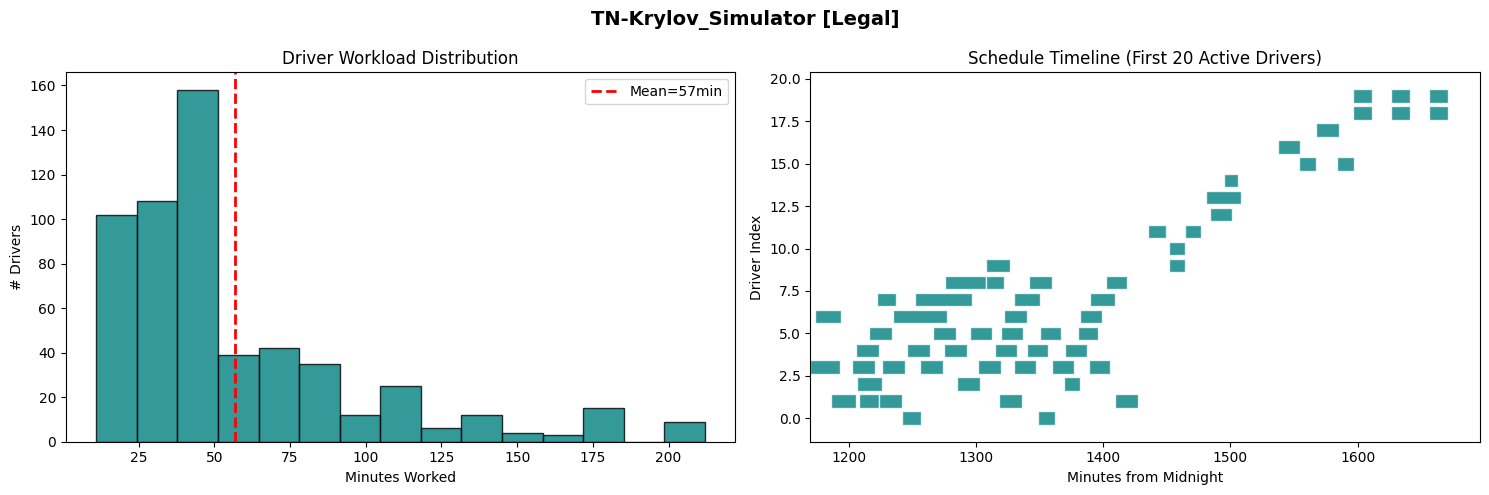

✓ Saved individual_TN-Krylov_Simulator.png


In [56]:
# ==============================================================================
#   CELL 14 — Individual Run Visualizations (ENHANCED)
# ==============================================================================

for label, data in ALL_RESULTS.items():
    schedule = data['schedule']
    kpis = data['kpis']

    active = {d: segs for d, segs in schedule.items() if segs}
    if not active:
        print(f"\n⚠ {label}: No active drivers, skipping plot")
        continue

    workloads = [sum(s.duration_min for s in segs) for segs in active.values()]

    # --- NEW: Build title with CVaR/Flipping/Legalizer info ---
    run_info = []
    if 'config' in data:  # If benchmark results include config
        cfg = data['config']
        used_cvar = cfg.get('override_cvar')
        used_flip = cfg.get('override_flipping')

        # If override is None, use global default
        if used_cvar is None: used_cvar = USE_CVAR
        if used_flip is None: used_flip = USE_PROBABILISTIC_FLIPPING

        if used_cvar: run_info.append('CVaR')
        if used_flip: run_info.append('Flip')
        if USE_LEGALIZER: run_info.append('Legal')  # Always on for all configs

    info_str = f" [{', '.join(run_info)}]" if run_info else ""

    # --- Create plots ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{label}{info_str}', fontsize=14, fontweight='bold')

    # Histogram
    axes[0].hist(workloads, bins=15, color='teal', edgecolor='black', alpha=0.8)
    axes[0].axvline(np.mean(workloads), color='red', ls='--', lw=2, label=f'Mean={np.mean(workloads):.0f}min')
    axes[0].set_title('Driver Workload Distribution')
    axes[0].set_xlabel('Minutes Worked'); axes[0].set_ylabel('# Drivers')
    axes[0].legend()

    # Gantt
    sample = sorted(active.keys())[:20]
    for idx, d_id in enumerate(sample):
        for s in schedule[d_id]:
            axes[1].barh(idx, s.duration_min, left=s.start_time, color='teal', edgecolor='white', alpha=0.8)
    axes[1].set_title('Schedule Timeline (First 20 Active Drivers)')
    axes[1].set_xlabel('Minutes from Midnight'); axes[1].set_ylabel('Driver Index')

    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / f'individual_{label}.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved individual_{label}.png")


---

## 📊 Combined Benchmark Comparison

Side-by-side comparison across all configurations showing the impact of compression,
refinement, and hardware vs simulator.

---


══════════════════════════════════════════════════════════════════════════════════════════
  ⭐ 4-RUN BENCHMARK COMPARISON
══════════════════════════════════════════════════════════════════════════════════════════
              label  coverage_pct  active_drivers  avg_cost  solve_time_sec  clusters_success  krylov_used  avg_workload_min
TN-Krylov_Simulator    149.056604             570 -1.236381    28198.559875               195         True         56.694737
══════════════════════════════════════════════════════════════════════════════════════════


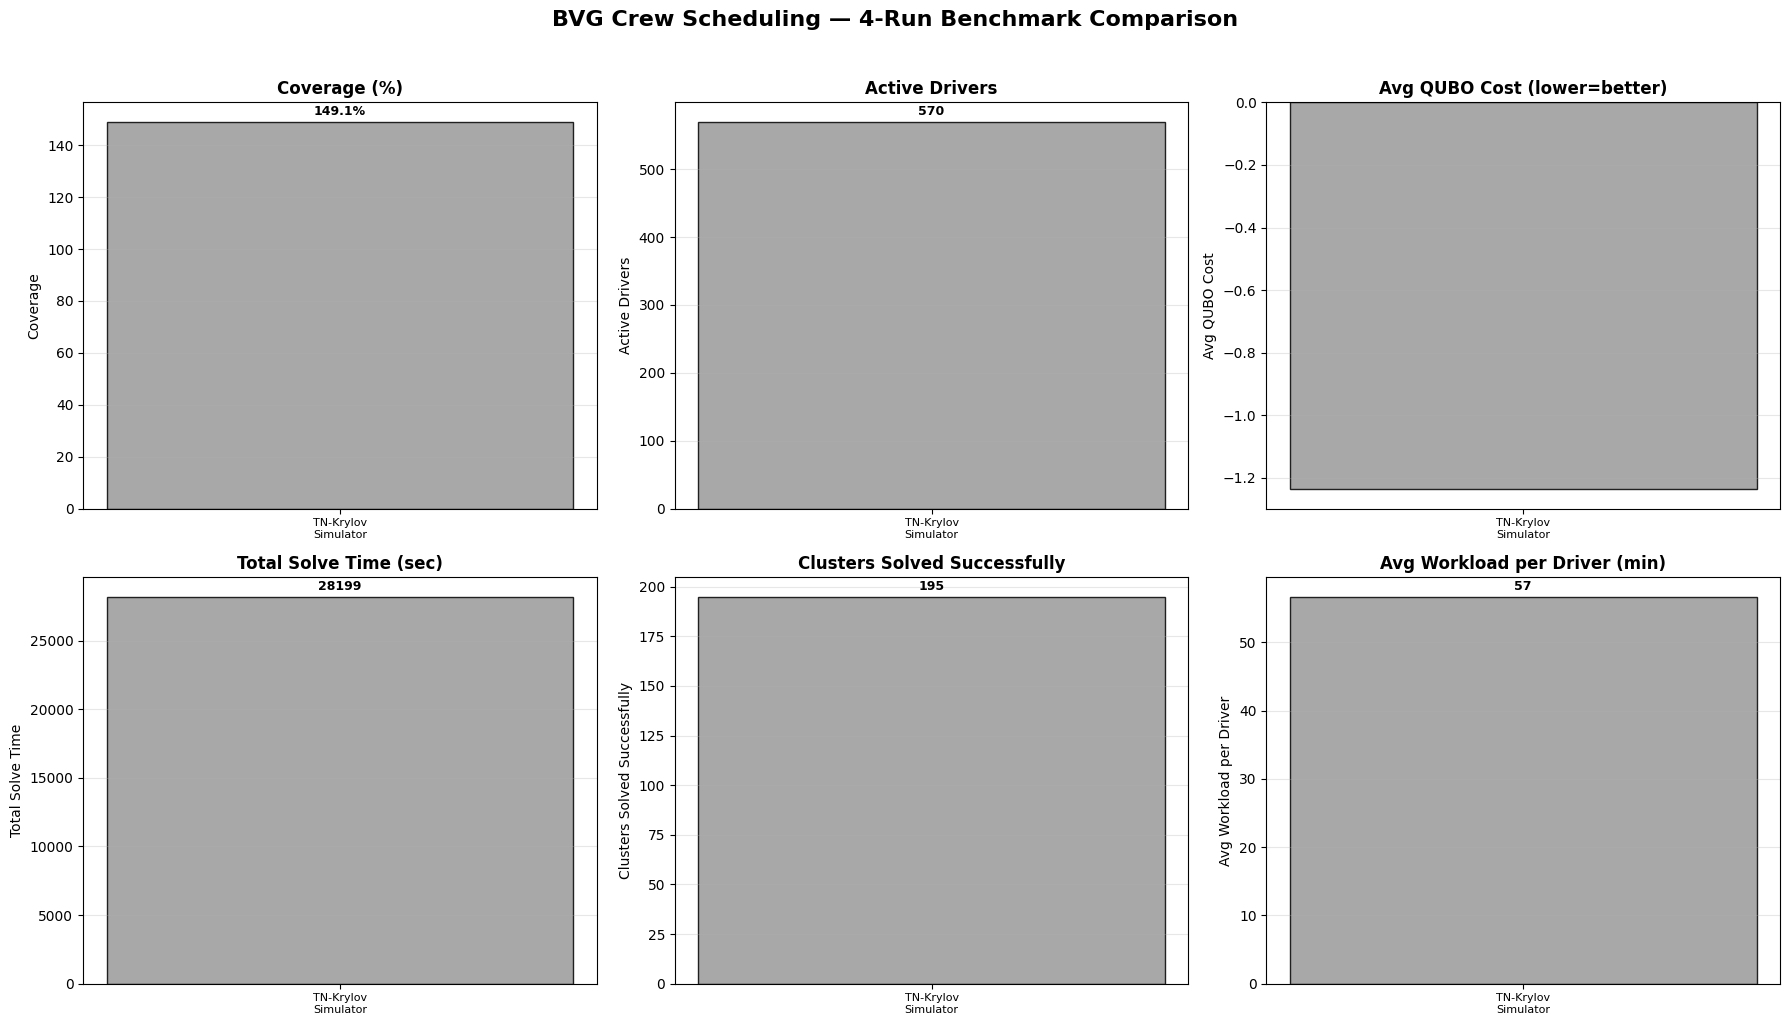


✓ Saved comparison_4runs.png


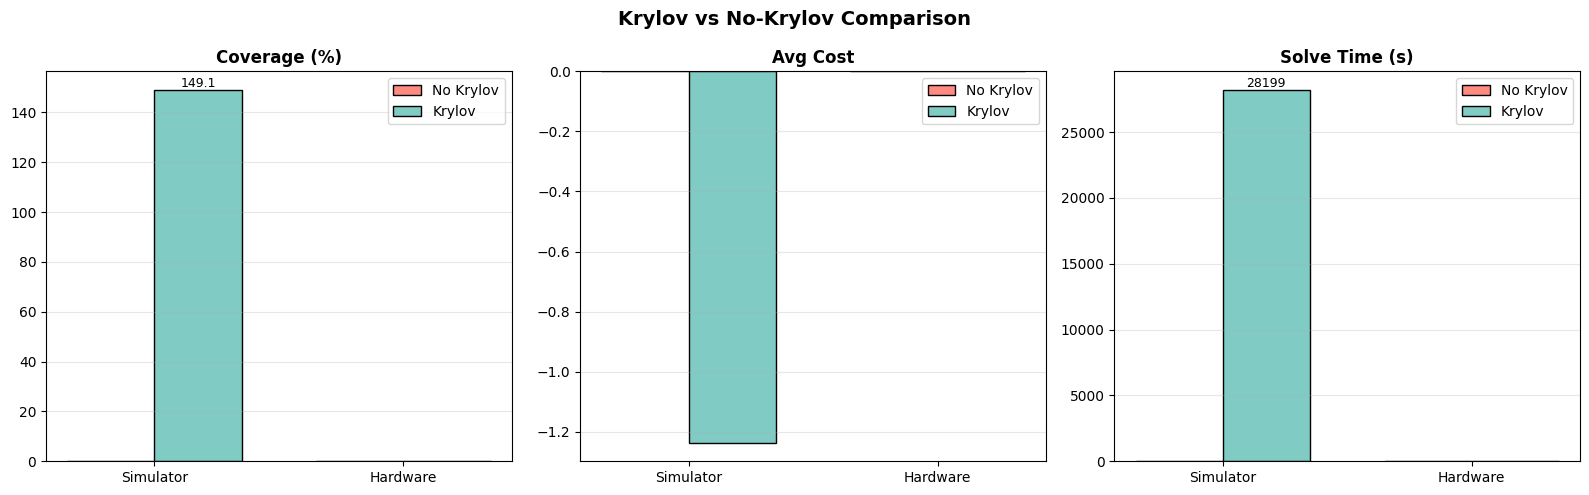

✓ Saved krylov_comparison.png
✓ Saved BVG_4Run_Comparison.xlsx


In [57]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  ⭐ COMBINED COMPARISON — ALL 4 RUNS SIDE BY SIDE                       ║
# ╚══════════════════════════════════════════════════════════════════════════╝

if not ALL_RESULTS:
    print("⚠ No results to compare. Run Cell 12 first.")
else:
    # Build comparison DataFrame
    all_kpis = [data['kpis'] for data in ALL_RESULTS.values()]
    df_compare = pd.DataFrame(all_kpis)

    # Print summary table
    print("═" * 90)
    print("  ⭐ 4-RUN BENCHMARK COMPARISON")
    print("═" * 90)
    display_cols = ['label', 'coverage_pct', 'active_drivers', 'avg_cost',
                    'solve_time_sec', 'clusters_success', 'krylov_used', 'avg_workload_min']
    print(df_compare[display_cols].to_string(index=False))
    print("═" * 90)

    # Color scheme: NoKrylov=coral, Krylov=teal | lighter for Simulator, darker for Hardware
    colors = {
        'NoKrylov_Simulator': '#FF8A80',   # light coral
        'Krylov_Simulator':   '#80CBC4',   # light teal
        'NoKrylov_Hardware':  '#D32F2F',    # dark coral/red
        'Krylov_Hardware':    '#00796B',    # dark teal
    }
    bar_colors = [colors.get(l, '#999999') for l in df_compare['label']]
    short_labels = [l.replace('_', '\n') for l in df_compare['label']]

    # ─── 6-panel comparison figure ─────────────────────────────────────
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('BVG Crew Scheduling — 4-Run Benchmark Comparison',
                 fontsize=16, fontweight='bold', y=1.02)

    metrics = [
        ('coverage_pct',      'Coverage (%)',               '%.1f%%'),
        ('active_drivers',    'Active Drivers',             '%d'),
        ('avg_cost',          'Avg QUBO Cost (lower=better)','%.1f'),
        ('solve_time_sec',    'Total Solve Time (sec)',     '%.0f'),
        ('clusters_success',  'Clusters Solved Successfully','%d'),
        ('avg_workload_min',  'Avg Workload per Driver (min)','%.0f'),
    ]

    for ax, (col, title, fmt) in zip(axes.flat, metrics):
        values = df_compare[col].values
        bars = ax.bar(short_labels, values, color=bar_colors, edgecolor='black', alpha=0.85)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(title.split('(')[0].strip())

        # Add value labels on bars
        for bar, val in zip(bars, values):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(values),
                        fmt % val, ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', labelsize=8)

    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'comparison_4runs.png'), dpi=200, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved comparison_4runs.png")

    # ─── Krylov vs No-Krylov side-by-side bars ─────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Krylov vs No-Krylov Comparison', fontsize=14, fontweight='bold')

    for ax, (col, title, fmt) in zip(axes, [
        ('coverage_pct', 'Coverage (%)', '%.1f'),
        ('avg_cost', 'Avg Cost', '%.1f'),
        ('solve_time_sec', 'Solve Time (s)', '%.0f')
    ]):
        # Group by Krylov vs not
        sim_nk = df_compare[df_compare['label'].str.contains('NoKrylov_Sim')][col].values
        sim_k  = df_compare[df_compare['label'].str.contains('Krylov_Sim') & ~df_compare['label'].str.contains('No')][col].values
        hw_nk  = df_compare[df_compare['label'].str.contains('NoKrylov_Hard')][col].values
        hw_k   = df_compare[df_compare['label'].str.contains('Krylov_Hard') & ~df_compare['label'].str.contains('No')][col].values

        x = np.arange(2)
        w = 0.35
        vals_nk = [sim_nk[0] if len(sim_nk) else 0, hw_nk[0] if len(hw_nk) else 0]
        vals_k  = [sim_k[0]  if len(sim_k)  else 0, hw_k[0]  if len(hw_k)  else 0]

        b1 = ax.bar(x - w/2, vals_nk, w, label='No Krylov', color='#FF8A80', edgecolor='black')
        b2 = ax.bar(x + w/2, vals_k,  w, label='Krylov',    color='#80CBC4', edgecolor='black')
        ax.set_xticks(x); ax.set_xticklabels(['Simulator', 'Hardware'])
        ax.set_title(title, fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        for bars in [b1, b2]:
            for bar in bars:
                if bar.get_height() > 0:
                    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                            fmt % bar.get_height(), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'krylov_comparison.png'), dpi=200, bbox_inches='tight')
    plt.show()
    print("✓ Saved krylov_comparison.png")

    # ─── Save comparison table ─────────────────────────────────────────
    df_compare.to_excel(str(RESULTS_DIR / 'BVG_4Run_Comparison.xlsx'), index=False)
    print("✓ Saved BVG_4Run_Comparison.xlsx")

---

## CVaR / Flipping Ablation Study

Analyzes the **isolated impact** of CVaR filtering and probabilistic flipping.

Expected results per literature:
- **CVaR only:** +10–30% improvement (Barkoutsos et al., 2020)
- **Flipping only:** +5–15% via local search
- **CVaR + Flipping:** Best combination

> If CVaR+Flipping is worse than either alone, reduce PROB_FLIP_RATE to 0.05–0.10.

---


In [58]:
# ═══════════════════════════════════════════════════════════════════
# CVaR/Flipping Ablation Study Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_cvar_flipping_impact(all_results, compression_type="Krylov"):
    """
    Compare CVaR/Flipping impact for a specific compression type.

    Args:
        all_results: List of benchmark results
        compression_type: "Krylov" or "Krylov+TN"
    """
    # Filter for specific compression + hardware runs
    if compression_type == "Krylov":
        # Include Krylov_Hardware (Config 5) as baseline
        target_runs = [r for r in all_results
                      if r['config']['use_krylov']
                      and not r['config'].get('use_tn', False)
                      and (r['config']['backend'] == 'ibm_fez')]  # All hardware configs
    else:  # Krylov+TN
        # Include Krylov+TN_Hardware (Config 6) as baseline
        target_runs = [r for r in all_results
                      if r['config']['use_krylov']
                      and r['config'].get('use_tn', False)
                      and (r['config']['backend'] == 'ibm_fez')]

    if not target_runs:
        print(f"⚠️  No {compression_type} hardware runs found")
        return

    print("=" * 90)
    print(f"CVaR + PROBABILISTIC FLIPPING ABLATION STUDY ({compression_type} + Hardware)")
    print("=" * 90)

    # Group by CVaR/Flipping settings
    comparison = {}
    for run in target_runs:
        label = run['config']['label']
        used_cvar = run['config'].get('override_cvar', USE_CVAR)
        used_flip = run['config'].get('override_flipping', USE_PROBABILISTIC_FLIPPING)

        key = f"CVaR={used_cvar}, Flip={used_flip}"

        # Calculate metrics
        successful = sum(1 for r in run['cluster_results'] if r['status'] == 'SUCCESS')
        total = len(run['cluster_results'])
        avg_time = np.mean([r['time'] for r in run['cluster_results']
                           if r['status'] == 'SUCCESS']) if successful > 0 else 0
        avg_cost = np.mean([r['cost'] for r in run['cluster_results']
                           if r['status'] == 'SUCCESS']) if successful > 0 else 0

        # Mark if this is a baseline config
        is_baseline = label in ['Krylov_Hardware', 'Krylov+TN_Hardware']

        comparison[key] = {
            'label': label,
            'success_rate': successful / total * 100,
            'avg_time': avg_time,
            'avg_cost': avg_cost,
            'successful': successful,
            'total': total,
            'is_baseline': is_baseline  # ← 추가
        }

    # Print comparison table
    print(f"\n{'Configuration':<30} {'Type':<12} {'Success':<15} {'Avg Time':<12} {'Avg Cost':<12}")
    print("-" * 95)

    for key in sorted(comparison.keys()):
        data = comparison[key]
        type_marker = "(Baseline)" if data['is_baseline'] else ""
        print(f"{key:<30} {type_marker:<12} {data['successful']}/{data['total']} ({data['success_rate']:.1f}%)  "
              f"{data['avg_time']:>8.1f}s    {data['avg_cost']:>8.2f}")

    print("=" * 95)

    # Compute relative improvements (baseline = CVaR=False, Flip=False)
    baseline_key = "CVaR=False, Flip=False"
    full_key = "CVaR=True, Flip=True"

    if baseline_key in comparison and full_key in comparison:
        baseline = comparison[baseline_key]
        full = comparison[full_key]

        cost_improvement = (baseline['avg_cost'] - full['avg_cost']) / baseline['avg_cost'] * 100
        success_improvement = full['success_rate'] - baseline['success_rate']

        print(f"\n💡 IMPACT SUMMARY ({compression_type}):")
        print(f"   Cost improvement:    {cost_improvement:+.1f}%")
        print(f"   Success rate change: {success_improvement:+.1f}%")
        print("=" * 95)


# Run analysis for both compression types
if 'benchmark_results' in globals():
    print("\n\n")
    analyze_cvar_flipping_impact(benchmark_results, compression_type="Krylov")
    print("\n\n")
    analyze_cvar_flipping_impact(benchmark_results, compression_type="Krylov+TN")
else:
    print("⚠️  Run Cell 13 first to generate benchmark results")





⚠️  No Krylov hardware runs found



⚠️  No Krylov+TN hardware runs found


---

## 🆕 NEW: Cluster Variable Count Diagnostic

Prints variable counts per cluster. Flags clusters exceeding 20 variables with root cause
analysis. Helps tune MAX_CLUSTER_SIZE and MAX_META_ROUTES parameters.

---


In [101]:
# ═══════════════════════════════════════════════════════════════════════════
# 🆕 NEW CELL: CLUSTER VARIABLE COUNT DIAGNOSTIC
# ═══════════════════════════════════════════════════════════════════════════
# PURPOSE: Identify clusters with >20 variables and diagnose why.
# WHAT THIS ADDS: A diagnostic function — no existing code is modified.
# WHY: Clusters with >20 variables cause noise accumulation on NISQ hardware.
#       This diagnostic helps tune MAX_CLUSTER_SIZE and MAX_META_ROUTES.
# ═══════════════════════════════════════════════════════════════════════════

def diagnose_cluster_sizes(all_meta_data, num_drivers=NUM_DRIVERS_PER_CLUSTER):
    """
    Print variable count analysis for all clusters.
    Flags clusters exceeding 20 variables with root cause analysis.
    """
    print("=" * 80)
    print("  CLUSTER VARIABLE COUNT DIAGNOSTIC")
    print("=" * 80)
    print(f"  {'Cluster':>8} | {'Segments':>8} | {'MetaRoutes':>10} | {'Variables':>9} | {'Status':>12} | Root Cause")
    print(f"  {'---'*8} | {'---'*3} | {'---'*4} | {'---'*3} | {'---'*4} | {'---'*10}")

    oversized = []
    trivial = 0
    healthy = 0

    for c_idx, (cluster_segs, df_meta, meta_to_segs) in enumerate(all_meta_data):
        n_segs = len(cluster_segs)
        n_meta = len(df_meta)
        n_vars = n_meta * num_drivers

        if n_meta <= 3:
            status = "Trivial"
            trivial += 1
            cause = "Solved classically (<=3 meta-routes)"
        elif n_vars <= 20:
            status = "Healthy"
            healthy += 1
            cause = ""
        else:
            status = "OVERSIZED"
            oversized.append(c_idx)
            if n_segs > MAX_CLUSTER_SIZE:
                cause = f"Cluster too large ({n_segs} > MAX_CLUSTER_SIZE={MAX_CLUSTER_SIZE})"
            elif n_meta > 7:
                cause = f"Too many unique routes ({n_meta} meta-routes)"
            else:
                cause = f"High driver count ({num_drivers} drivers x {n_meta} routes)"

        print(f"  {c_idx:>8} | {n_segs:>8} | {n_meta:>10} | {n_vars:>9} | {status:>12} | {cause}")

    print(f"\n  Summary:")
    print(f"    Trivial (classical):  {trivial}")
    print(f"    Healthy (<=20 vars):  {healthy}")
    print(f"    Oversized (>20 vars): {len(oversized)}")

    if oversized:
        print(f"\n  RECOMMENDATION: Reduce MAX_META_ROUTES from {MAX_META_ROUTES} to 7")
        print(f"     This would cap variables at 7 x {num_drivers} = {7 * num_drivers}")
        print(f"     Alternatively, reduce MAX_CLUSTER_SIZE from {MAX_CLUSTER_SIZE} to 10")
    else:
        print(f"\n  All clusters are within healthy variable ranges.")

    print("=" * 80)
    return oversized

# ── Usage (uncomment after Cell 12 runs): ──
# oversized_clusters = diagnose_cluster_sizes(all_meta_data)

print("diagnose_cluster_sizes() defined - uncomment to run after Cell 12")


diagnose_cluster_sizes() defined - uncomment to run after Cell 12


---

## 📋 Pipeline Summary & Complete Reference List

### Architecture: 6-Stage Hybrid Pipeline

1. **Decomposition** (Classical) — Temporal → Spatial → Meta-route
2. **QUBO Encoding** (Classical) — 14 preference types, 3-phase hierarchy
3. **Compression** (Classical) — Krylov + TN mean-field reduction
4. **Quantum Solving** — Kipu BF-DCQO on IBM hardware via PlanQK
5. **Refinement** (Classical) — CVaR + flipping in reduced space
6. **Repair** (Classical) — Legalizer + global post-processing

### References

1. Lucas, A. (2014). Ising formulations of many NP problems. *Frontiers in Physics* 2:5.
2. Glover, F. et al. (2019). Quantum Bridge Analytics I. *4OR* 17:335–371.
3. Ayodele, M. (2022). Penalty Weights in QUBO Formulations. *EvoCOP*. arXiv:2206.11040.
4. Volpe, D. et al. (2024). Optimized QUBO Formulation Methods. arXiv:2406.07681.
5. Ikeda, K. et al. (2019). Quantum Annealing for Nurse Scheduling. *Sci. Rep.* 9:12837.
6. Feld, S. et al. (2019). Hybrid VRP on Quantum Annealer. *Frontiers in ICT* 6:13.
7. Cadavid, A.C. et al. (2024). BF-DCQO. arXiv:2405.13898.
8. Chandarana, P. et al. (2025). Runtime Quantum Advantage. arXiv:2505.08663.
9. Barkoutsos, P. et al. (2020). CVaR for Quantum Optimization. *Quantum* 4:256.
10. Boros, E. et al. (2007). Local Search for QUBO. *J. Heuristics* 13:99–132.
11. Egger, D. et al. (2021). Warm-Starting Quantum Optimization. *Quantum* 5:479.
12. Sachdeva, N. et al. (2024). Bit-flip Error Correction. arXiv:2406.01743.
13. Borndörfer, R. et al. (2003). Duty Scheduling in Public Transit. Springer (ZIB).
14. Desrochers, M. & Soumis, F. (1989). Column Generation for Crew Scheduling. *Transp. Sci.* 23:1–13.
15. Salcedo-Sanz, S. (2009). Repair Methods in EAs. *CS Review* 3:175–192.
16. Epperly, E. et al. (2022). Quantum Subspace Diagonalization. *SIAM JMAA* 43:1263–1290.
17. Kirby, W. (2024). Quantum Krylov with Errors. *Quantum* 8:1457.
18. Veszeli, M. & Vattay, G. (2022). Mean Field for QUBO. *PLOS ONE*. arXiv:2106.03238.
19. Verma, A. & Lewis, M. (2020). Penalty and Partitioning for QUBO. *Disc. Opt.* 36:100594.
20. Borndörfer, R. et al. (2017). Integrated Duty Scheduling & Rostering. *Public Transport* 9:177.
21. Huisman, D. et al. (2005). Multiple-Depot Integrated Scheduling. *Transp. Sci.* 39:491.

---
